In [75]:
import os
import re
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Define Helper Functions

In [76]:
# Leg properties
m_leg = 3e-6
L_leg = 28e-3
I_leg = 1/3 * m_leg * L_leg ** 2

In [77]:
def extract_data(filename, video_fps, num_frames, start_row=2):
    data = np.genfromtxt(filename, delimiter=',')
    data = data[start_row:, :]
    num_cols = data.shape[1]

    # Convert slow-mo to actual time
    t = data[:,0]
    T_slowmo = t[-1]
    T_actual = num_frames / video_fps
    multiplier = T_actual / T_slowmo
    t = multiplier * t

    # Get flicker test data
    if num_cols < 3:
        # Get leg angle
        theta = data[:,1]

        return t, theta

    # Get drop test
    else:
        # Get x and z position data
        x = data[:,1]
        z = data[:,2]

        return t, x, z

def filter(z, fs, fc):
    w = fc / (fs / 2) # Normalized cut-off frequency
    b, a = scipy.signal.butter(N=5, Wn=w, btype='lowpass')
    z_filter = scipy.signal.filtfilt(b, a, z)
    return z_filter

def finite_forward_difference(t, z):
    zdot = np.zeros(len(z) - 1)
    tdot = t[1:]

    for i in range(len(t) - 1):
        dt = t[i+1] - t[i]
        zdot[i] = (z[i+1] - z[i]) / dt

    return tdot, zdot

def coefficient_of_restitution(v):
    cor = np.abs(np.max(v) / np.min(v))
    return cor

def underdamped_func(t, c1, c2, tau1, tau2, w1, w2):
    return c1 * np.exp(-t / tau1) * np.cos(w1 * t) + c2 * np.exp(-t / tau2) * np.sin(w2 * t)

# Flicker Test Analysis Functions

In [78]:
flicker_test_b_and_k = []

In [79]:
def get_spring_flicker_test_b_and_k(filename, leg_name, I_leg, p0):
    print(filename)

    # Plot flicker test curve fit
    fig_ficker_fit, ax_flicker_fit = plt.subplots(1, 1, figsize=(15, 5))
    fig_ficker_fit.suptitle(f"{leg_name}: Flicker Test Curve Fit")

    # Extract video fps from filename
    find_video_fps = re.search(r"_(\d+)fps", filename)
    video_fps = int(find_video_fps[1])
    print(f"video_fps: {video_fps}")

    # Extract number of frames from filename
    find_num_frames = re.search(r"_(\d+)frames", filename)
    num_frames = int(find_num_frames[1])
    print(f"num_frames: {num_frames}")

    # Extract data from file
    t, theta = extract_data(filename, video_fps, num_frames)

    # Normalize angle about 0deg
    theta = theta - np.mean(theta)

    # Optimize exponential decay
    exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0, bounds=(0,np.inf), max_nfev=5000)
    c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

    tau = np.average((tau1, tau2))
    w = w1

    print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
    print(f"tau: {tau}, w: {w}")
    
    # Calculate b and k
    b = 2 * I_leg / tau
    k = I_leg * (w**2 + (1 / tau)**2)

    print(f"b: {b}, k: {k}")


    # Plot fitted data
    ax_flicker_fit.plot(t, theta, label="Raw data")
    ax_flicker_fit.axhline(y=0, color='k')
    ax_flicker_fit.plot(t, underdamped_func(t, c1, c2, tau1, tau2, w1, w2), label="Curve Fit")
    ax_flicker_fit.plot(t, underdamped_func(t, 1, 0, np.inf, np.inf, w1, 0), linestyle="--", label="Harmonic fit")
    ax_flicker_fit.plot(t, underdamped_func(t, c1, c2, tau1, tau2, 0, w2), linestyle="--", label="Exponential fit")

    # Plot labels
    ax_flicker_fit.set_xlabel("t (s)")
    ax_flicker_fit.set_ylabel(r"$\theta$ ($^\circ$)")
    ax_flicker_fit.set_title(f"{leg_name}")

    return b, k

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/25um Kapton Joint/spring_3000fps_5000frames.txt
video_fps: 3000
num_frames: 5000
c1: 11.221298183646283, c2: 2.1089067597660995e-10, tau1: 0.3794108075533025, tau2: 0.002413809873164677, w1: 126.87128042851603, w2: 0.010602615739623955
tau: 0.19091230871323359, w: 126.87128042851603
b: 8.21319489858178e-09, k: 1.2641026675278595e-05
[[8.21319489858178e-09, 0, 1.2641026675278595e-05, 0]]


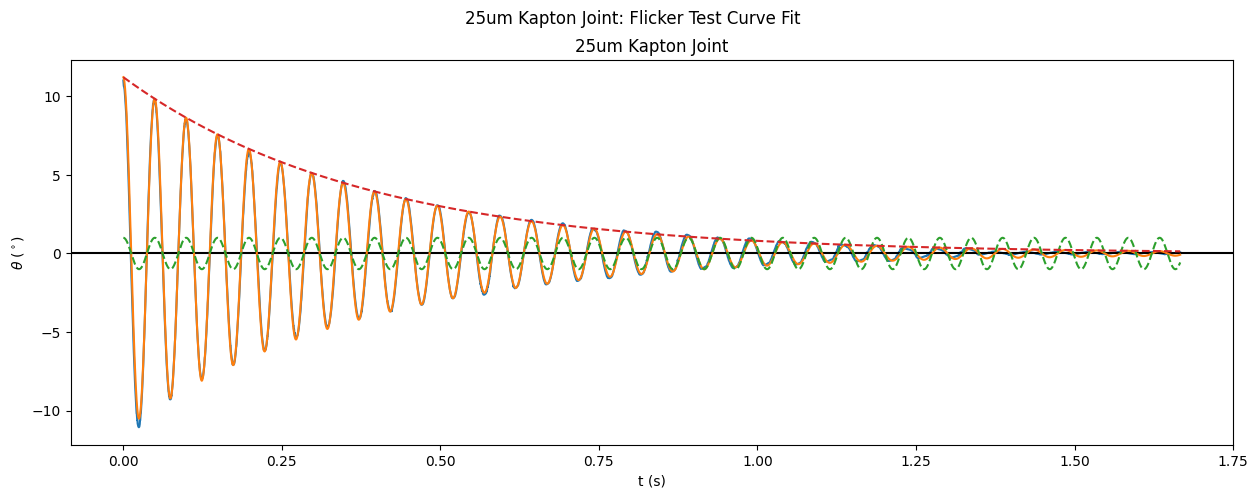

In [80]:
leg_name = "25um Kapton Joint"
filename = os.getcwd() + r"/../Data/Flicker Test/" + leg_name + r"/spring_3000fps_5000frames.txt"
b, k = get_spring_flicker_test_b_and_k(filename, leg_name, I_leg, p0=(10, 10, 10, 10, 100, 10))
result = [b, 0, k, 0]
flicker_test_b_and_k.append(result)
print(flicker_test_b_and_k)

In [81]:
def get_damped_flicker_test_b_and_k(dir_path, leg_name, I_leg, p0):
    # List of files in directory
    files = []

    # Search through directory path
    for path in os.listdir(dir_path):
        # Check if the current path is a text file
        if os.path.isfile(os.path.join(dir_path, path)):
            # Add text file to files
            if path[-3:] == "txt":
                files.append(dir_path + path)

    num_cols = 3
    num_rows = int(len(files) / 3)
    fig_height = 10
        
    # Store damping and spring constants (b and k)
    count = 0
    b_set = []
    k_set = []

    # Plot flicker test curve fit
    fig_ficker_fit, ax_flicker_fit = plt.subplots(num_rows, num_cols, figsize=(18, fig_height))
    fig_ficker_fit.suptitle(f"{leg_name}: Flicker Test Curve Fit")
    
    # Loop through files in target directory
    for i in range(num_rows):
        for j in range(num_cols):
            filename = files[count]
            print(filename)

            # Extract video fps from filename
            find_video_fps = re.search(r"_(\d+)fps", filename)
            video_fps = int(find_video_fps[1])
            print(f"video_fps: {video_fps}")

            # Extract number of frames from filename
            find_num_frames = re.search(r"_(\d+)frames", filename)
            num_frames = int(find_num_frames[1])
            print(f"num_frames: {num_frames}")

            # Extract data from file
            t, theta = extract_data(files[count], video_fps, num_frames)

            # Normalize angle about 0deg
            theta = theta - theta[-1]

            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            theta = filter(theta, fs, fc)

            # Optimize exponential decay
            exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0, bounds=(0,np.inf), max_nfev=5000)
            c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

            tau = np.average((tau1, tau2))
            w = w1

            print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
            print(f"tau: {tau}, w: {w}")
            
            # Calculate b and k
            b = 2 * I_leg / tau
            k = I_leg * (w**2 + (1 / tau)**2)

            print(f"b: {b}, k: {k}")

            b_set.append(b)
            k_set.append(k)

            # Update drop test count
            count = count + 1

            # Plot fitted data
            ax_flicker_fit[i,j].plot(t, theta, label="Raw data")
            ax_flicker_fit[i,j].axhline(y=0, color='k')
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, c1, c2, tau1, tau2, w1, w2), label="Curve Fit")
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, 1, 0, np.inf, np.inf, w1, 0), linestyle="--", label="Harmonic fit")
            ax_flicker_fit[i,j].plot(t, underdamped_func(t, c1, c2, tau1, tau2, 0, w2), linestyle="--", label="Exponential fit")

            # Plot labels
            ax_flicker_fit[i,j].set_xlabel("t (s)")
            ax_flicker_fit[i,j].set_ylabel(r"$\theta$ ($^\circ$)")
            ax_flicker_fit[i,j].set_title(f"Test {count}")

    
    tests = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']
    fig_b, ax_b = plt.subplots(figsize=(10, 5))
    ax_b.set_title(f"{leg_name}: Damping Coefficient (b)")
    ax_b.bar(tests, b_set)
    ax_b.set_ylabel(r"b ($mg \cdot mm^2 / s$)")

    fig_k, ax_k = plt.subplots(figsize=(10, 5))
    ax_k.set_title(f"{leg_name}: Spring Constant (k)")
    ax_k.bar(tests, k_set)
    ax_k.set_ylabel(r"k ($mg \cdot mm^2 / s^2$)")

    b_mean = np.mean(b_set)
    b_std = np.std(b_set)
    print(f"b_mean: {b_mean}")
    print(f"b_std: {b_std}")

    k_mean = np.mean(k_set)
    k_std = np.std(k_set)
    print(f"k_mean: {k_mean}")
    print(f"k_std: {k_std}")

    return b_mean, b_std, k_mean, k_std

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/Buckle Joint/buckle_test6_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 17.78538597965681, c2: 32.70739521893841, tau1: 0.00912124039812719, tau2: 0.009215430517573304, w1: 180.75983444538642, w2: 40.7612340099416
tau: 0.009168335457850247, w: 180.75983444538642
b: 1.7102341065164933e-07, k: 3.494336003404345e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/Buckle Joint/buckle_test4_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 11.334220798329099, c2: 15.003945935325646, tau1: 0.00788052947463394, tau2: 0.008929284675217142, w1: 209.1816025020797, w2: 51.56960734069152
tau: 0.008404907074925541, w: 209.1816025020797
b: 1.8655768422209367e-07, k: 4.540358397299567e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg

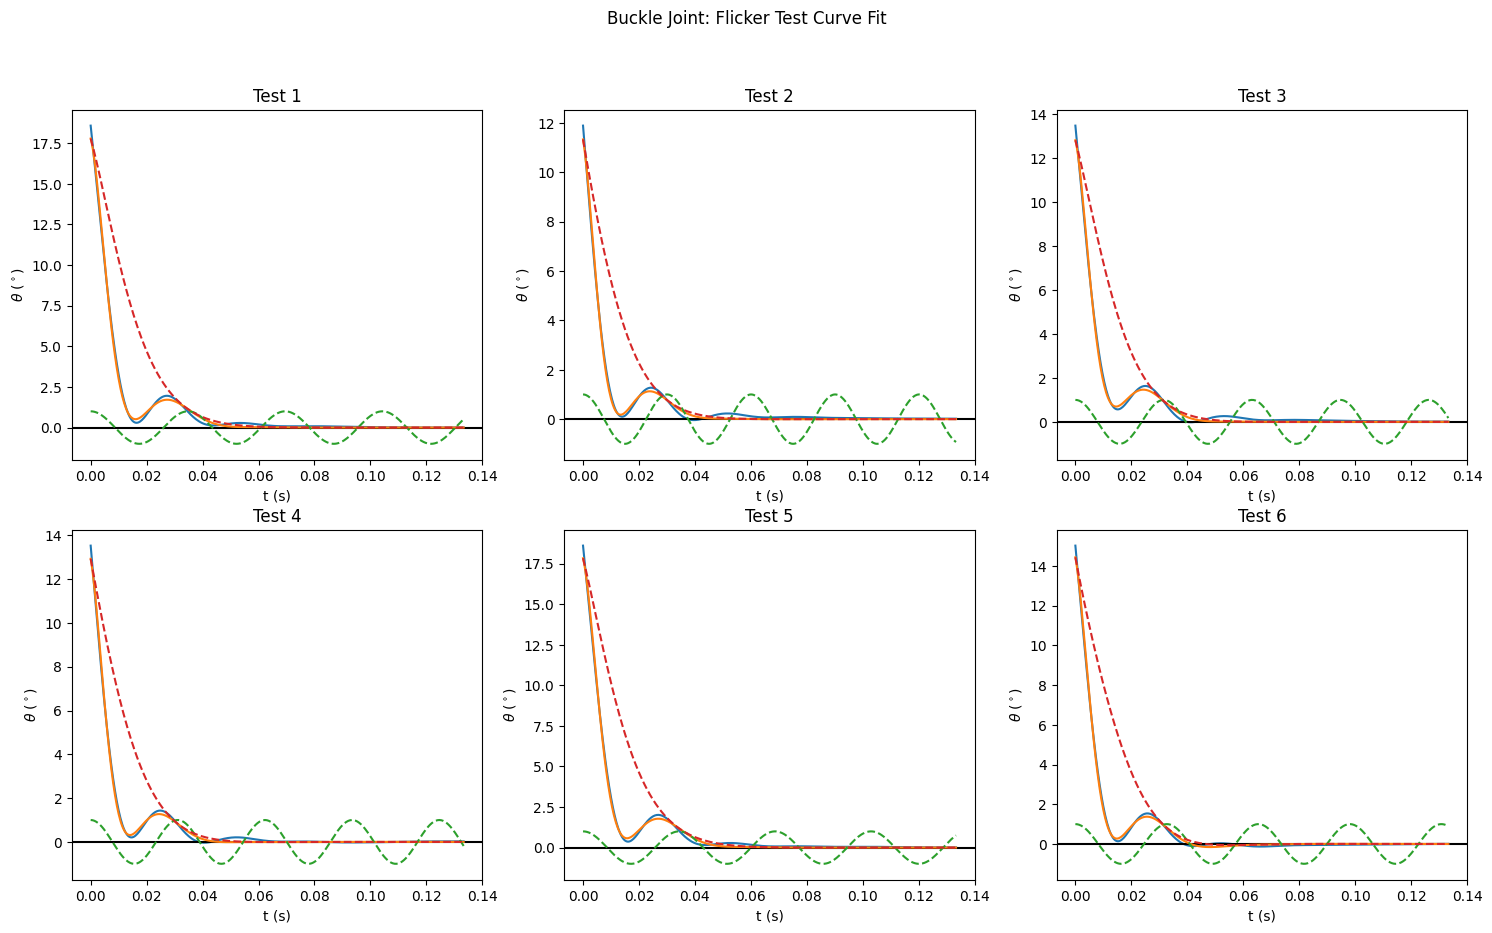

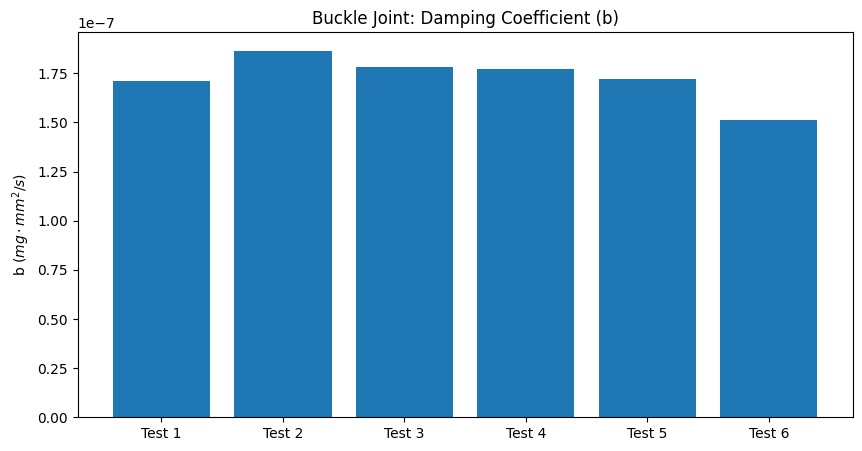

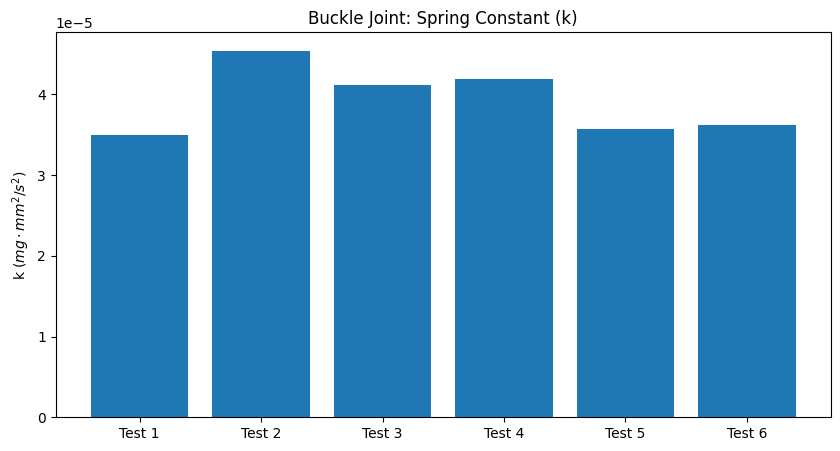

In [82]:
leg_name = "Buckle Joint"
filename = os.getcwd() + r"/../Data/Flicker Test/" + leg_name + r"/"
result = get_damped_flicker_test_b_and_k(filename, leg_name, I_leg, p0=(20, 30, 10, 10, 200, 40))
flicker_test_b_and_k = np.vstack((flicker_test_b_and_k, result))
print(flicker_test_b_and_k)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/7.5um Kapton-TPE Joint/7-5um_test2_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 11.586540382195333, c2: 16.170288477022147, tau1: 0.007442748789097195, tau2: 0.009968519113010233, w1: 218.7918281140413, w2: 46.57766062759532
tau: 0.008705633951053714, w: 218.7918281140413
b: 1.8011324721621362e-07, k: 4.7874610475627524e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/7.5um Kapton-TPE Joint/7-5um_test6_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 15.879183668117639, c2: 4007.106282728838, tau1: 0.007657358448510281, tau2: 0.00954106336344722, w1: 205.4126240344544, w2: 0.25445955584545393
tau: 0.00859921090597875, w: 205.4126240344544
b: 1.8234231223586122e-07, k: 4.3682637387933896e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compli

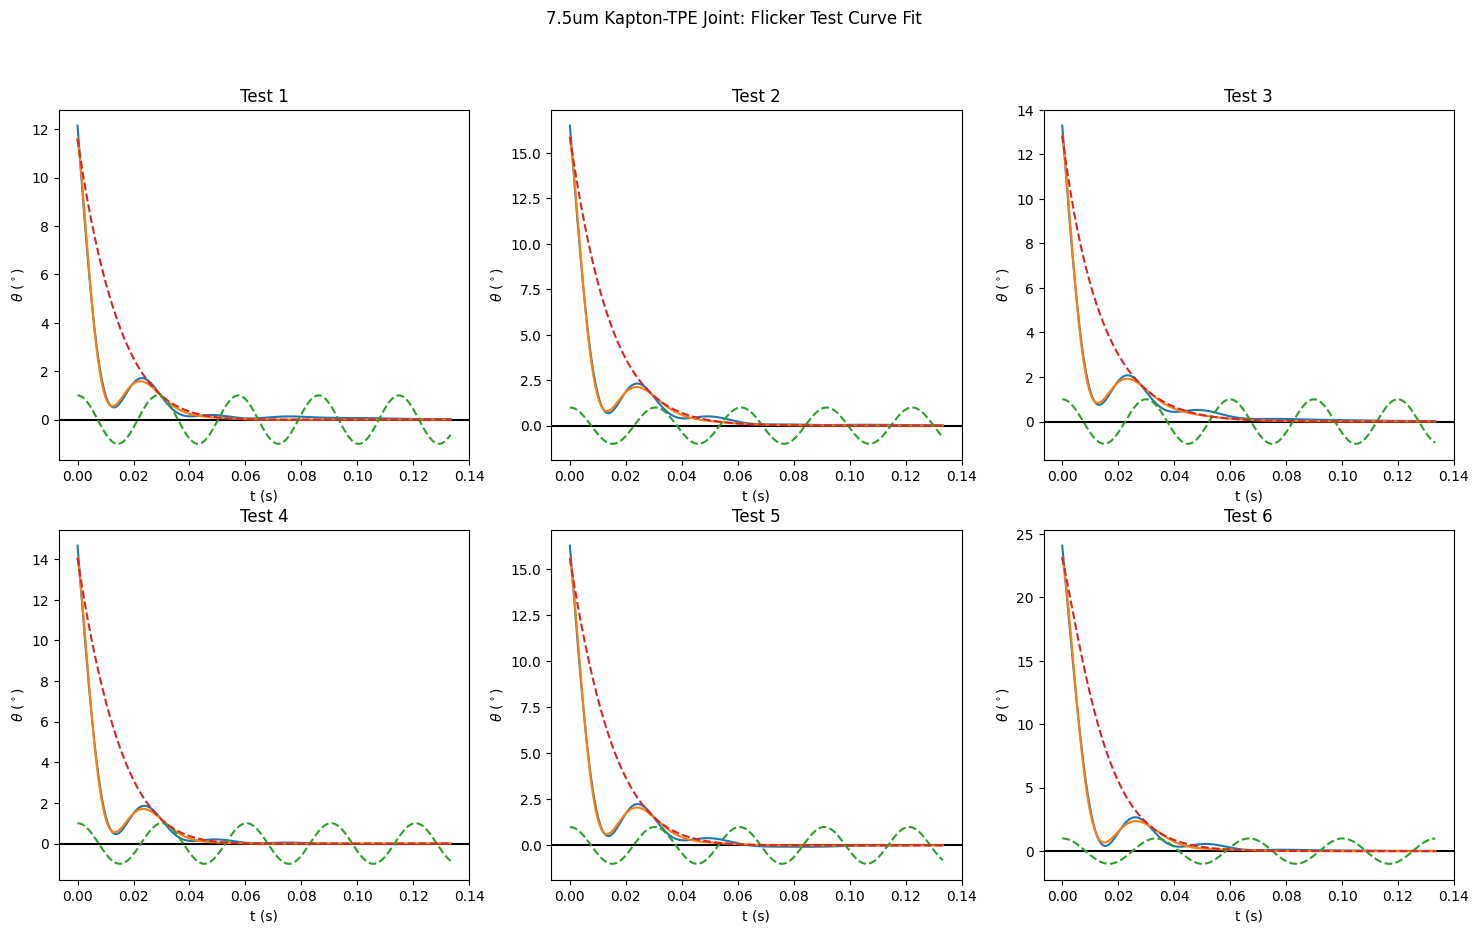

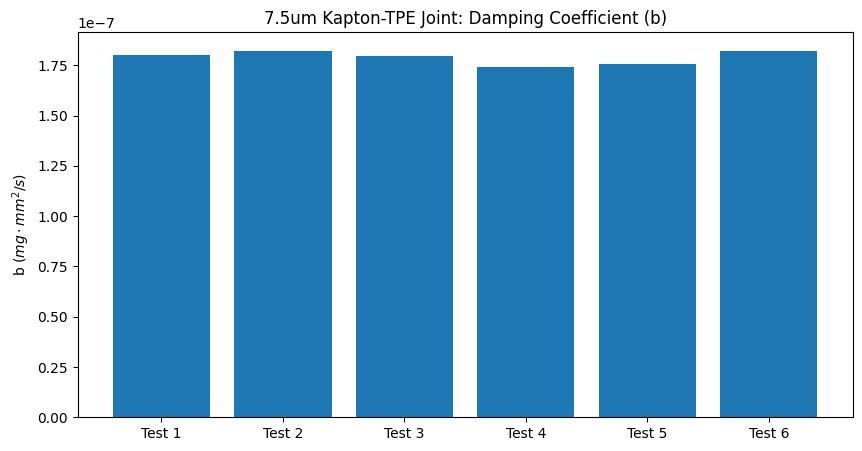

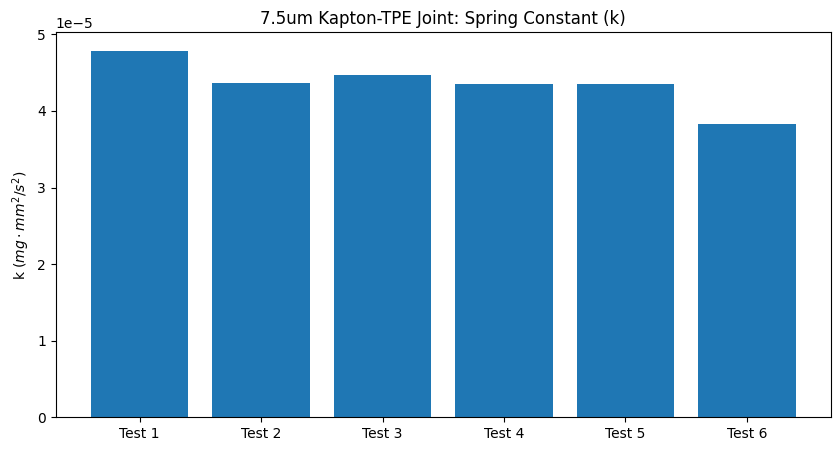

In [87]:
leg_name = "7.5um Kapton-TPE Joint"
filename = os.getcwd() + r"/../Data/Flicker Test/" + leg_name + r"/"
result = get_damped_flicker_test_b_and_k(filename, leg_name, I_leg, p0=(20, 30, 10, 10, 200, 40))
flicker_test_b_and_k = np.vstack((flicker_test_b_and_k, result))
print(flicker_test_b_and_k)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/25um Kapton-TPE Joint/25um_test1_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 16.48022223662559, c2: 9.073762189355413, tau1: 0.007836958807370255, tau2: 0.011540392748219955, w1: 211.90461253295388, w2: 74.35924406246222
tau: 0.009688675777795105, w: 211.90461253295388
b: 1.6183842208793953e-07, k: 4.3556331950916896e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/25um Kapton-TPE Joint/25um_test3_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 16.820441628138894, c2: 20.42549177352122, tau1: 0.007619940726368216, tau2: 0.009405411571664746, w1: 213.37218891107358, w2: 40.076989611637025
tau: 0.00851267614901648, w: 213.37218891107358
b: 1.841958947517533e-07, k: 4.651262799818593e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant 

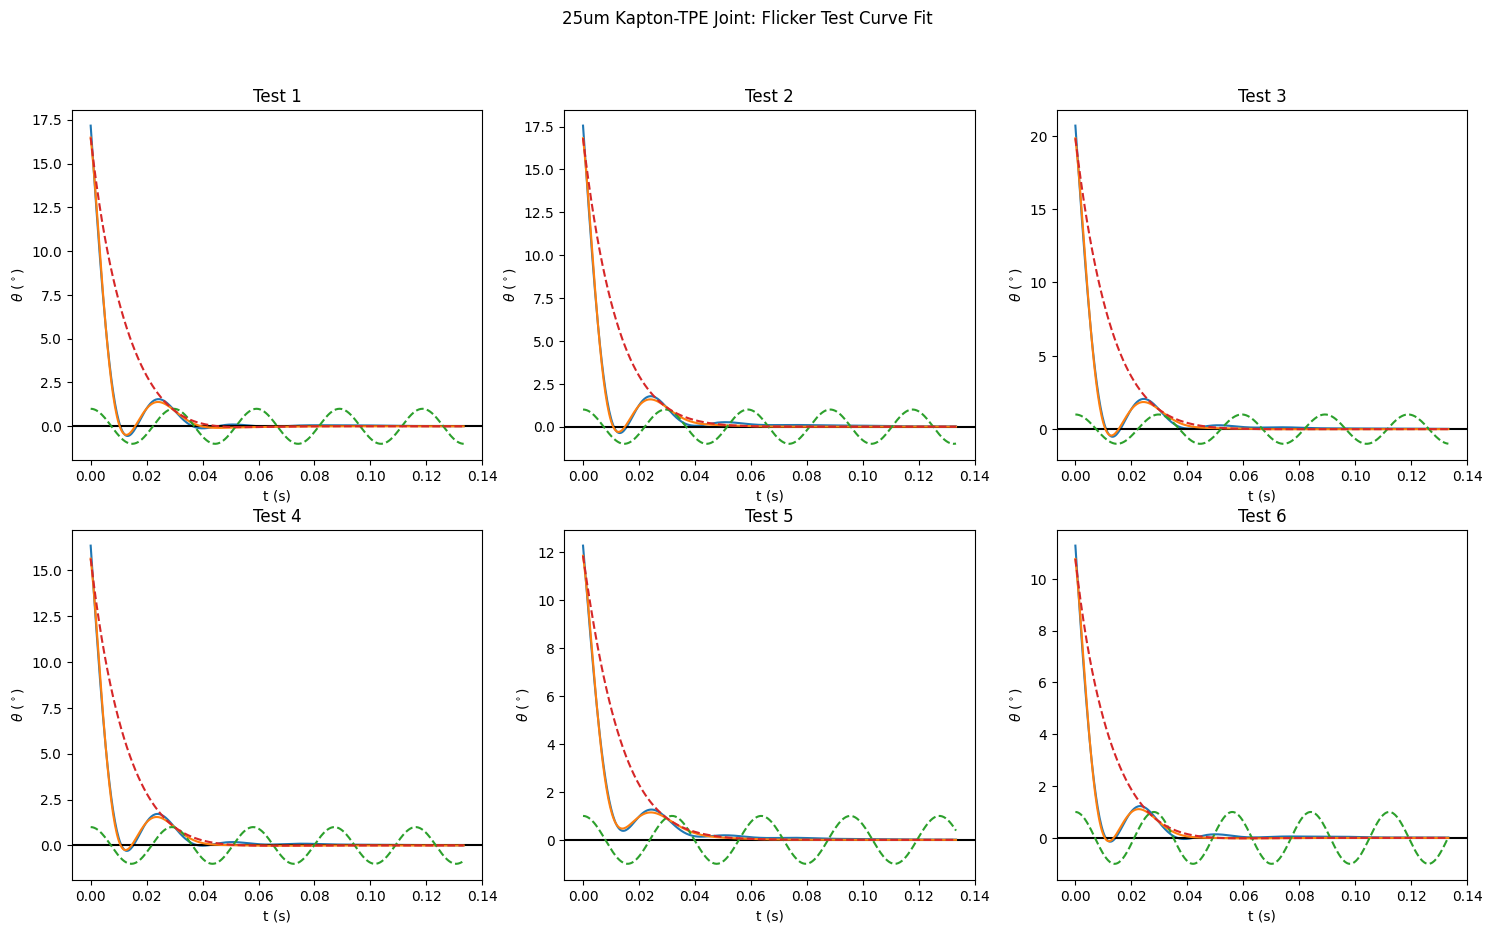

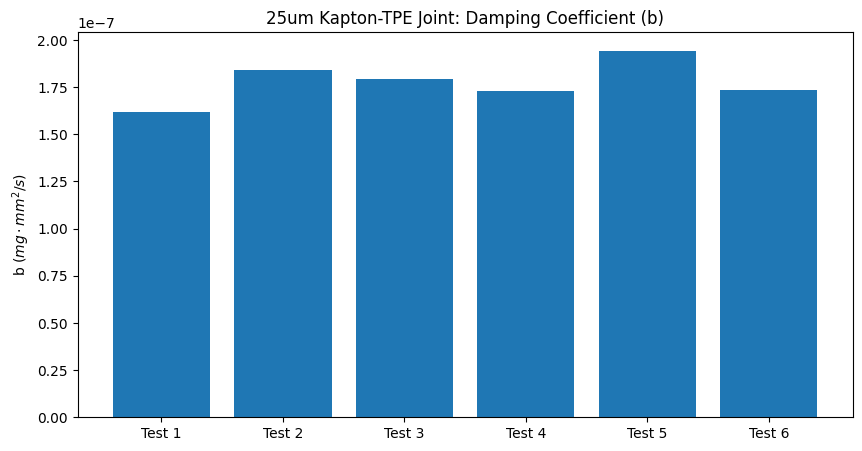

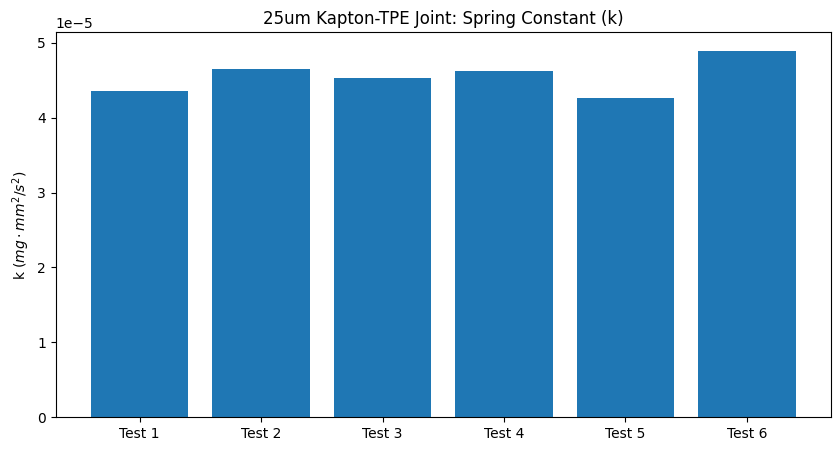

In [88]:
leg_name = "25um Kapton-TPE Joint"
filename = os.getcwd() + r"/../Data/Flicker Test/" + leg_name + r"/"
result = get_damped_flicker_test_b_and_k(filename, leg_name, I_leg, p0=(20, 30, 10, 10, 200, 40))
flicker_test_b_and_k = np.vstack((flicker_test_b_and_k, result))
print(flicker_test_b_and_k)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/50um Kapton-TPE Joint/50um_test4_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 19.76260539776748, c2: 6.008411018477553, tau1: 0.007572794226050568, tau2: 0.011994829811039071, w1: 232.1258708622513, w2: 71.08039788930049
tau: 0.00978381201854482, w: 232.1258708622513
b: 1.602647308664475e-07, k: 5.043411822762568e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Flicker Test/50um Kapton-TPE Joint/50um_test6_3000fps_400frames.txt
video_fps: 3000
num_frames: 400
c1: 18.108791106778842, c2: 10.450387408869183, tau1: 0.007386206592662553, tau2: 0.010739717502375519, w1: 221.28163055686775, w2: 54.768277273356645
tau: 0.009062962047519036, w: 221.28163055686775
b: 1.7301186872223925e-07, k: 4.793399482208554e-05
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Le

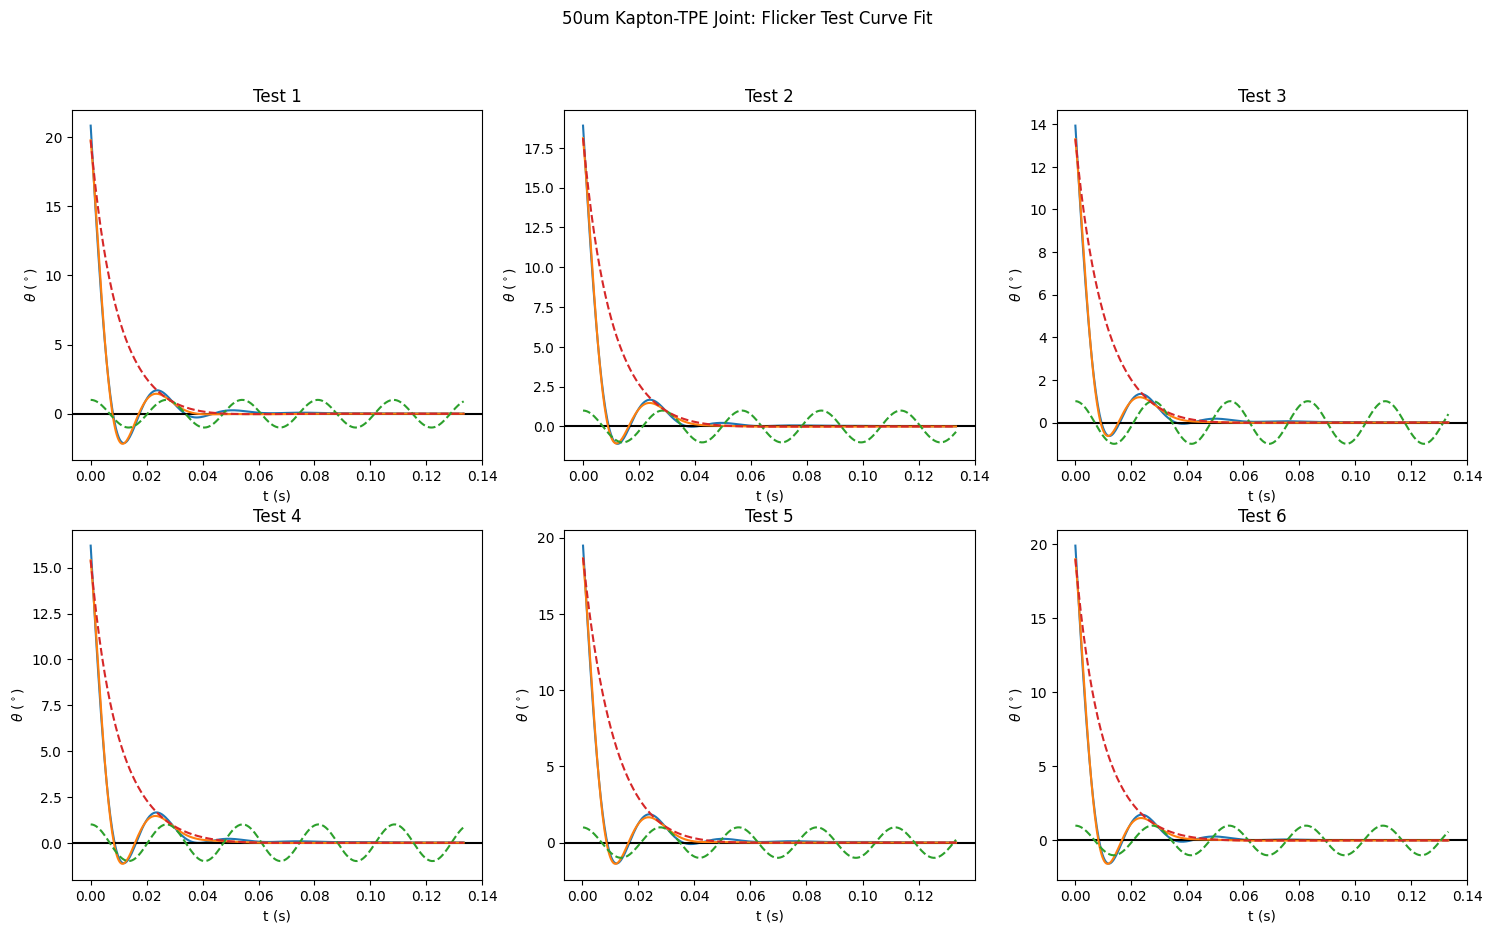

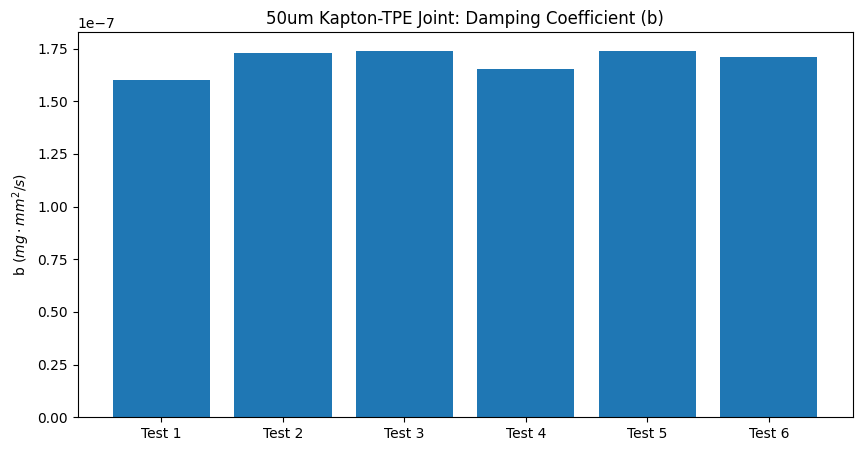

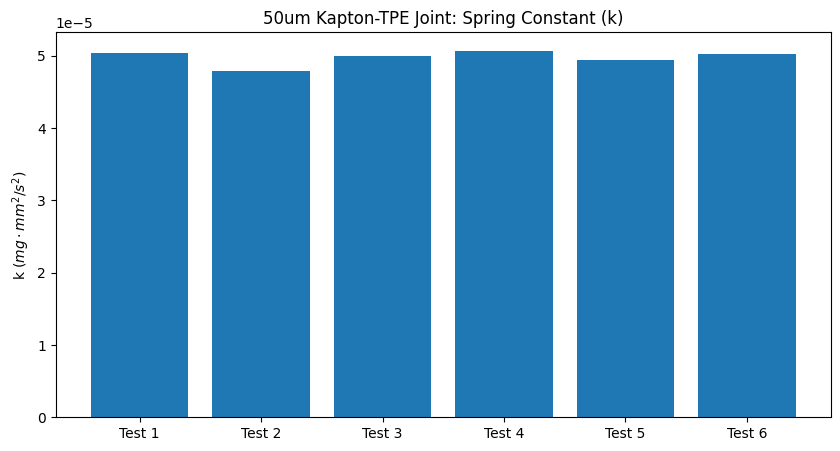

In [89]:
leg_name = "50um Kapton-TPE Joint"
filename = os.getcwd() + r"/../Data/Flicker Test/" + leg_name + r"/"
result = get_damped_flicker_test_b_and_k(filename, leg_name, I_leg, p0=(20, 30, 10, 10, 200, 40))
flicker_test_b_and_k = np.vstack((flicker_test_b_and_k, result))
print(flicker_test_b_and_k)

# Drop Test Analysis Function

In [92]:
def get_drop_test_cor_and_drift(dir_path, leg_name, z0=40, f_sample=3000, f_cutoff=40):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    num_cols = 3
    num_rows = int(len(files) / num_cols)

    count = 0
    cor = []
    x_drift = []

    # Plot vertical position and velocity
    fig_z, ax_z = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_zdot, ax_zdot = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_x, ax_x = plt.subplots(num_rows, num_cols, figsize=(18, 10))
    fig_z.suptitle(f"{leg_name}: Vertical Position")
    fig_zdot.suptitle(f"{leg_name}: Vertical Velocity")
    fig_x.suptitle(f"{leg_name}: Horizontal Position")
    for i in range(num_rows):
        for j in range(num_cols):
            filename = files[count]
            print(filename)

            # Extract video fps from filename
            find_video_fps = re.search(r"_(\d+)fps", filename)
            video_fps = int(find_video_fps[1])
            print(f"video_fps: {video_fps}")

            # Extract number of frames from filename
            find_num_frames = re.search(r"_(\d+)frames", filename)
            num_frames = int(find_num_frames[1])
            print(f"num_frames: {num_frames}")

            t, x, z = extract_data(filename, video_fps, num_frames)

            # Offset initial drop height
            z = z + z0
            
            # Apply filter to raw position data
            z_filter = filter(z, f_sample, f_cutoff)
            
            # Compute velocity and filter
            tdot, zdot = finite_forward_difference(t, z_filter)
            zdot_filter = filter(zdot, f_sample, f_cutoff)

            # Update drop test count
            count = count + 1
            
            # Plot vertical position
            ax_z[i,j].plot(t, z, marker='.', color="tab:blue", label="Raw Position")
            ax_z[i,j].plot(t, z_filter, color="tab:orange", label="Filtered Position")
            ax_z[i,j].set_title(f"Test {count}")
            ax_z[i,j].set_xlabel("t (s)")
            ax_z[i,j].set_ylabel("z (mm)")
            ax_z[i,j].set_ylim(0, z0)

            # Plot vertical velocity
            ax_zdot[i,j].plot(tdot, zdot, color="tab:blue", label="Forward-Difference Velocity")
            ax_zdot[i,j].plot(tdot, zdot_filter, color="tab:orange", label="Filtered Velocity")
            ax_zdot[i,j].set_title(f"Test {count}")
            ax_zdot[i,j].set_ylabel("velocity (mm/s)")
            ax_zdot[i,j].set_xlabel("t (s)")
            ax_zdot[i,j].set_ylim(-800, 400)

            # Plot horizontal position
            ax_x[i,j].plot(t, x, marker='.', color="tab:blue", label="Raw Position")
            ax_x[i,j].set_title(f"Test {count}")
            ax_x[i,j].set_xlabel("t (s)")
            ax_x[i,j].set_ylabel("z (mm)")

            v = zdot_filter
            cor.append(coefficient_of_restitution(v))

            dx = np.abs(x[-1] - x[0])
            x_drift.append(dx)


    tests = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']
    fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
    ax_cor.set_title(f"{leg_name}: Coefficient of Restitution")
    ax_cor.bar(tests, cor)
    ax_cor.set_ylabel(r"$v_f / v_0$")

    fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
    ax_drift.set_title(f"{leg_name}: Horizontal Drift")
    ax_drift.bar(tests, x_drift)
    ax_drift.set_ylabel("dx (mm)")

    cor_mean = np.mean(cor)
    cor_std = np.std(cor)
    print(f"cor_mean: {cor_mean}")
    print(f"cor_std: {cor_std}")

    x_drift_mean = np.mean(x_drift)
    x_drift_std = np.std(x_drift)
    print(f"x_drift_mean: {x_drift_mean}")
    print(f"x_drift_std: {x_drift_std}")

    return cor_mean, cor_std, x_drift_mean, x_drift_std

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Legacy Leg/legacy_test3_3000fps_400frames_fail.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Legacy Leg/legacy_test4_3000fps_400frames_fail.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Legacy Leg/legacy_test5_3000fps_400frames_fail.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Legacy Leg/legacy_test2_3000fps_400frames_fail.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee

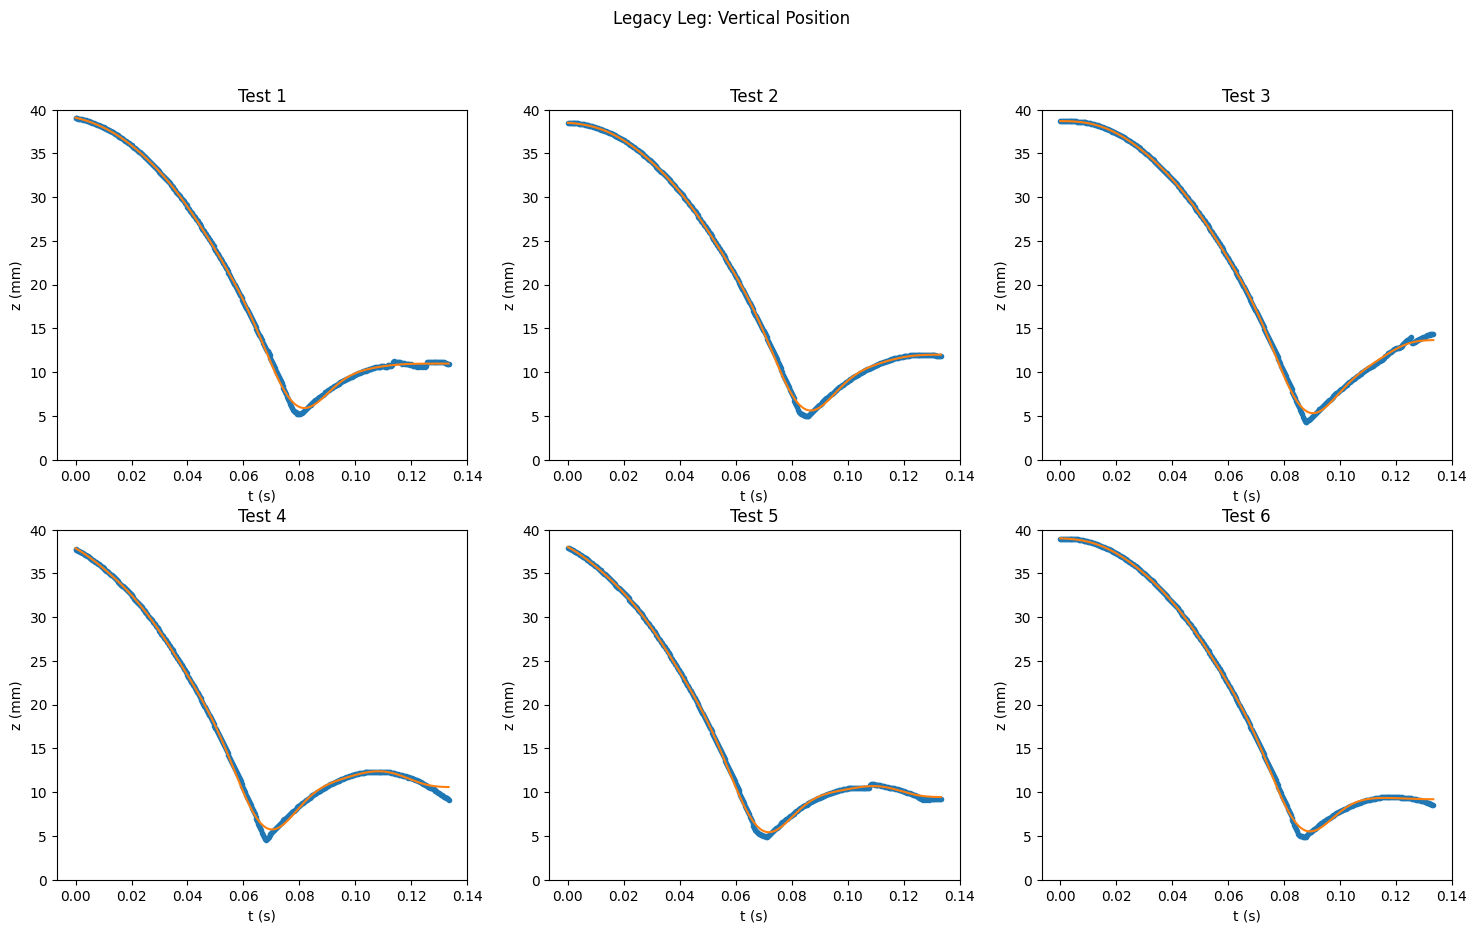

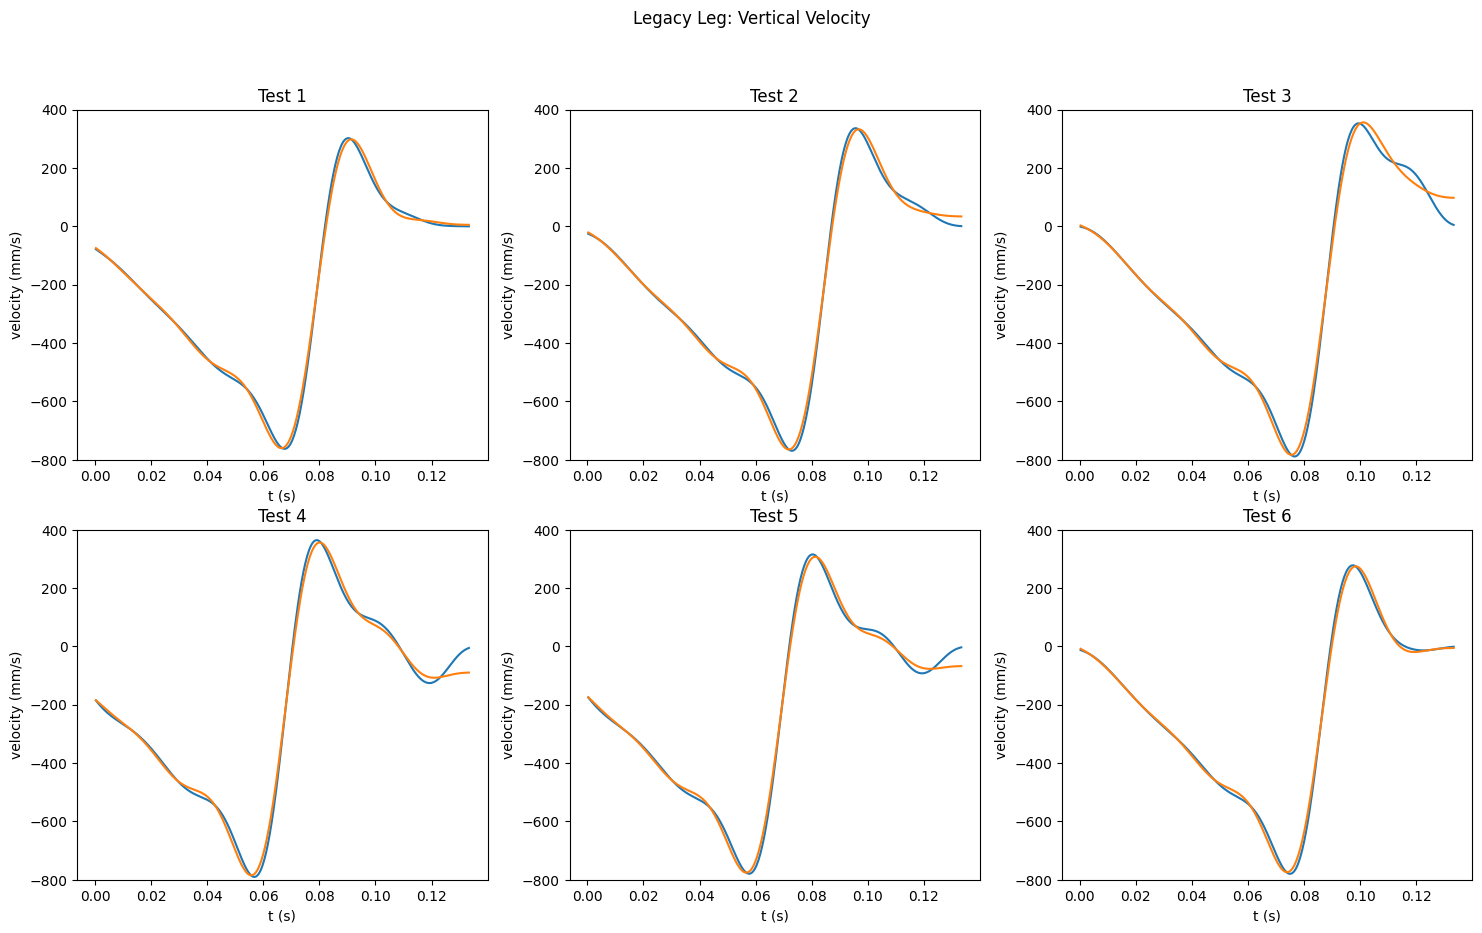

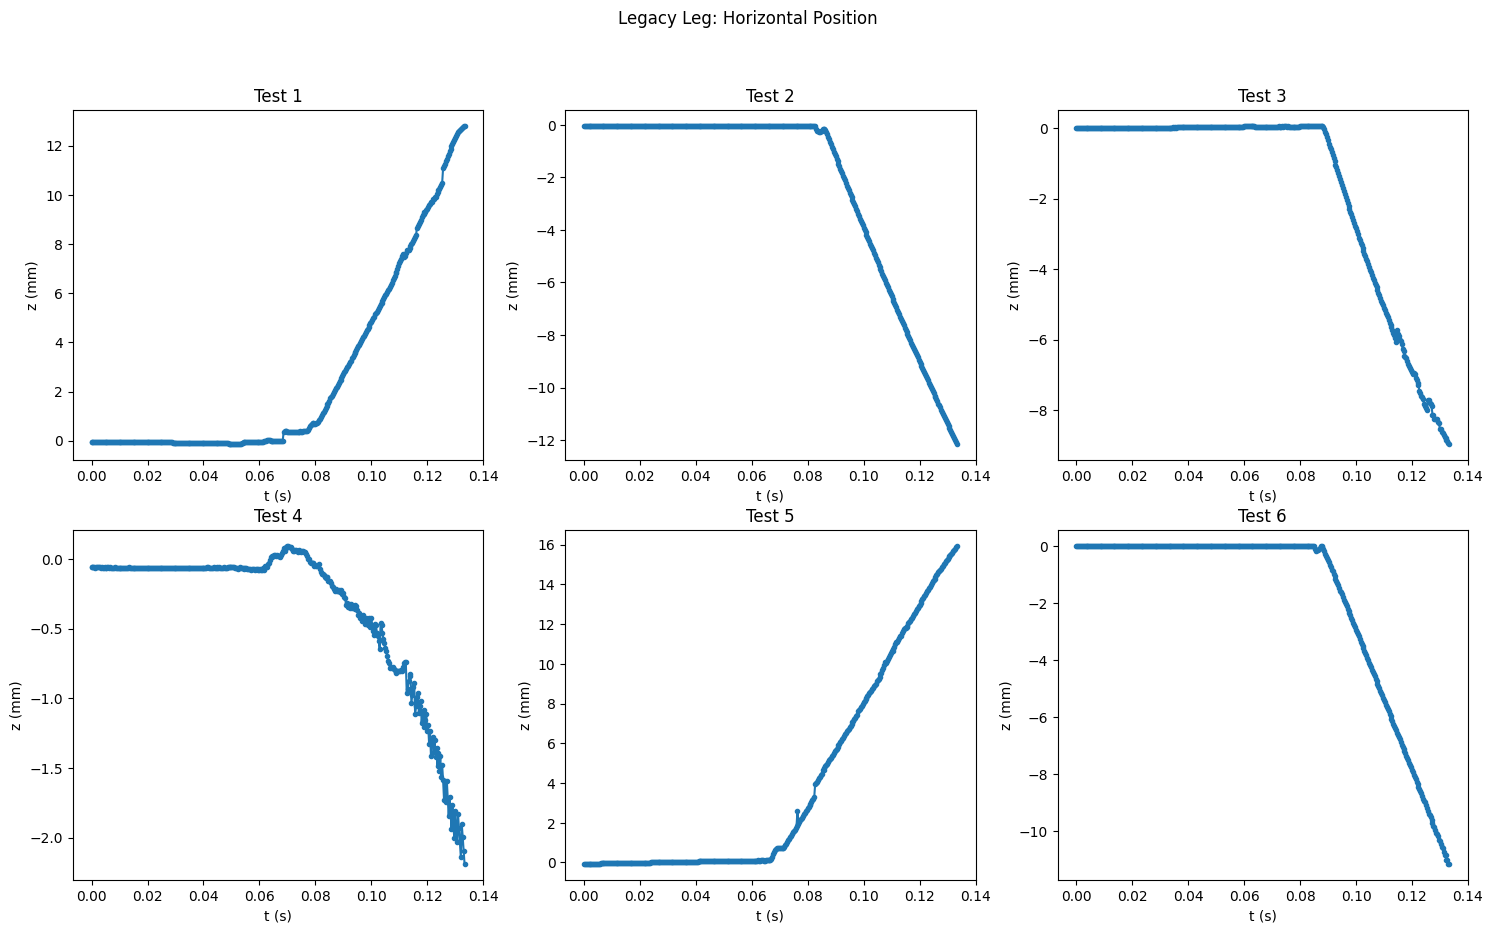

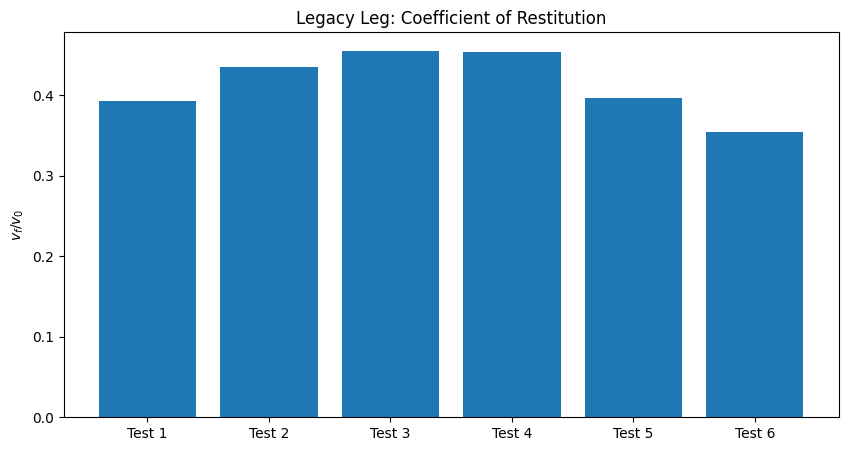

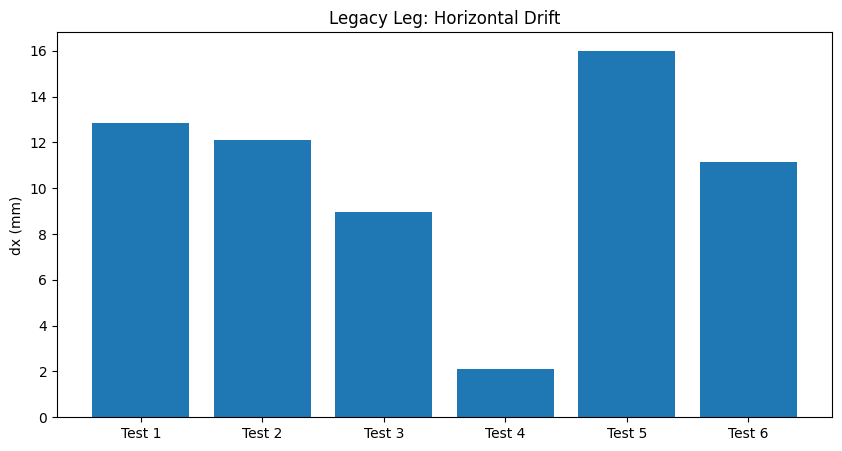

In [93]:
leg_name = "Legacy Leg"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_name + r"/"
result = get_drop_test_cor_and_drift(filename, leg_name)
drop_test_cor_and_drift = result

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test1_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test6_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/30deg Stance/rigid_30deg_test3_3000fps_400frames_success.txt
video_fps: 3

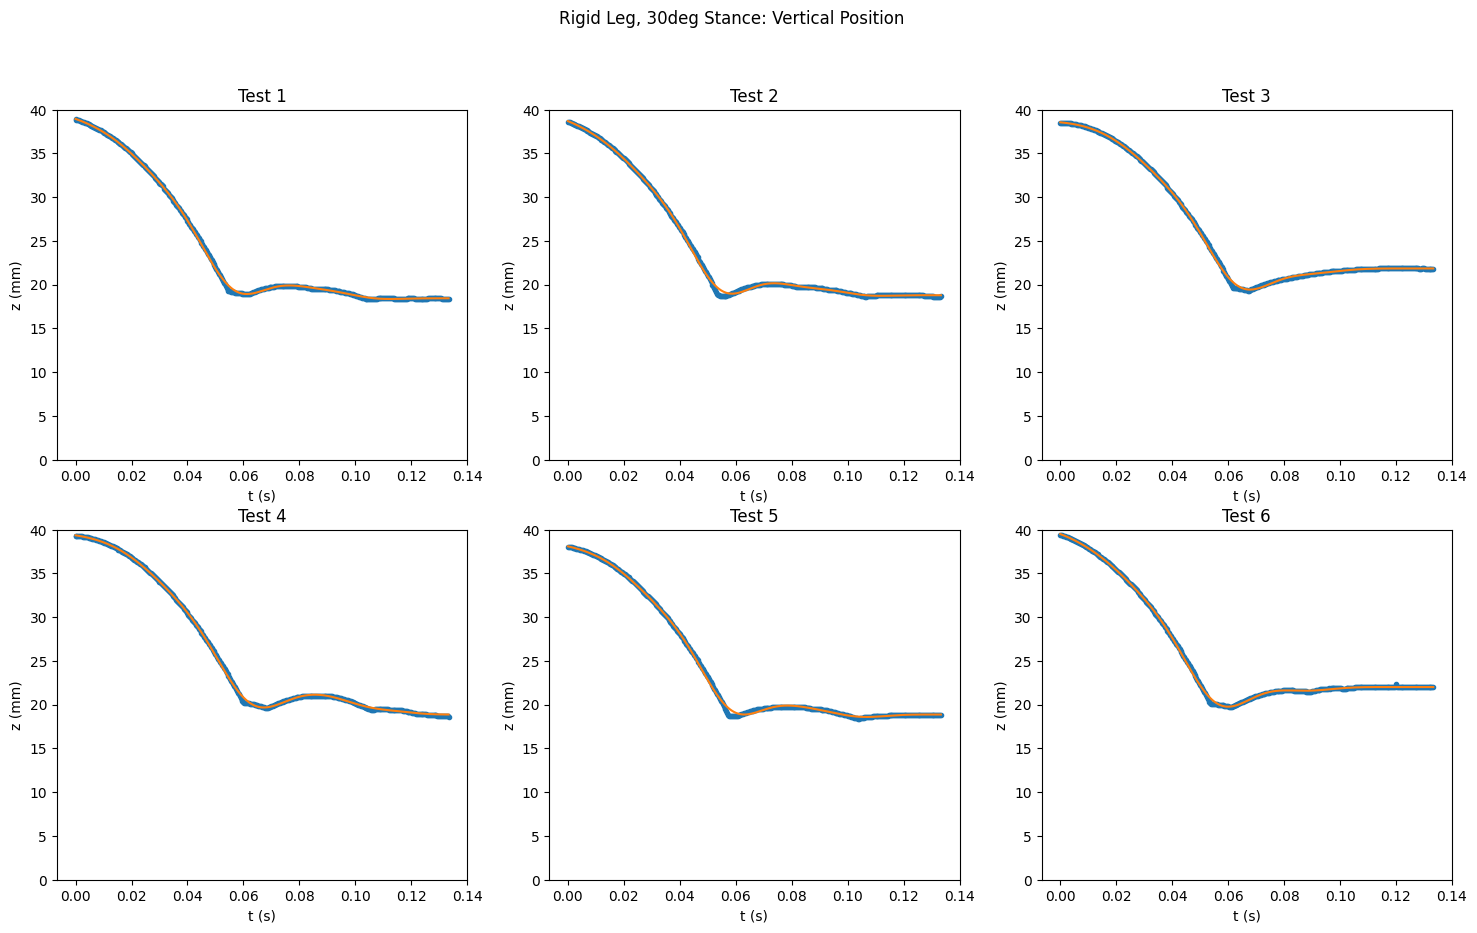

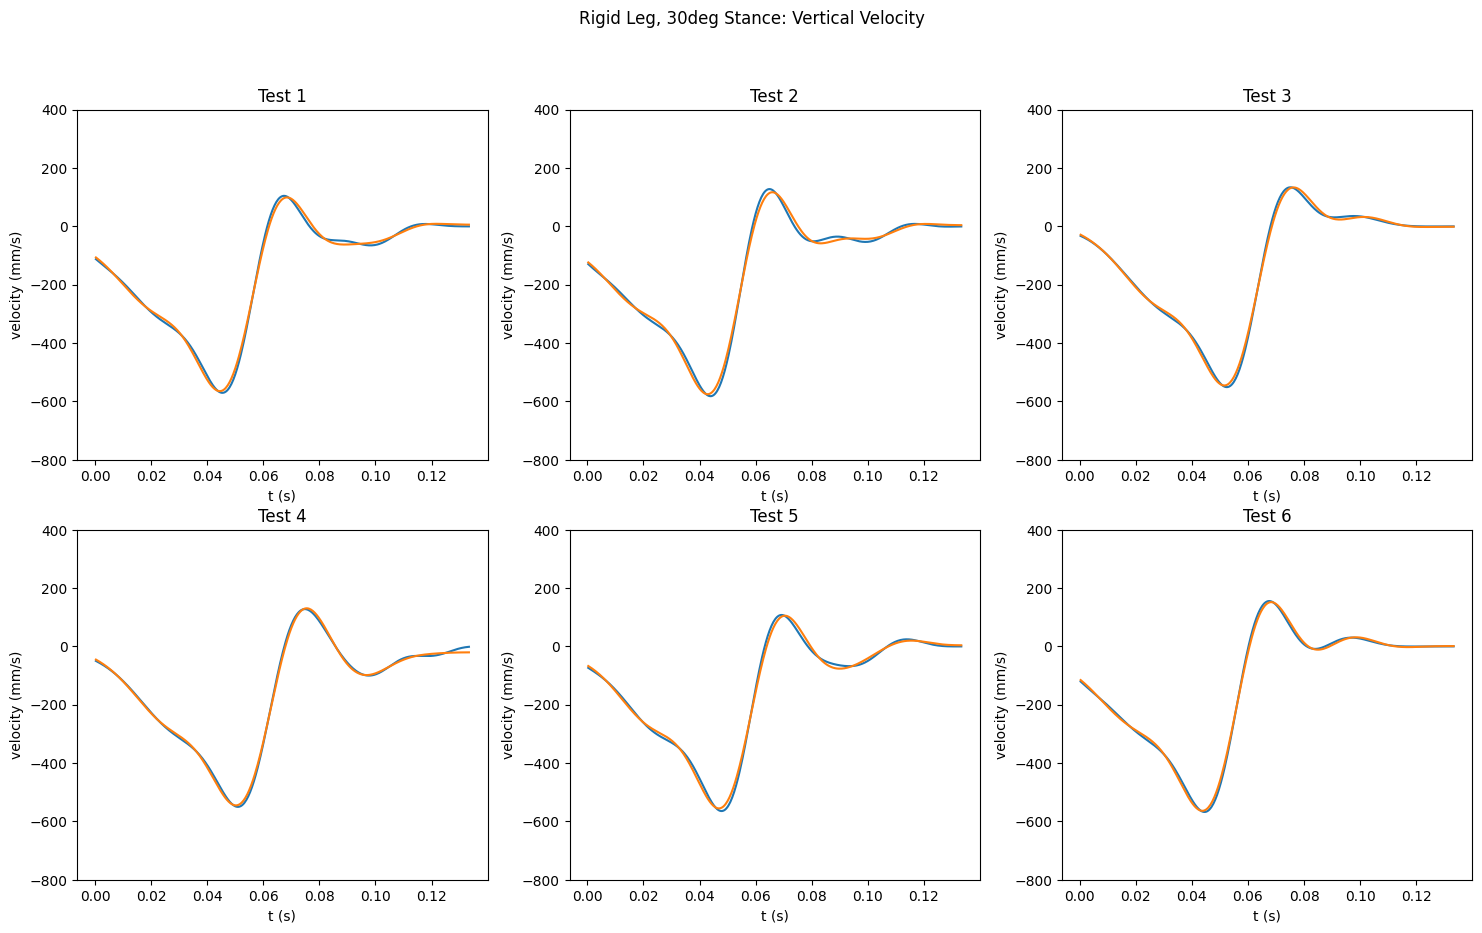

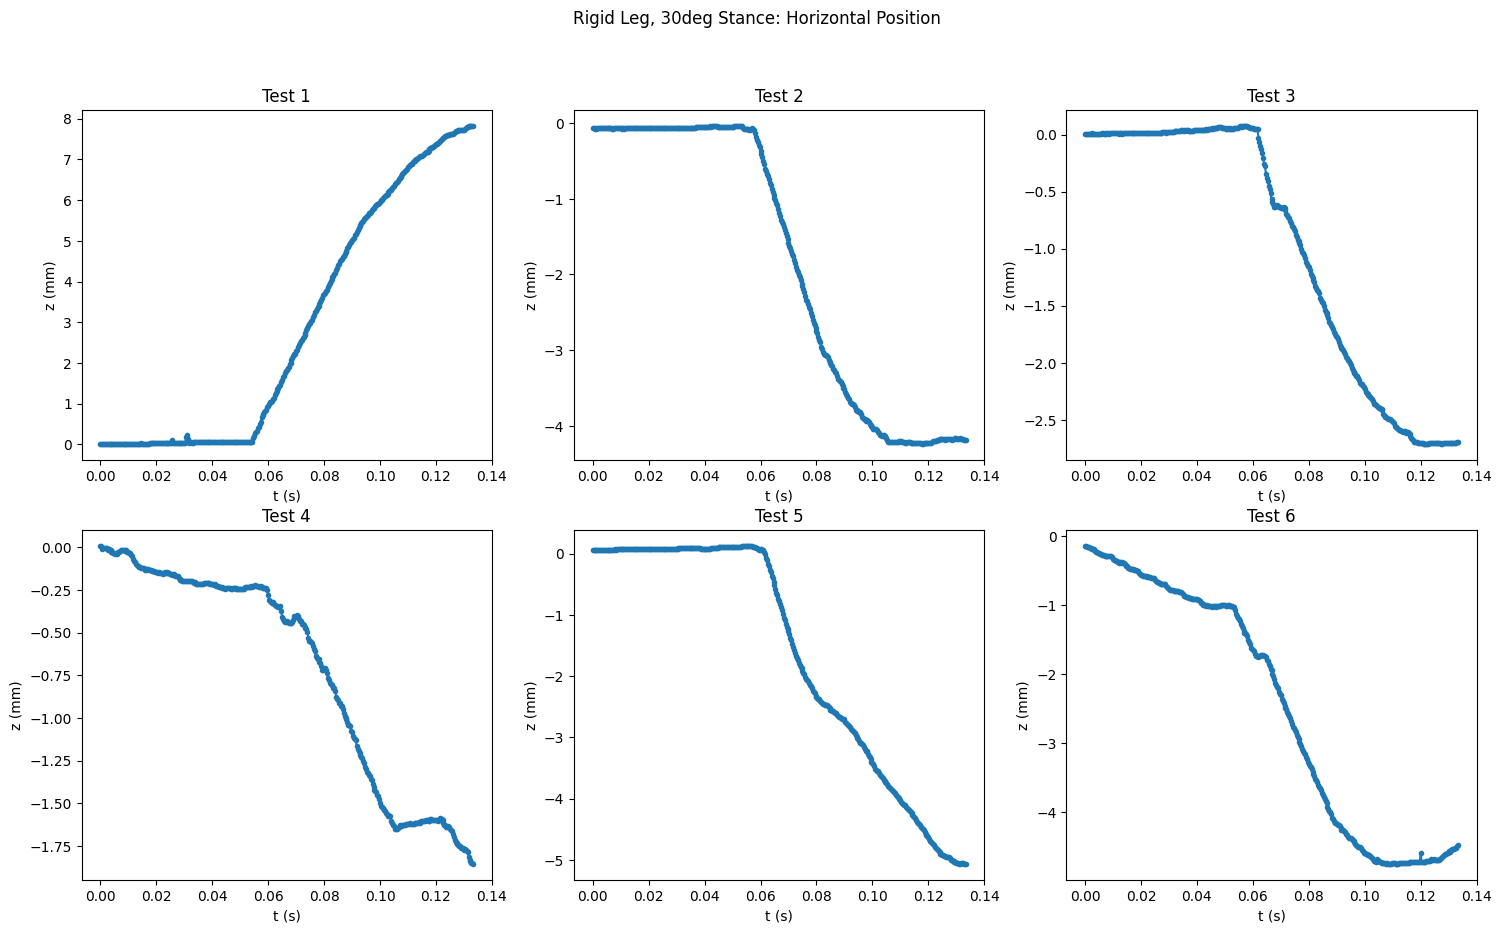

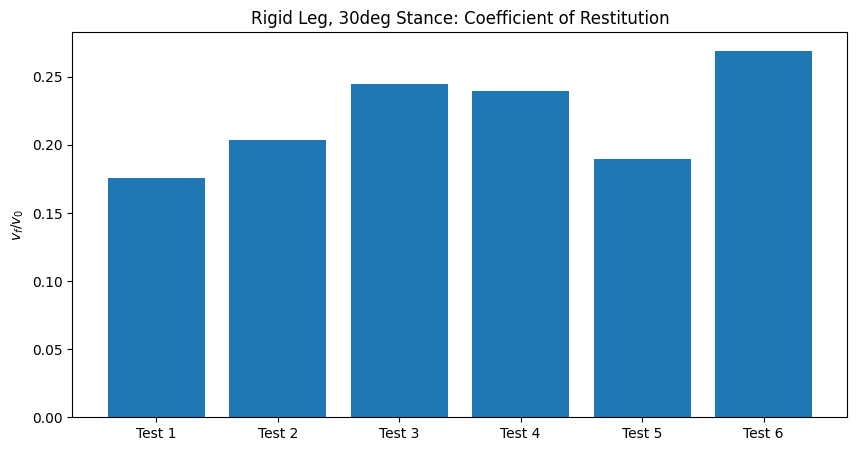

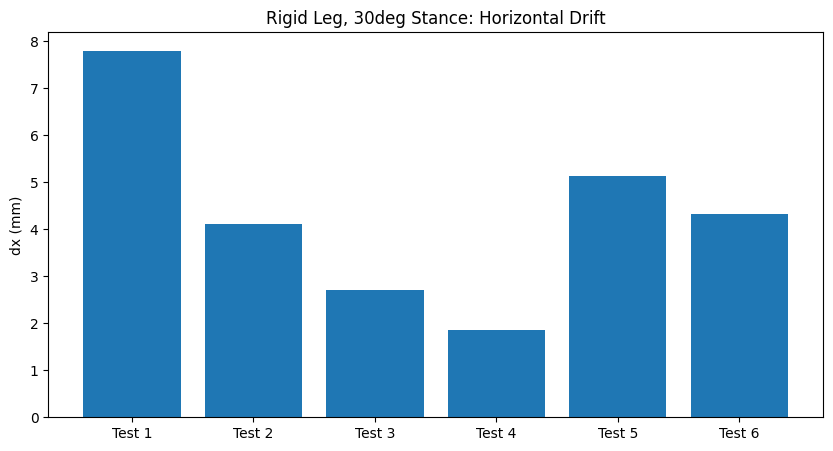

In [ ]:
leg_type = "Rigid Leg"
leg_name = "30deg Stance"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test6_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test1_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/45deg Stance/rigid_45deg_test5_3000fps_400frames_success.txt
video_fps: 3

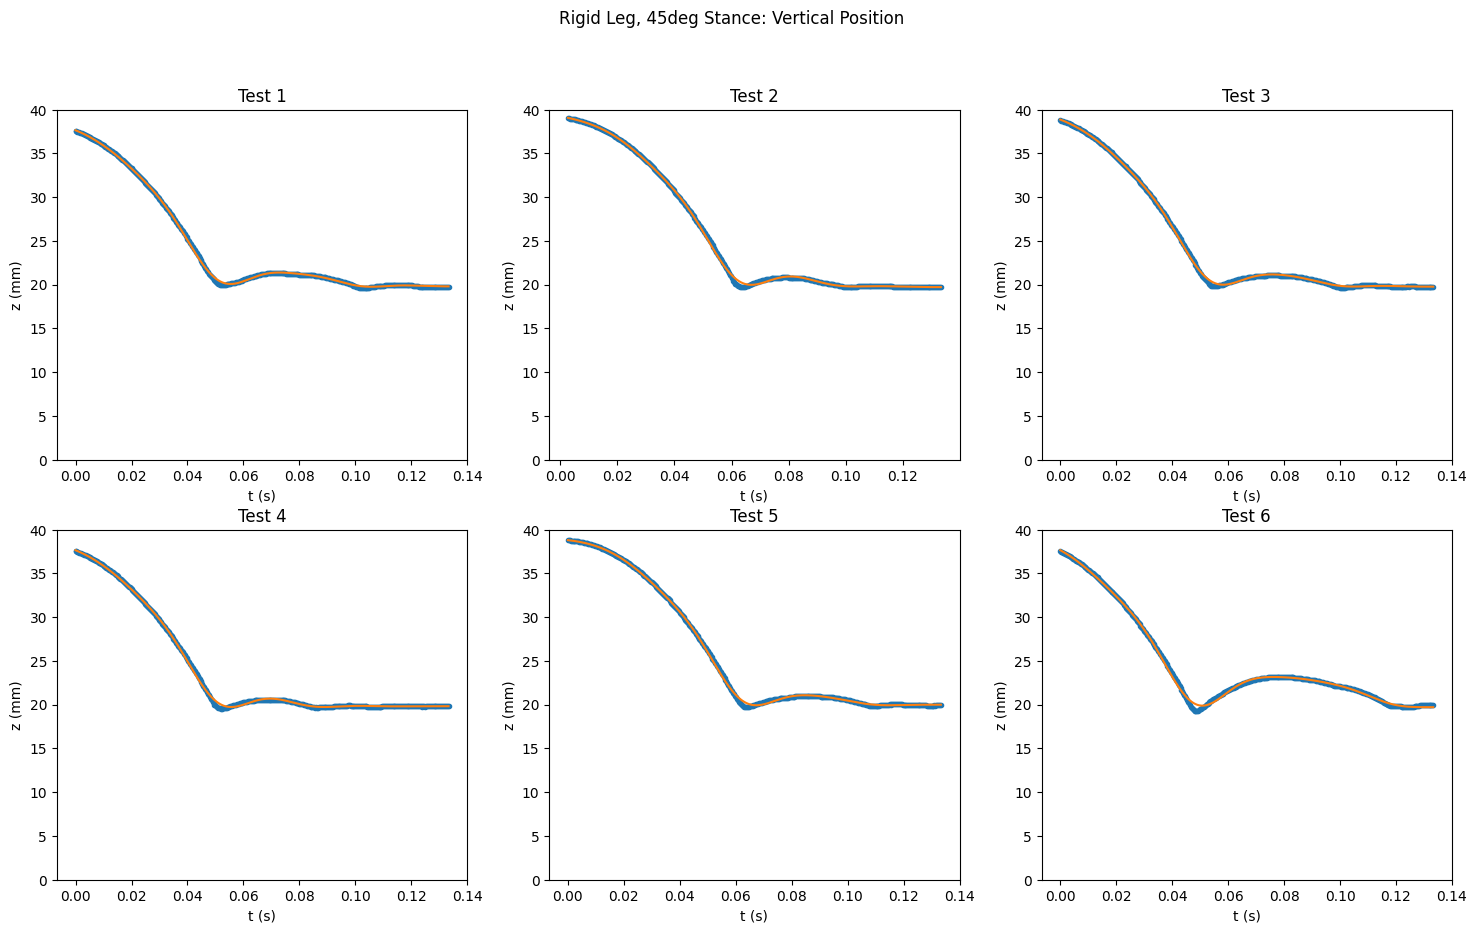

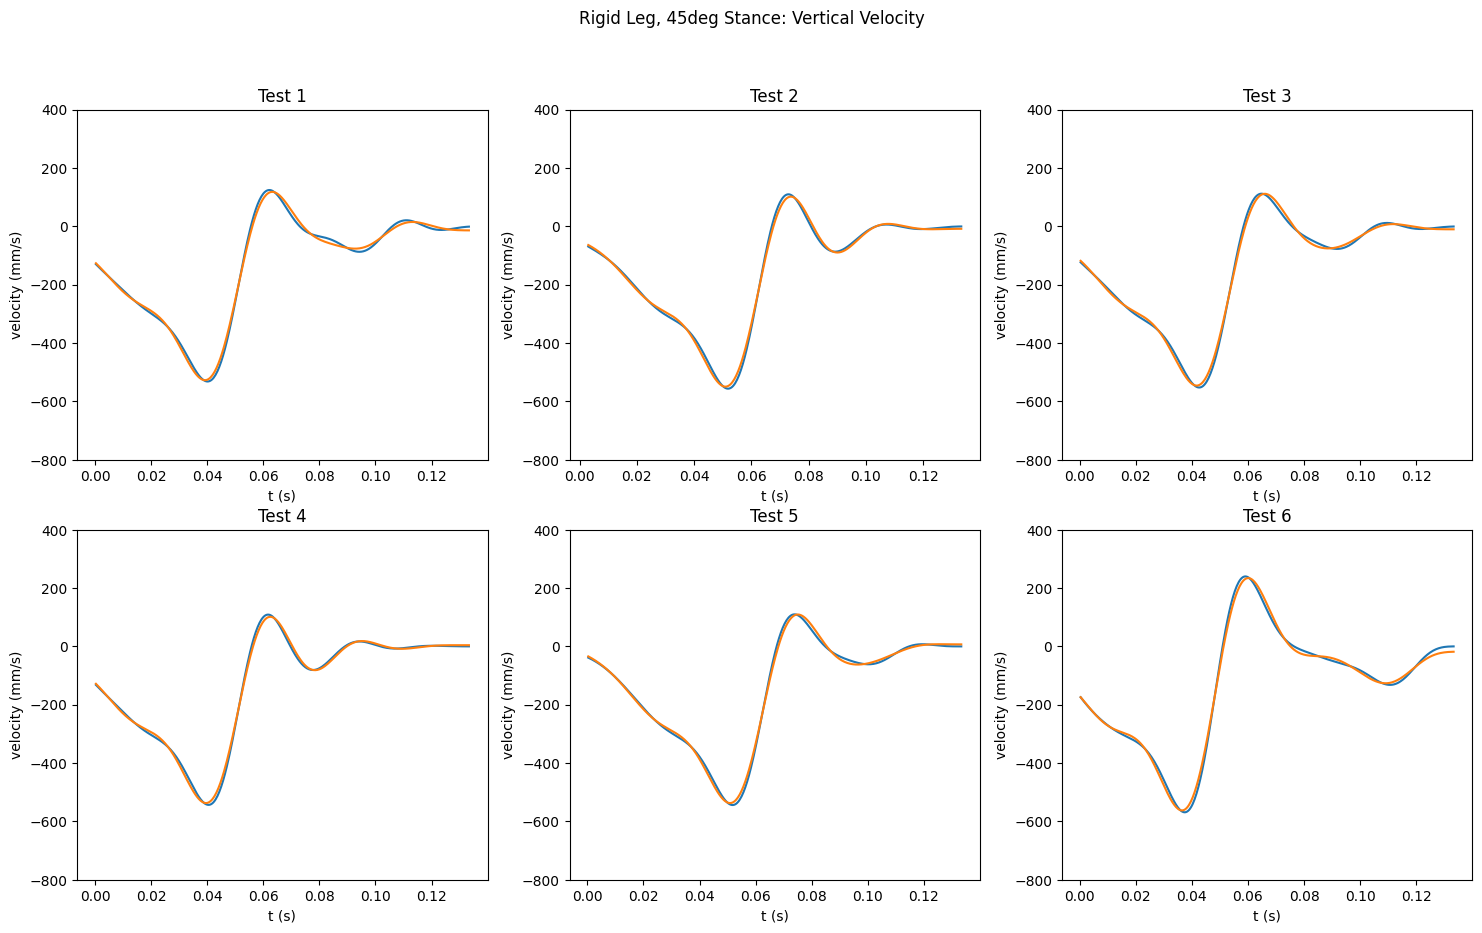

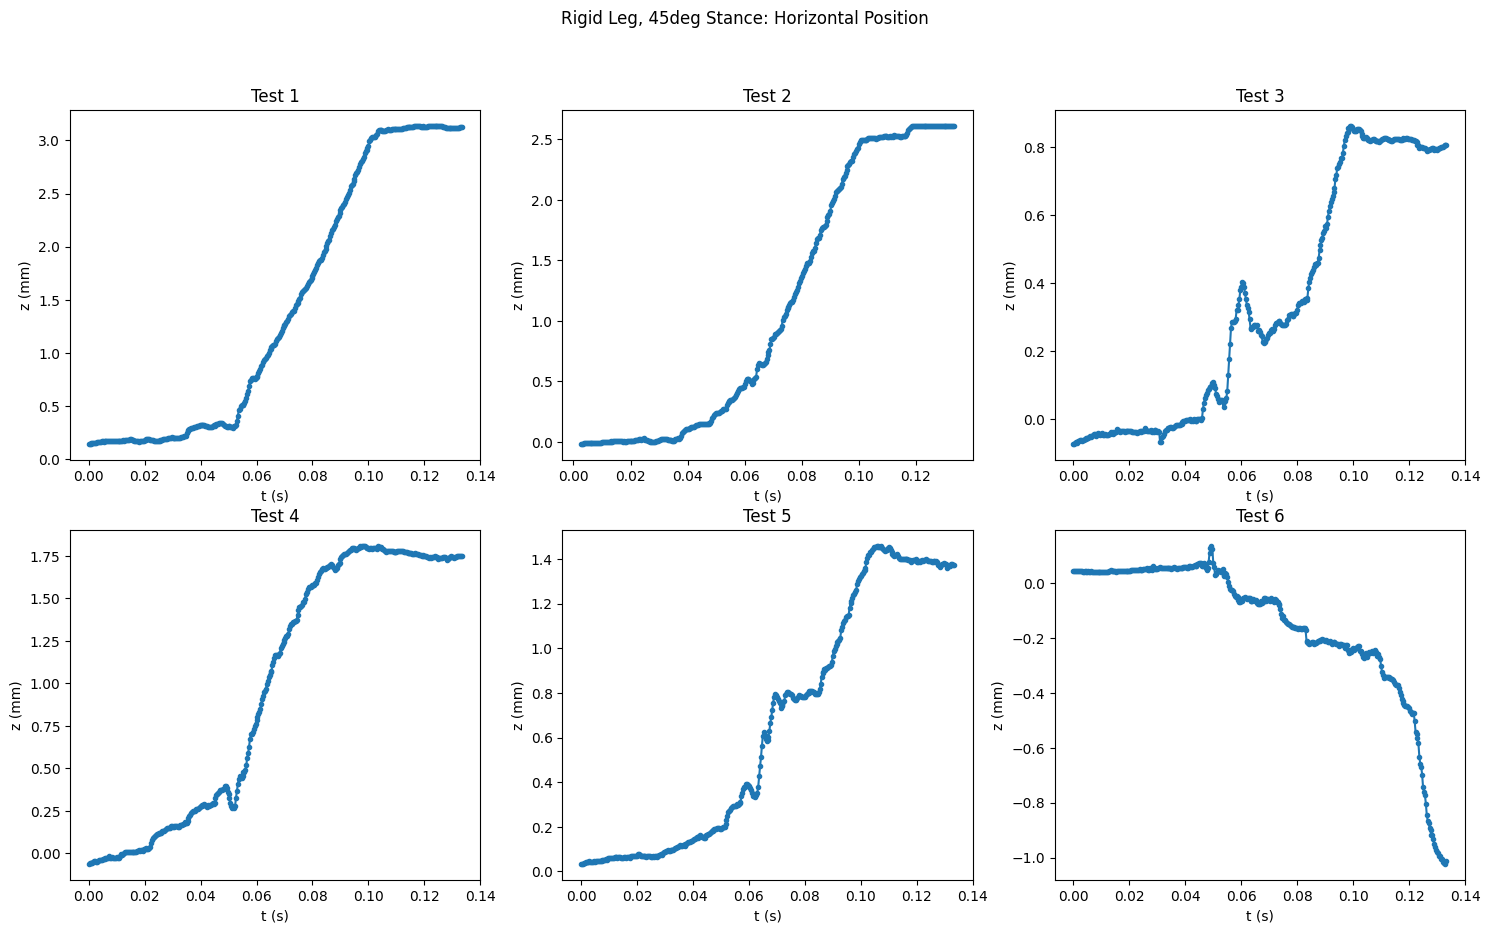

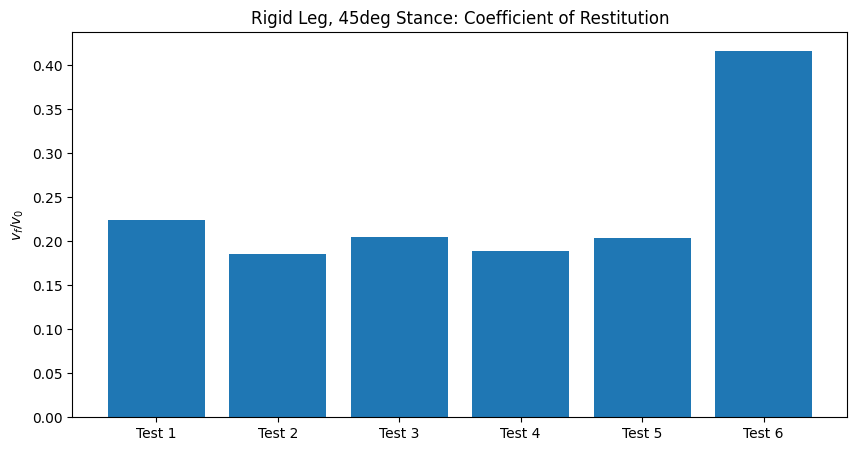

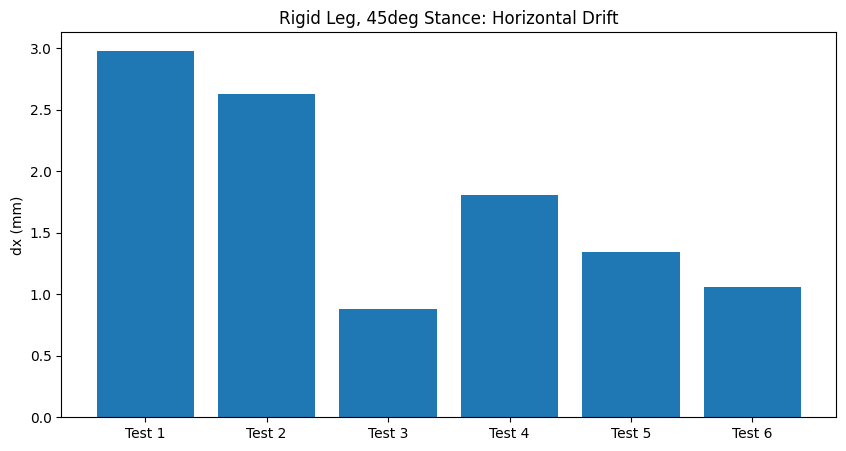

In [ ]:
leg_type = "Rigid Leg"
leg_name = "45deg Stance"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test6_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test1_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/Rigid Leg/60deg Stance/rigid_60deg_test5_3000fps_400frames_success.txt
video_fps: 3

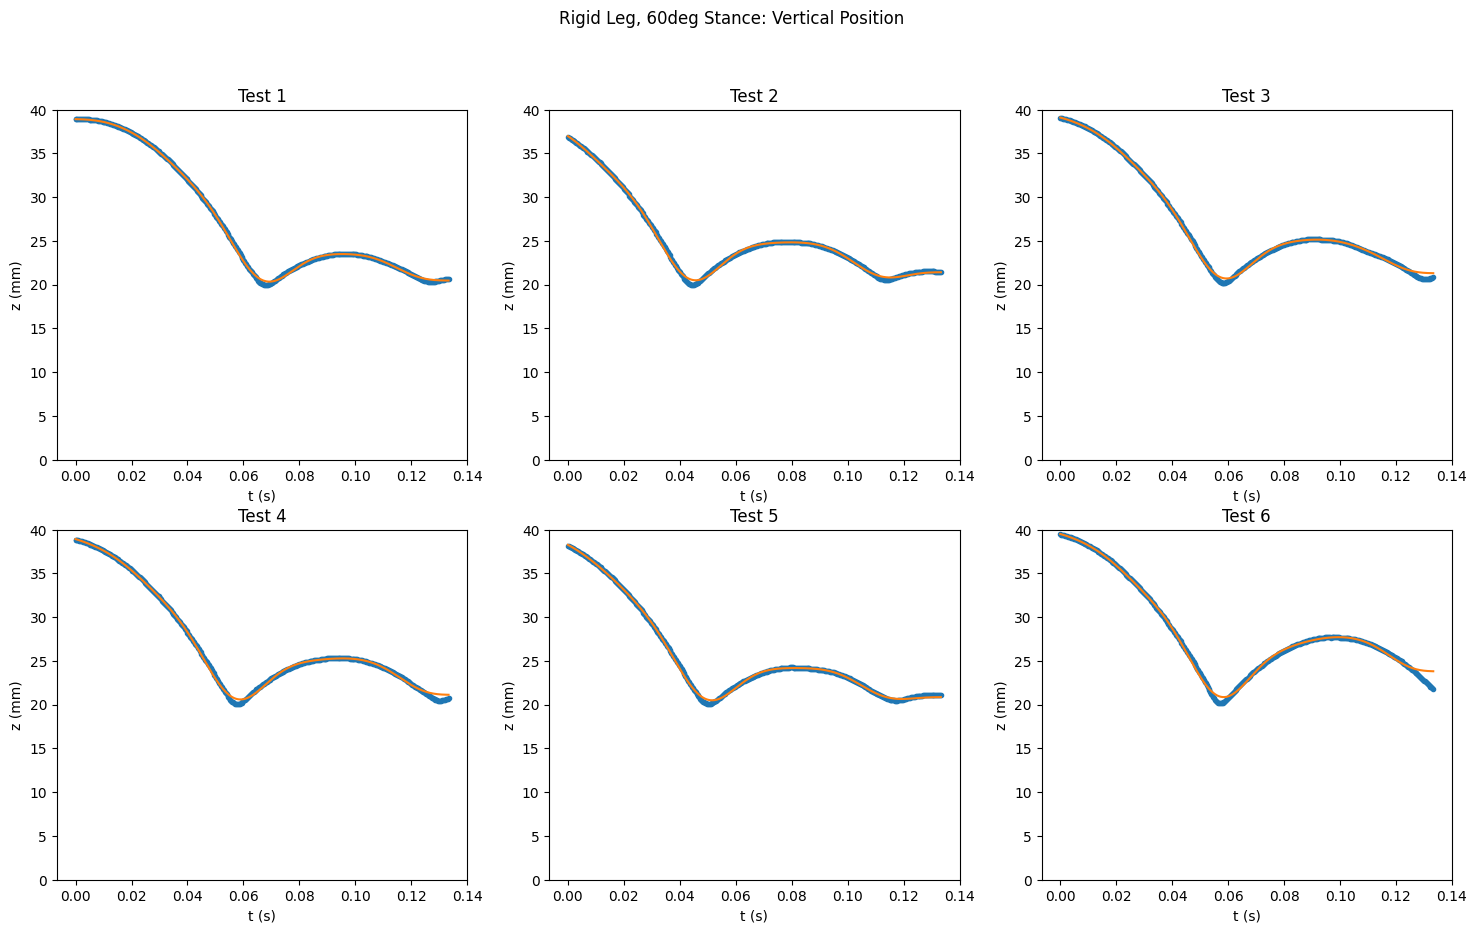

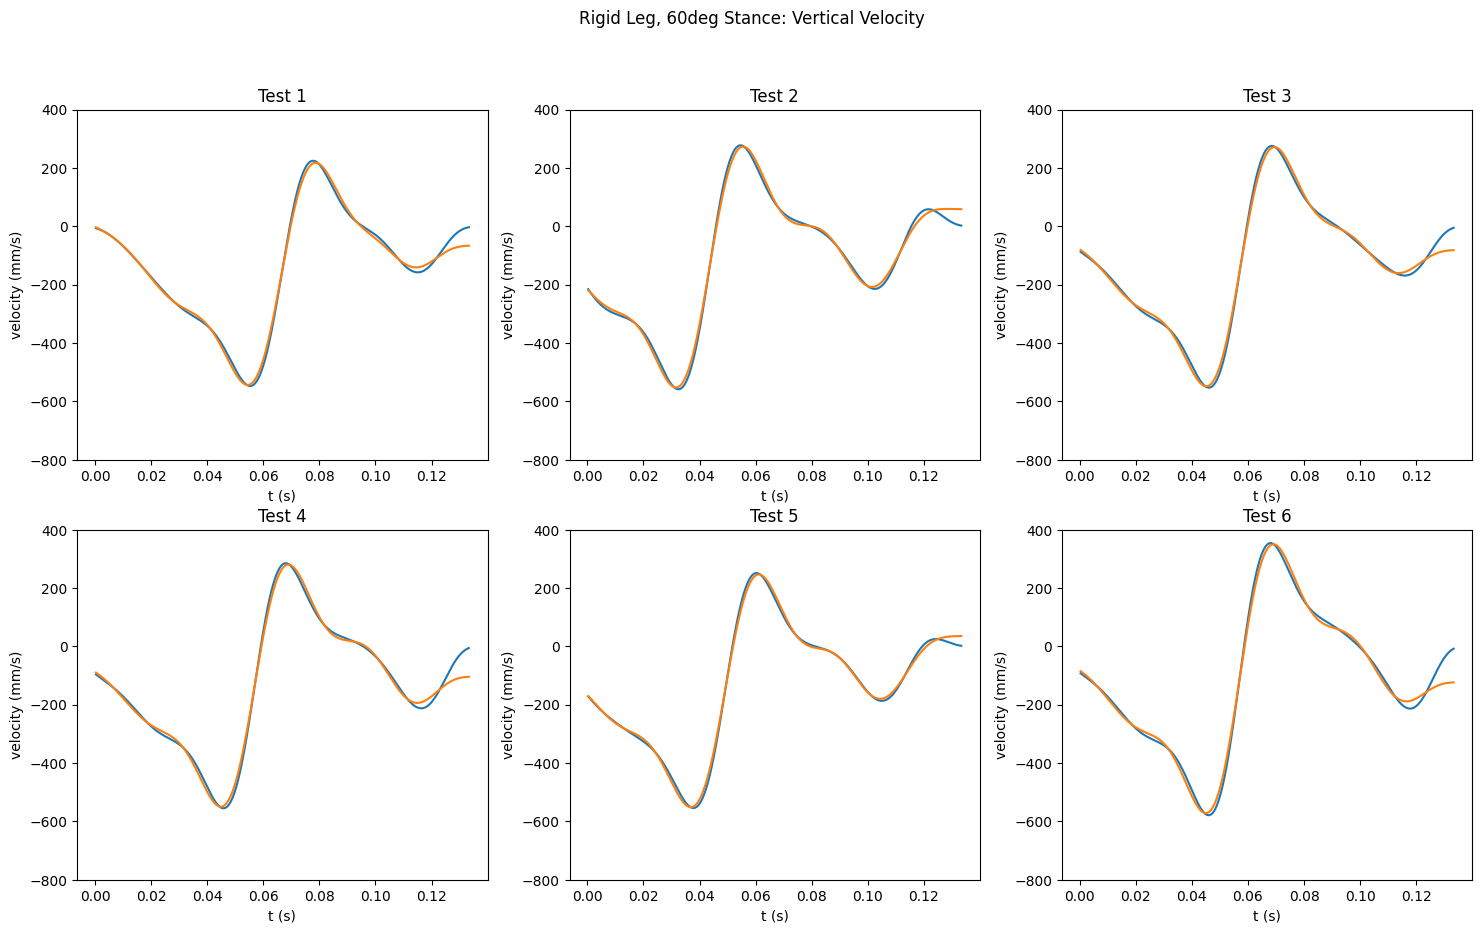

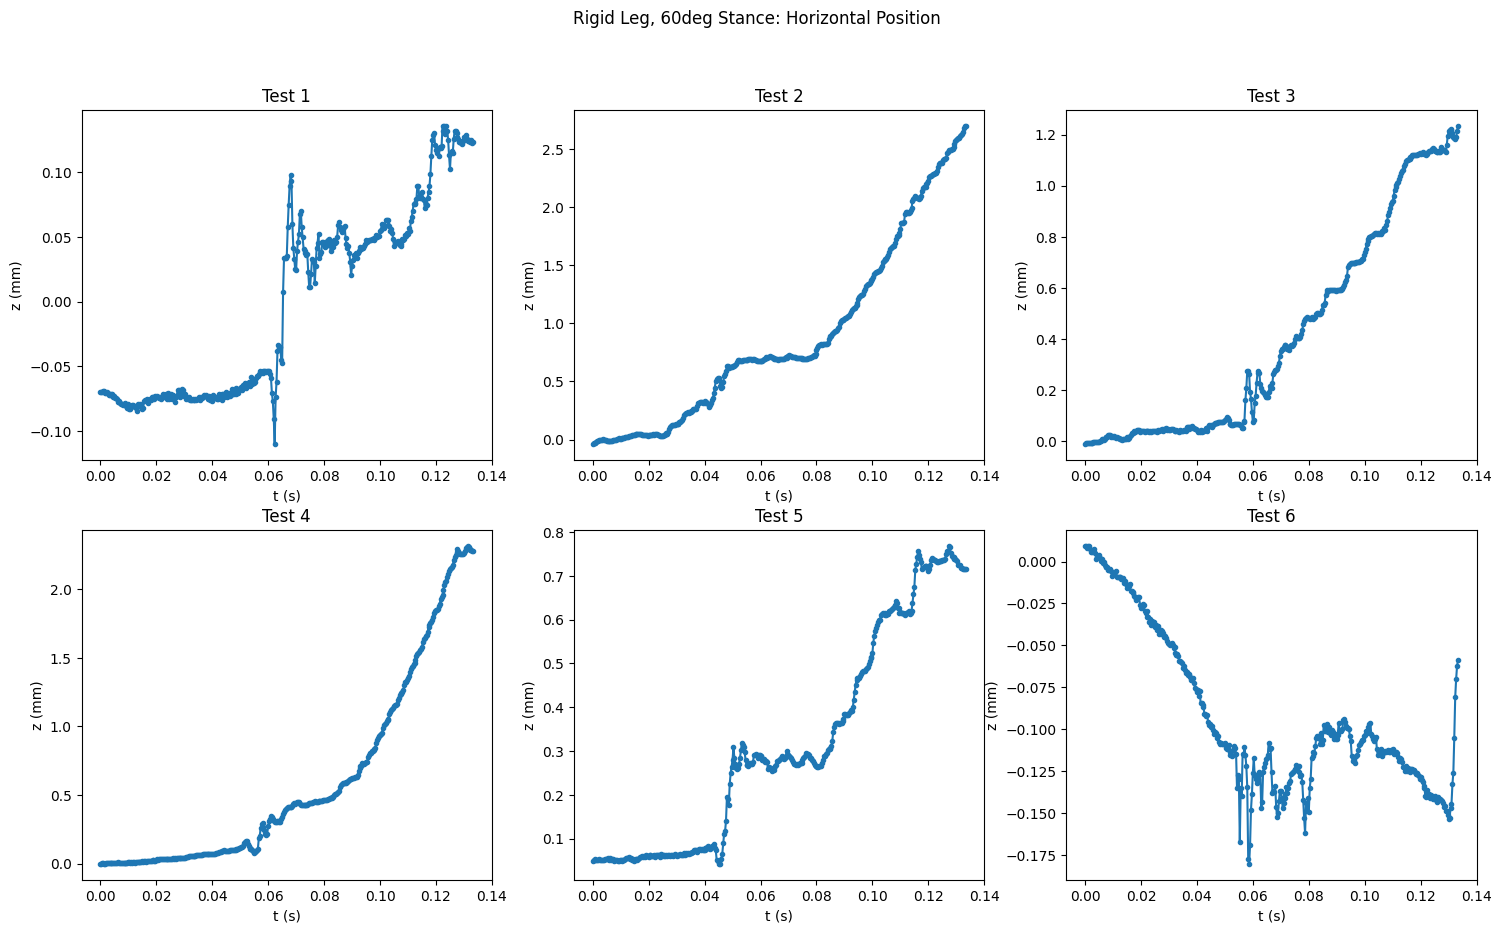

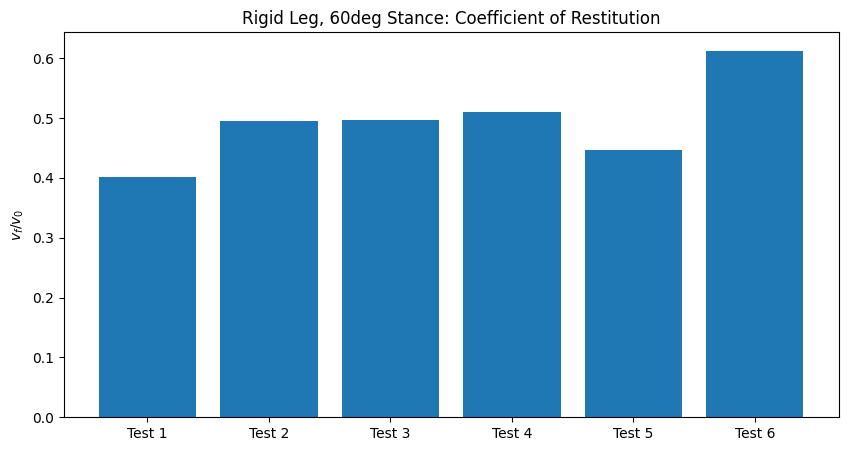

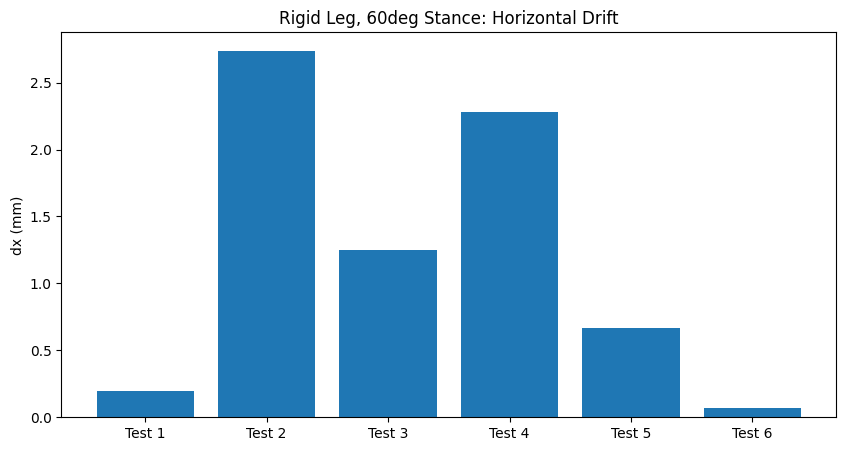

In [ ]:
leg_type = "Rigid Leg"
leg_name = "60deg Stance"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test3_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/1joint_25um_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Join

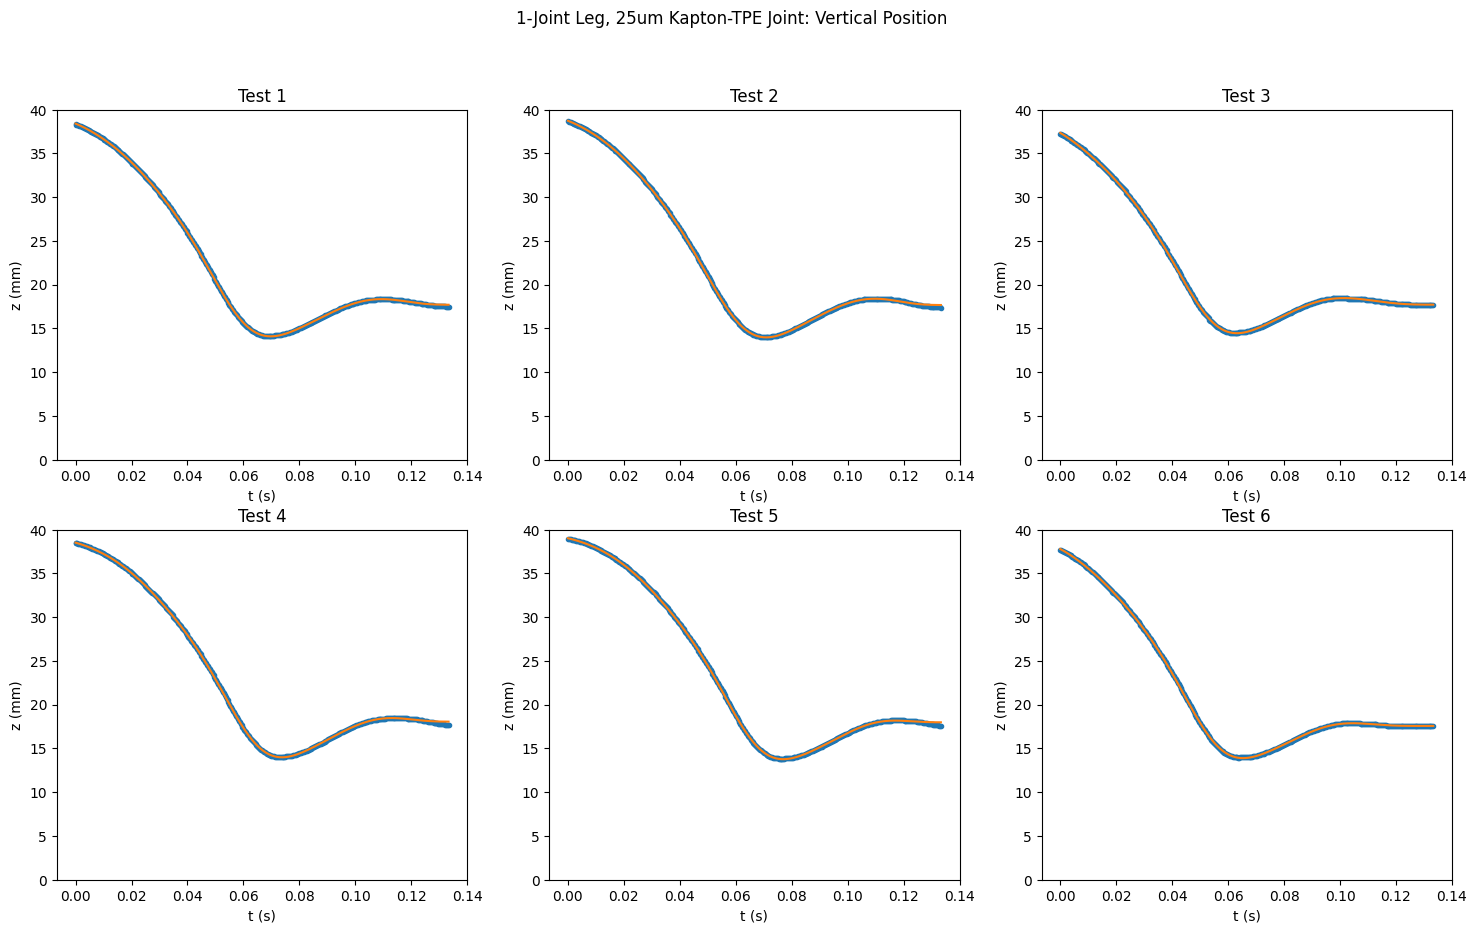

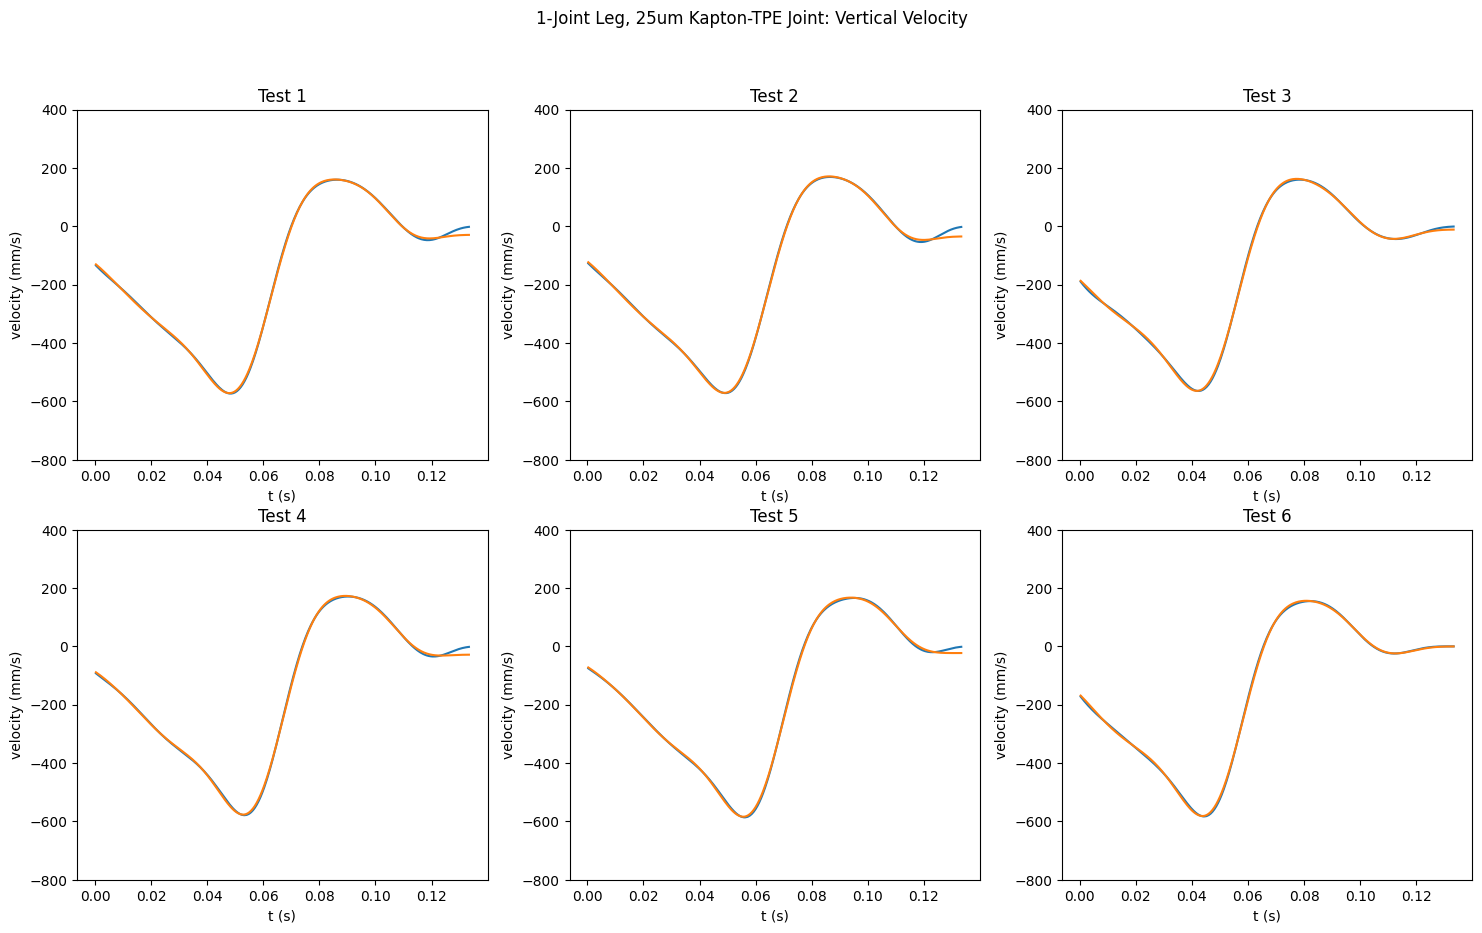

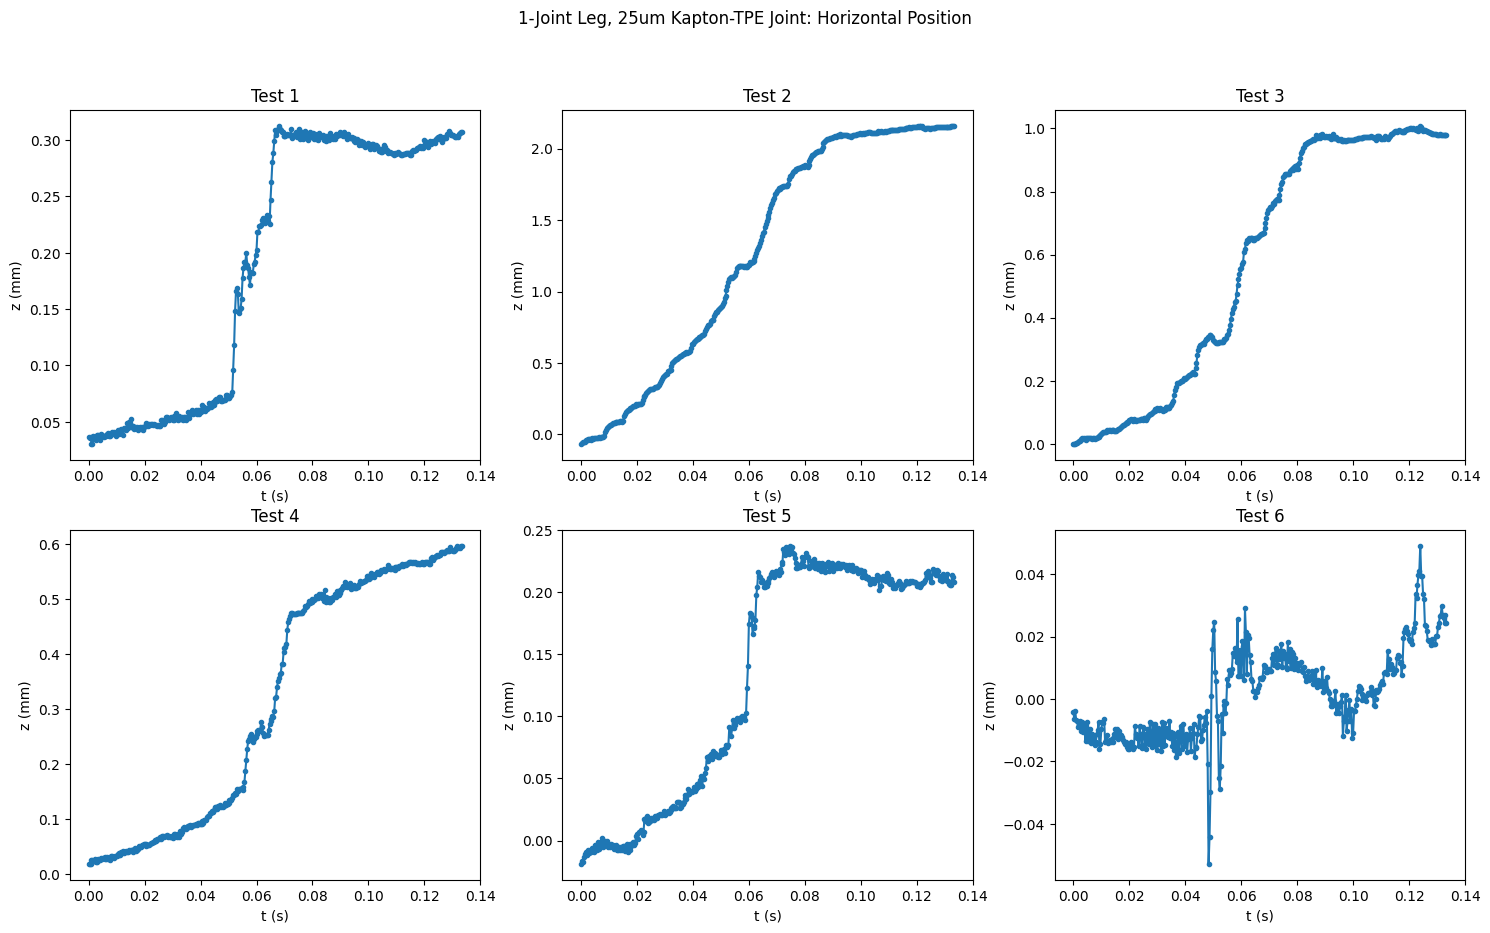

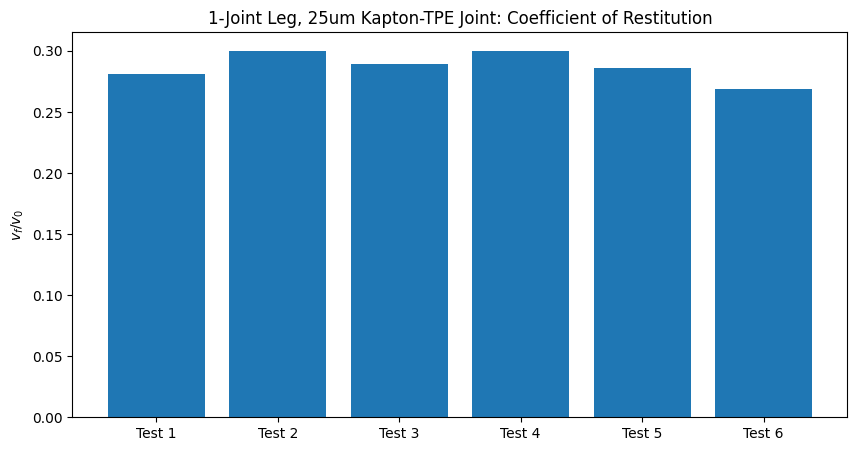

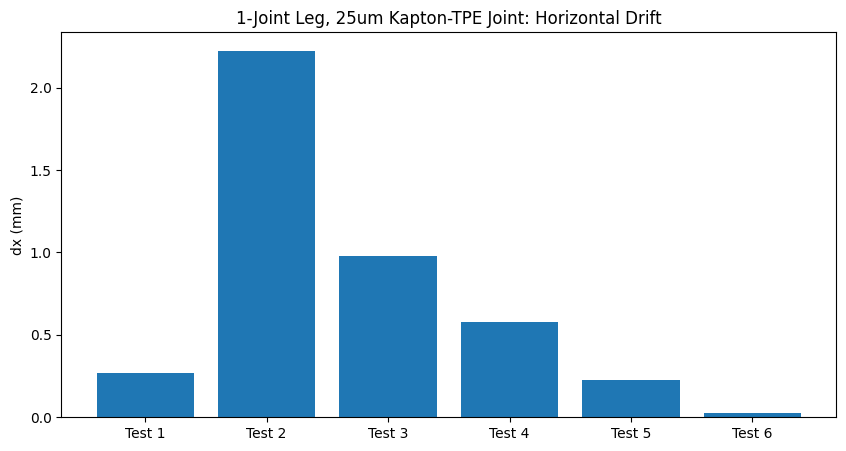

In [ ]:
leg_type = "1-Joint Leg"
leg_name = "25um Kapton-TPE Joint"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test5_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/1joint_50um_45deg_test3_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Join

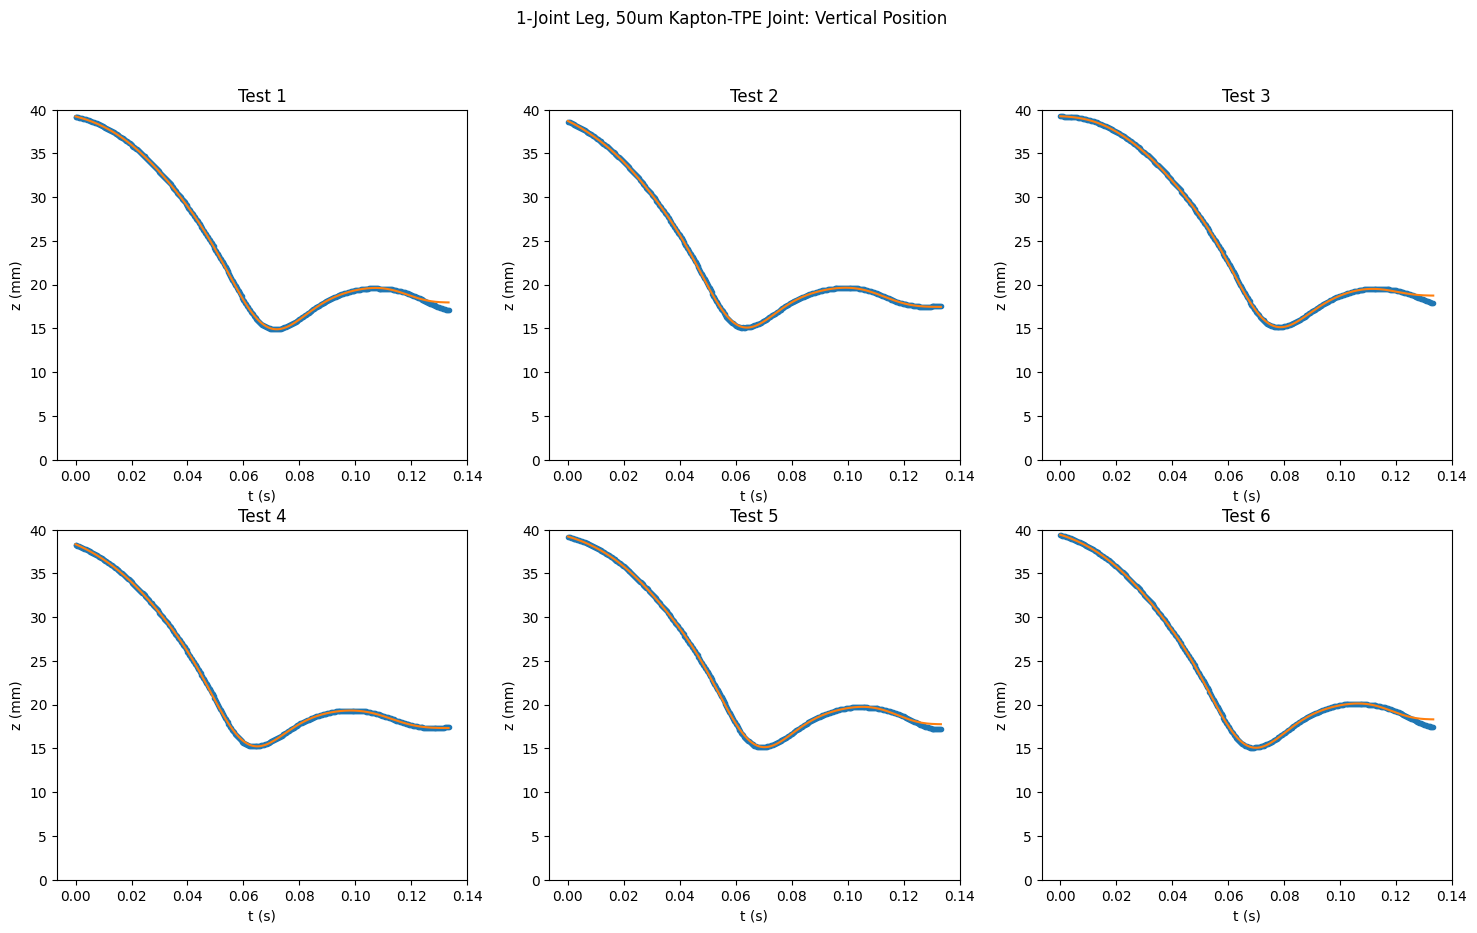

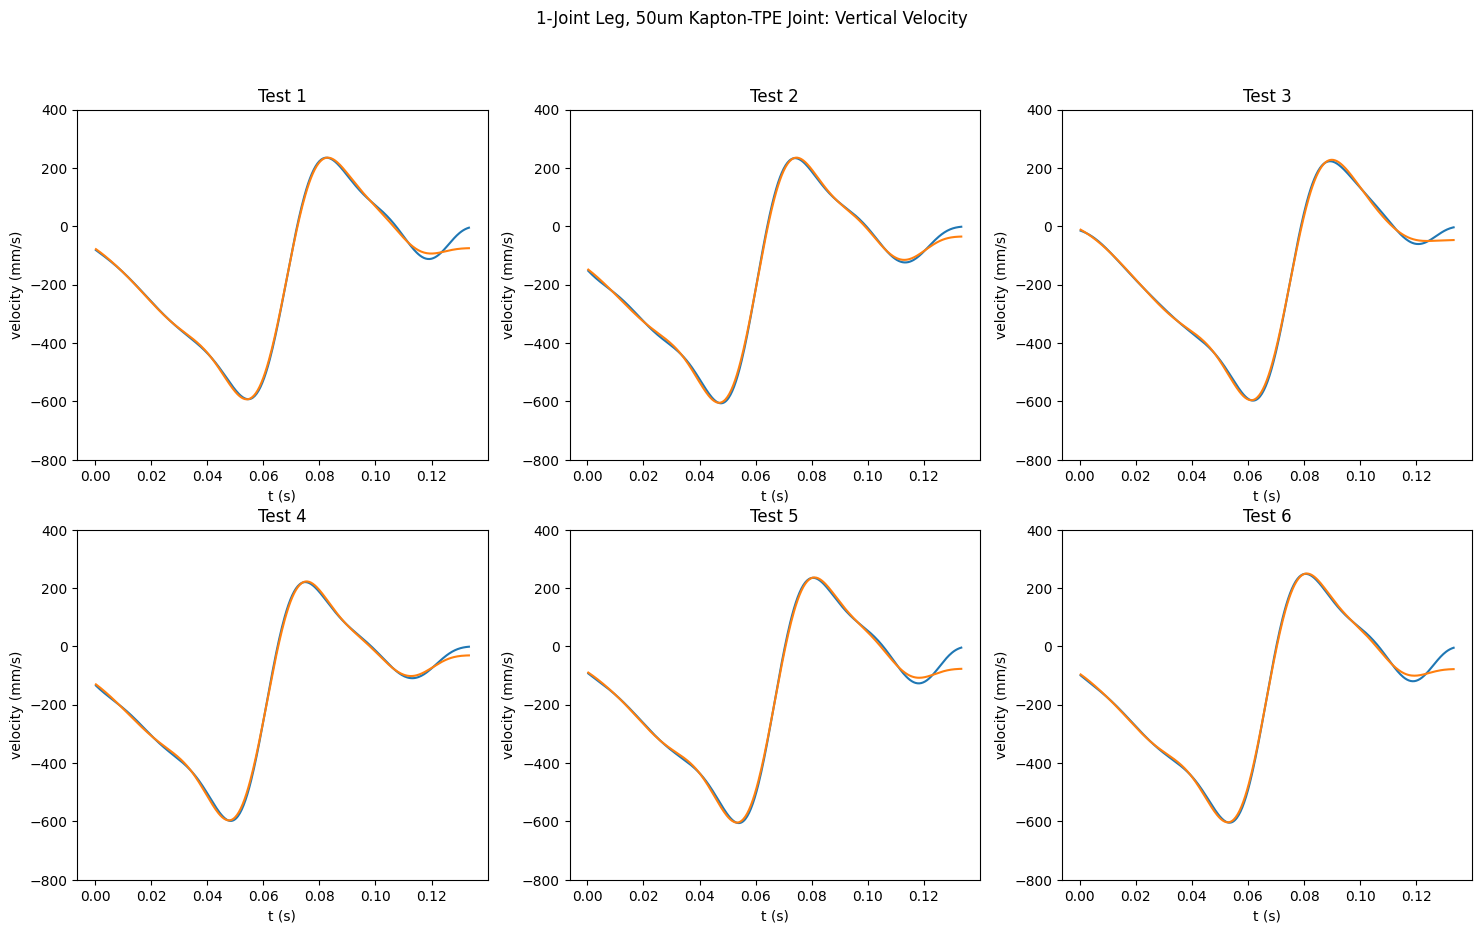

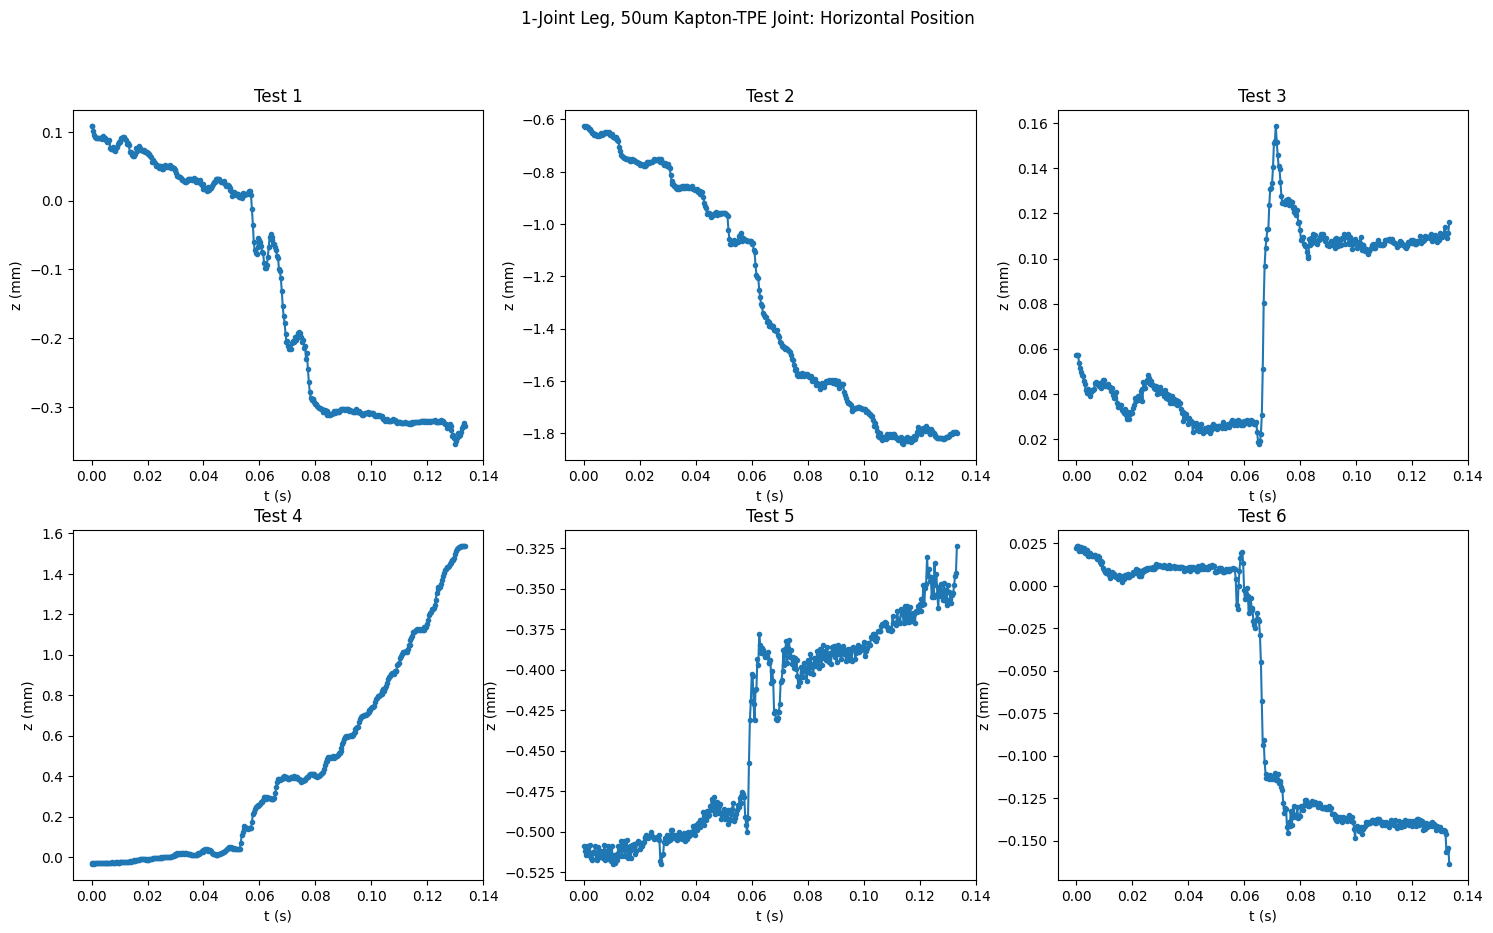

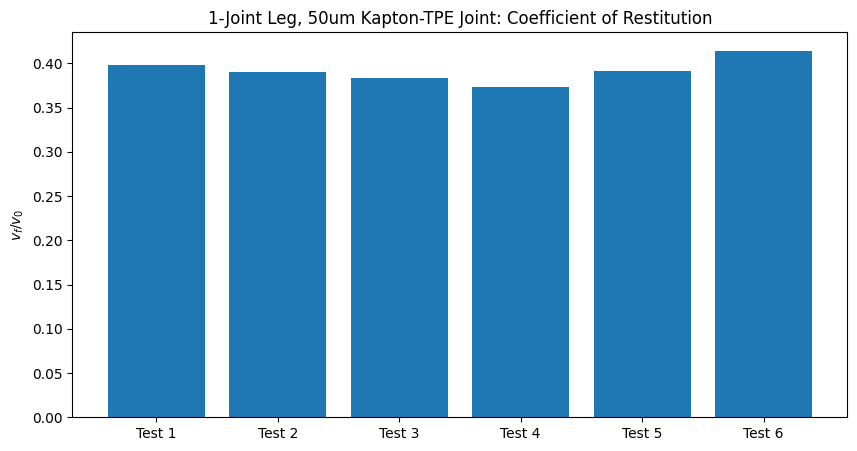

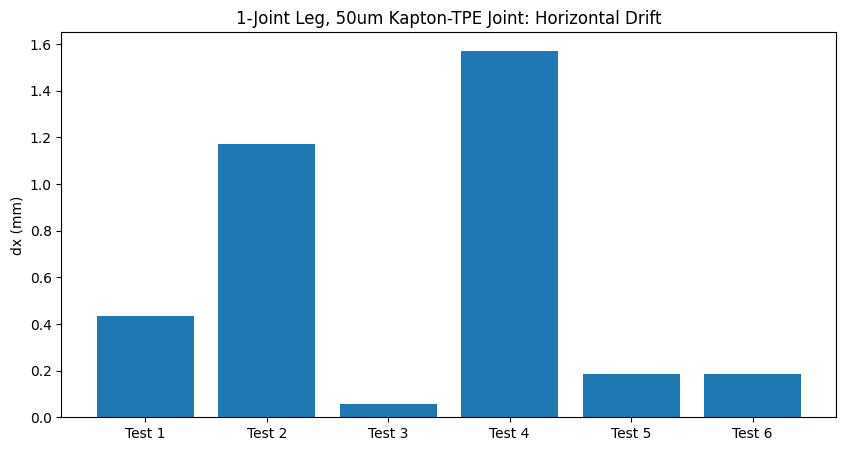

In [ ]:
leg_type = "1-Joint Leg"
leg_name = "50um Kapton-TPE Joint"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test3_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-0um_40-60_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scri

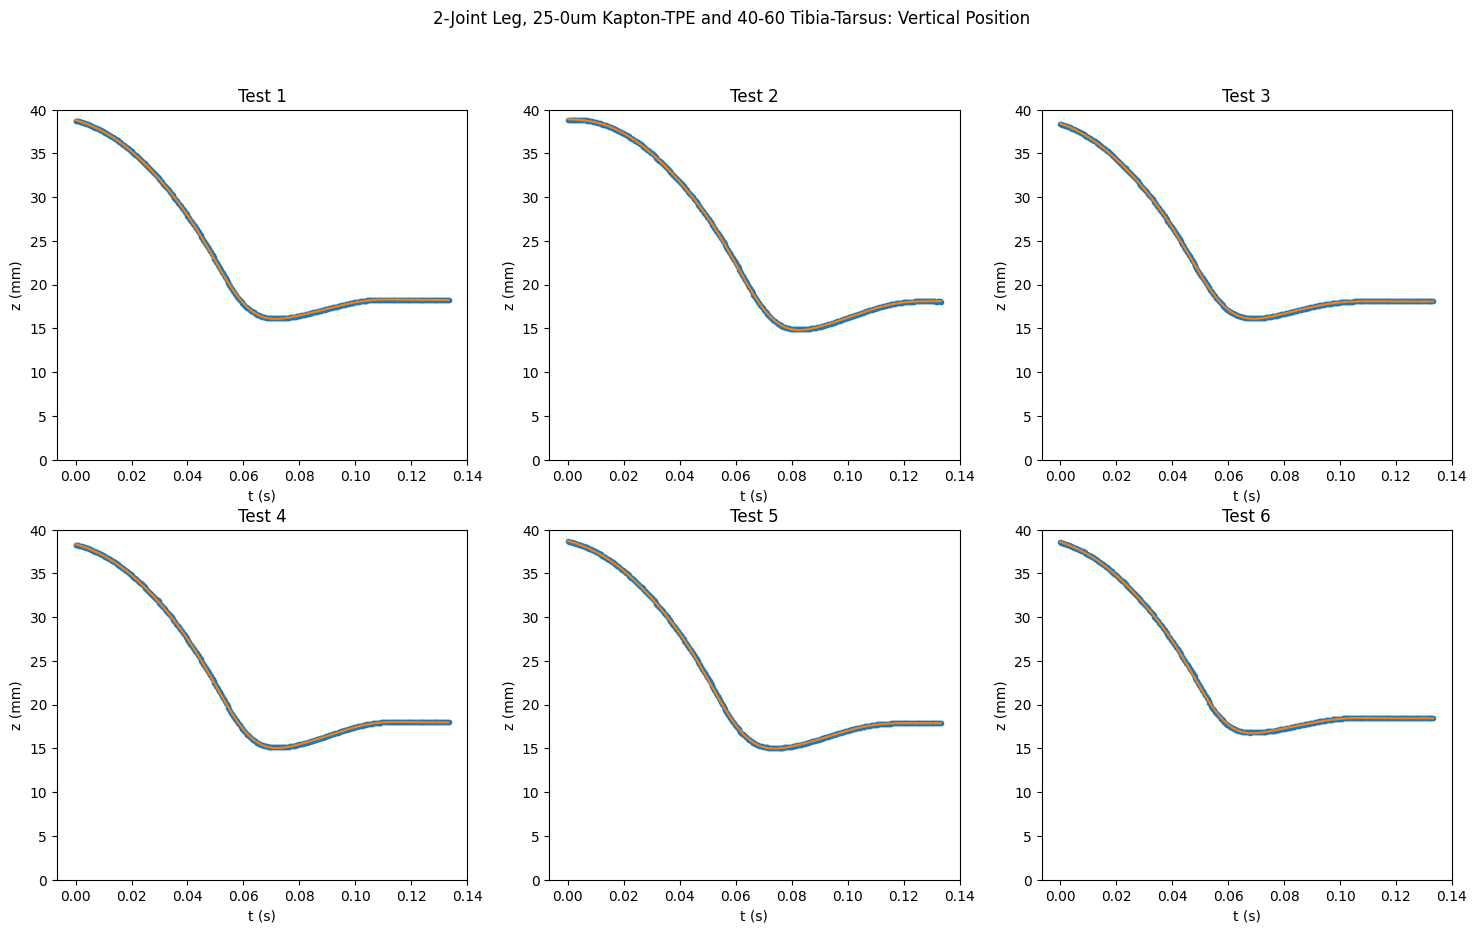

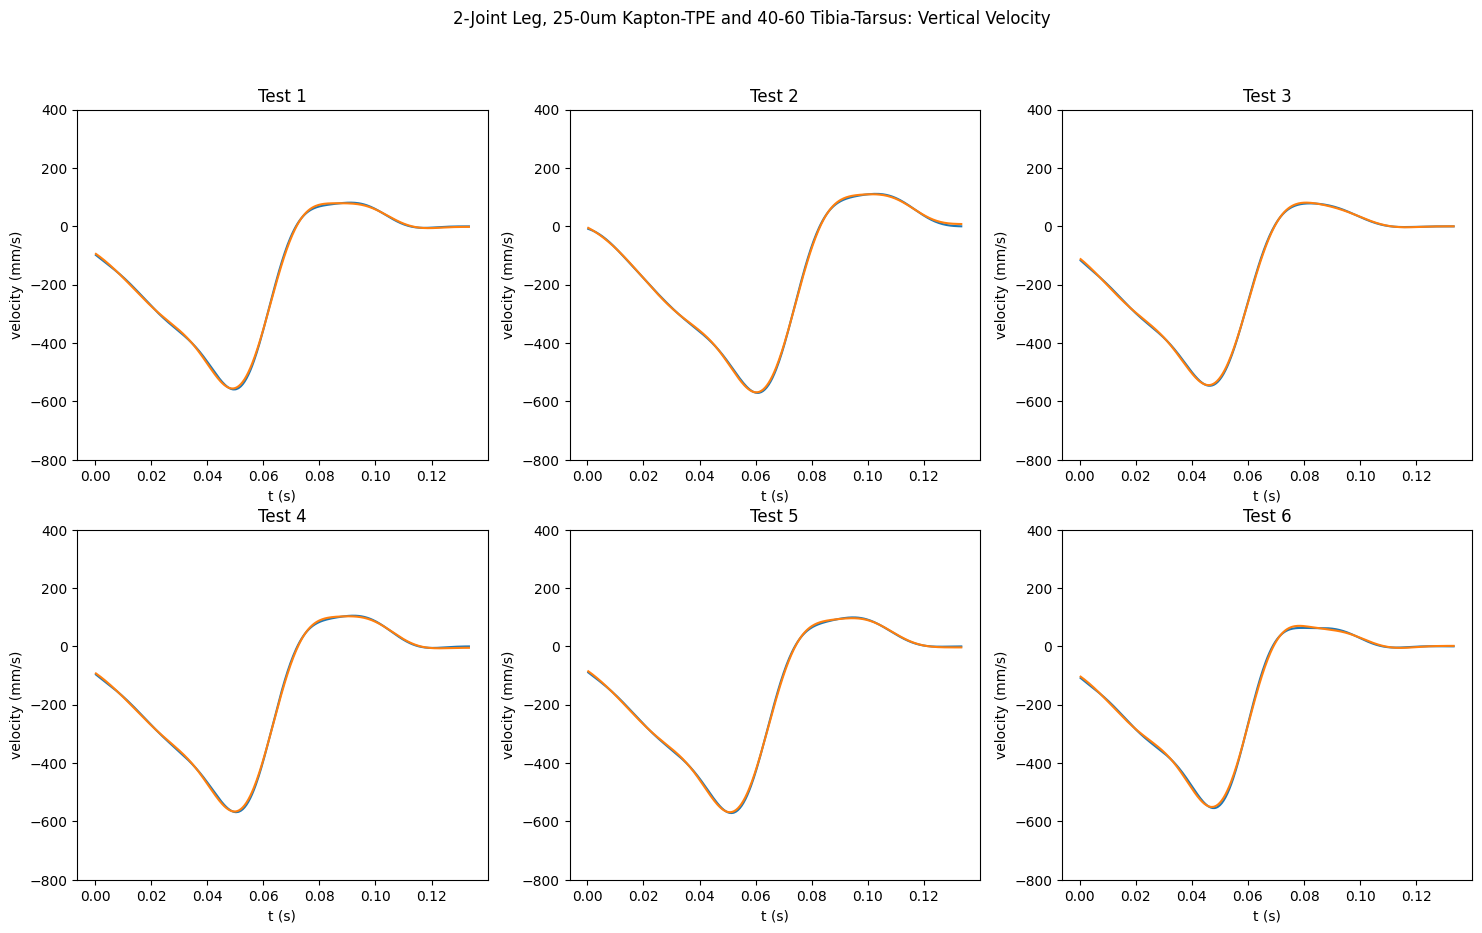

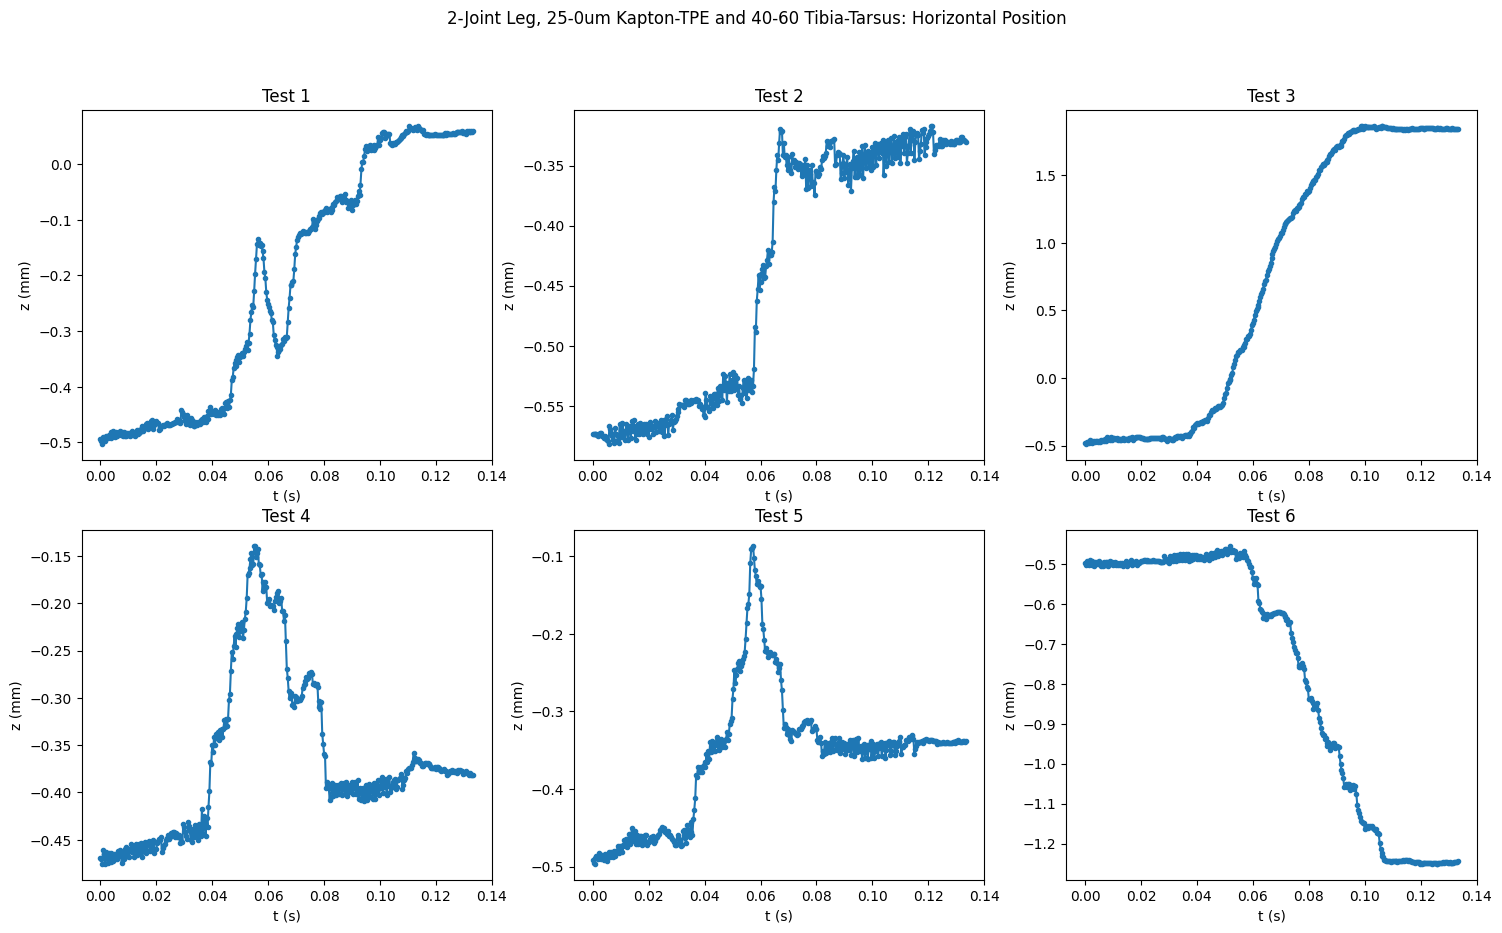

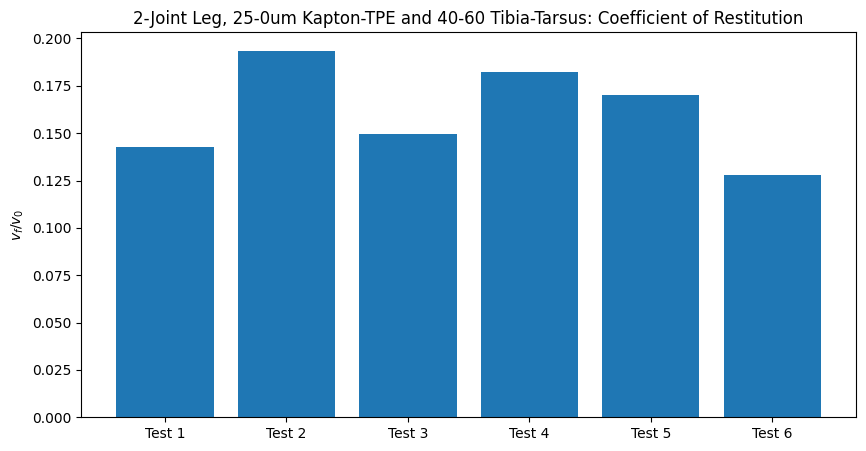

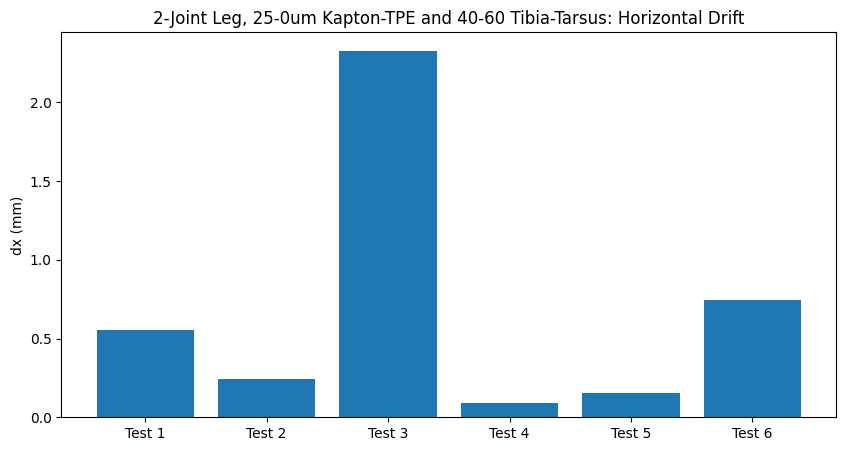

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-0um Kapton-TPE and 40-60 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test5_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-0um_60-40_45deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scri

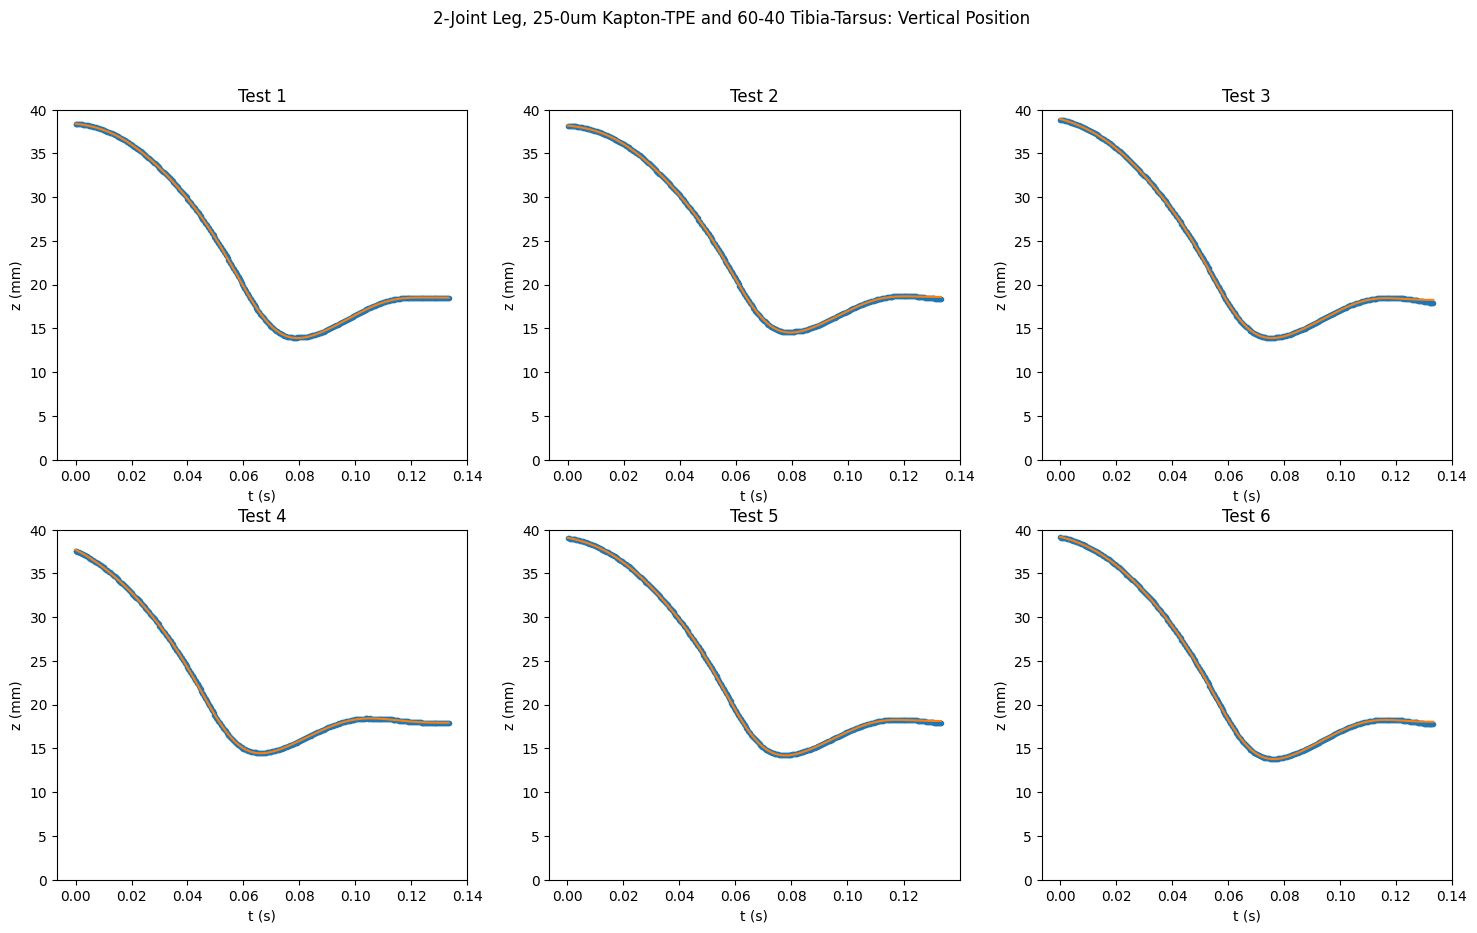

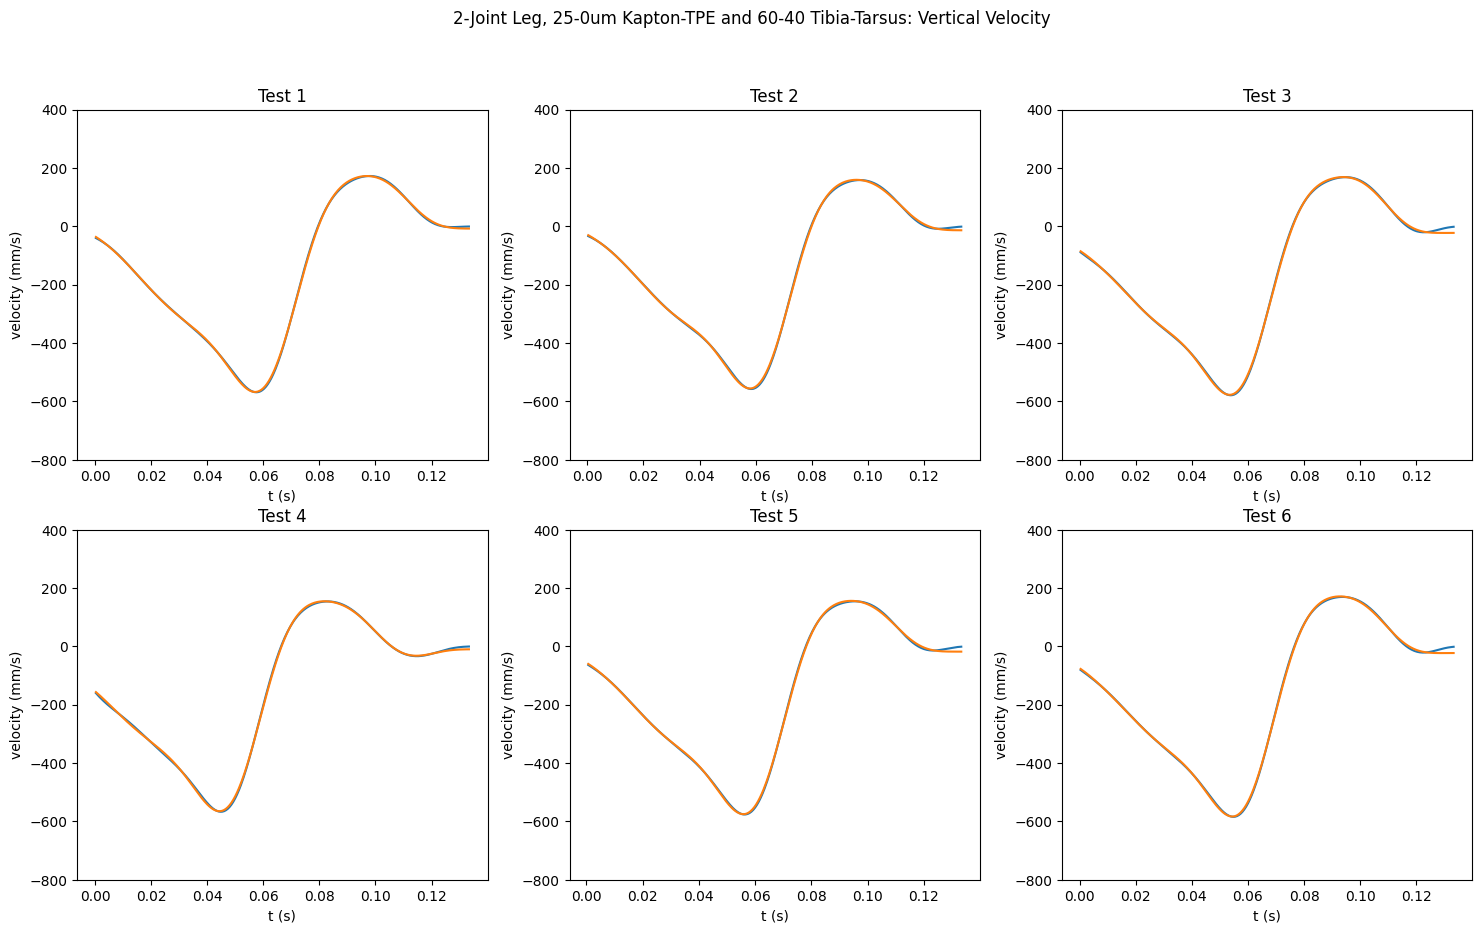

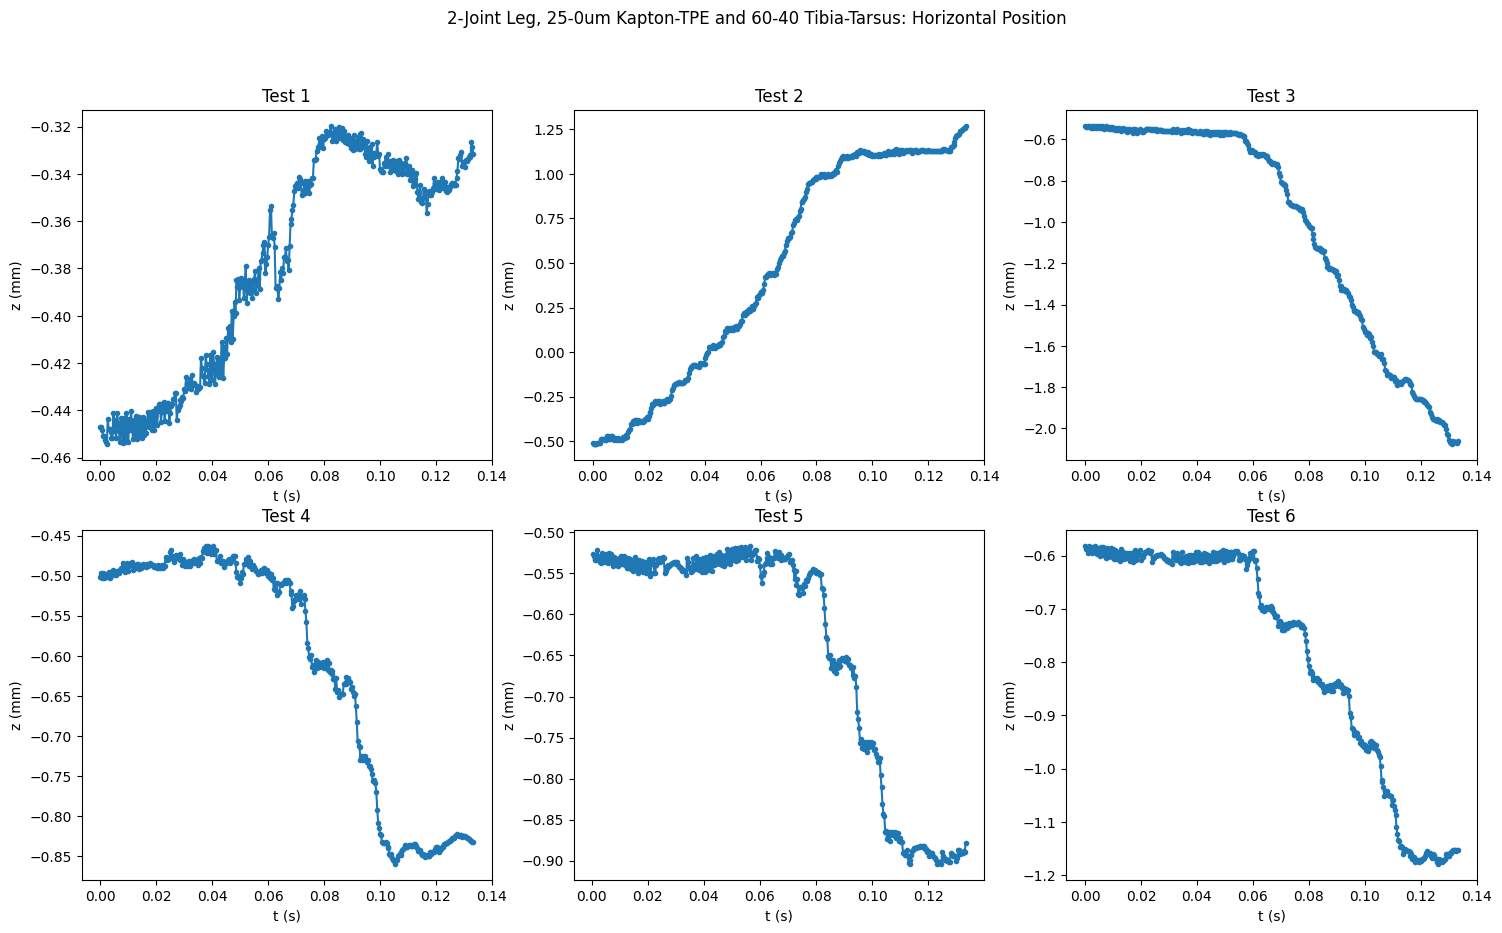

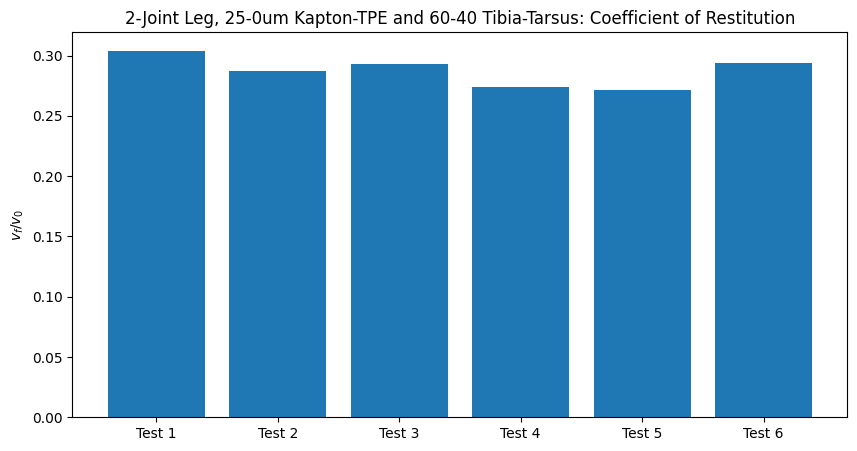

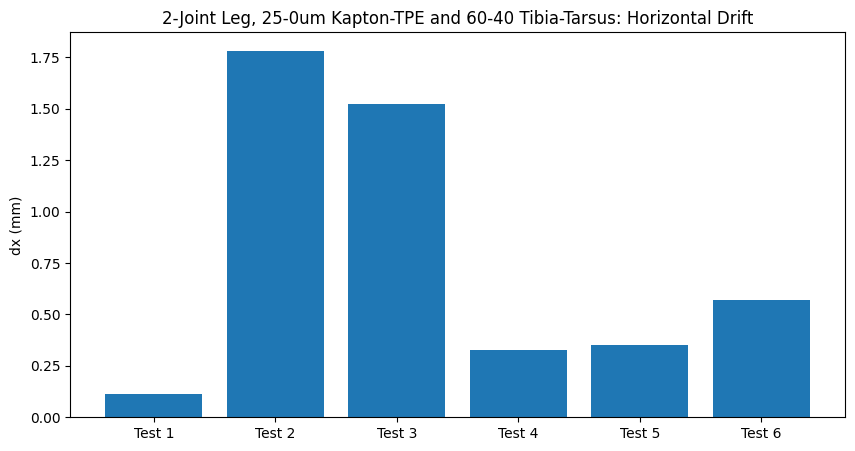

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-0um Kapton-TPE and 60-40 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test1_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test6_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-7-5um_40-60_45deg_test5_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg A

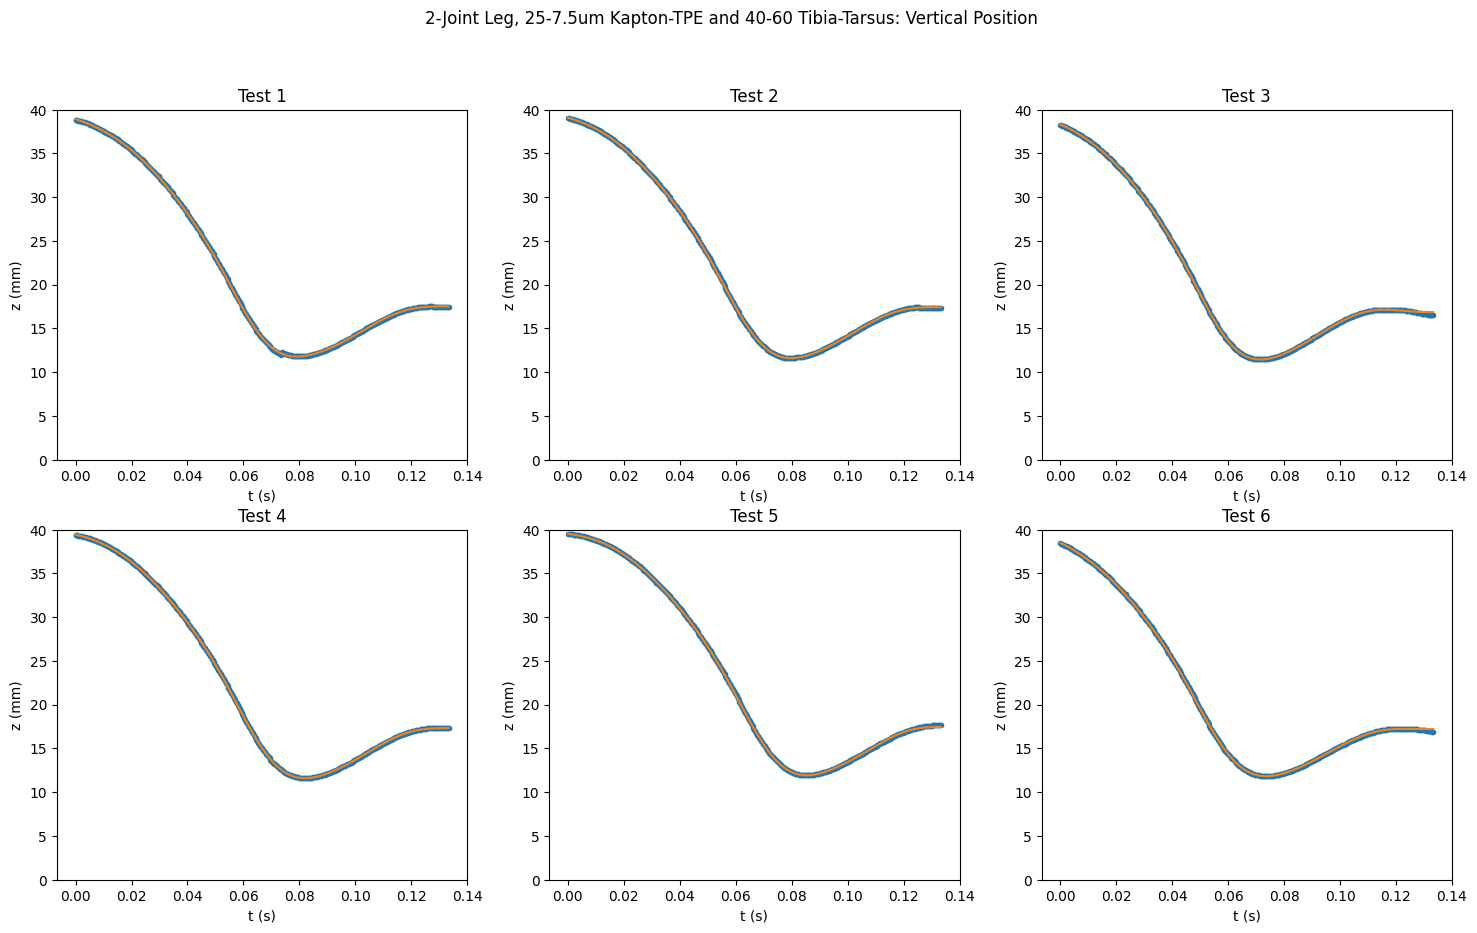

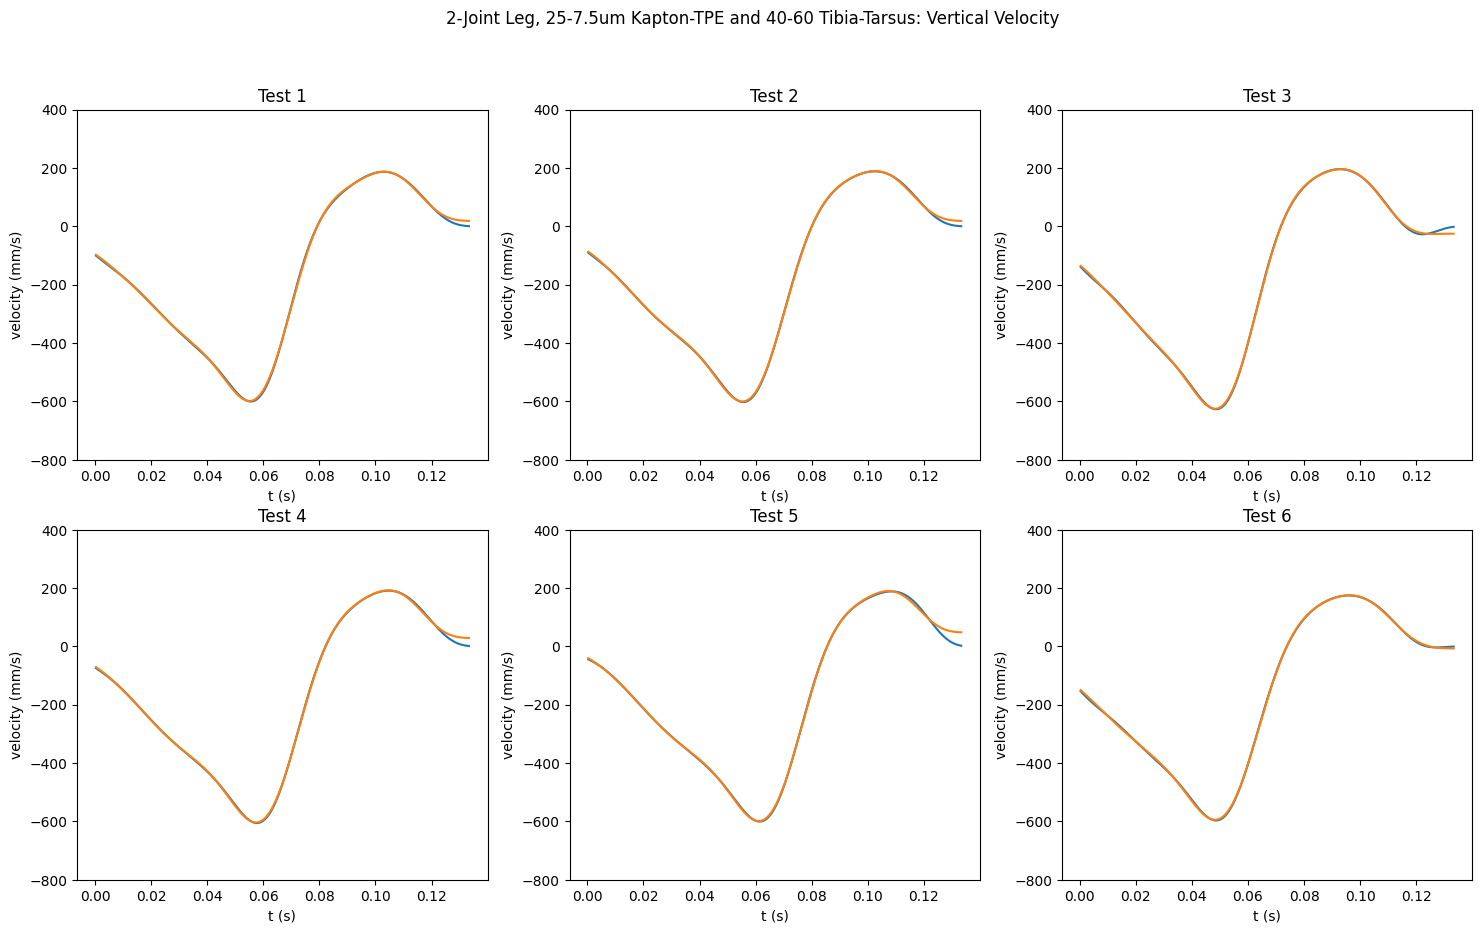

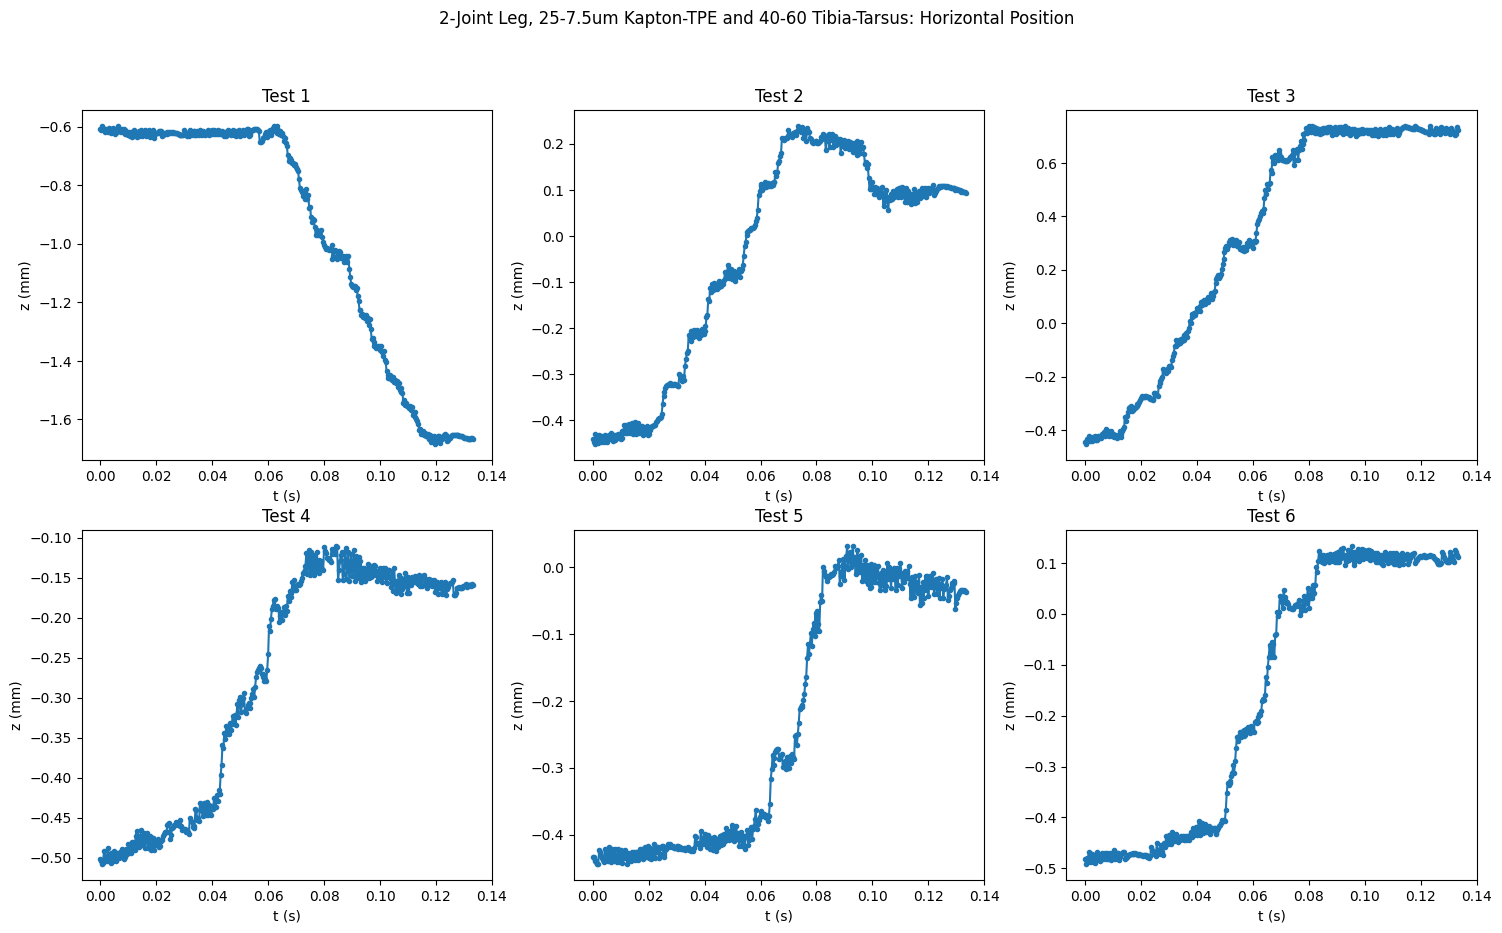

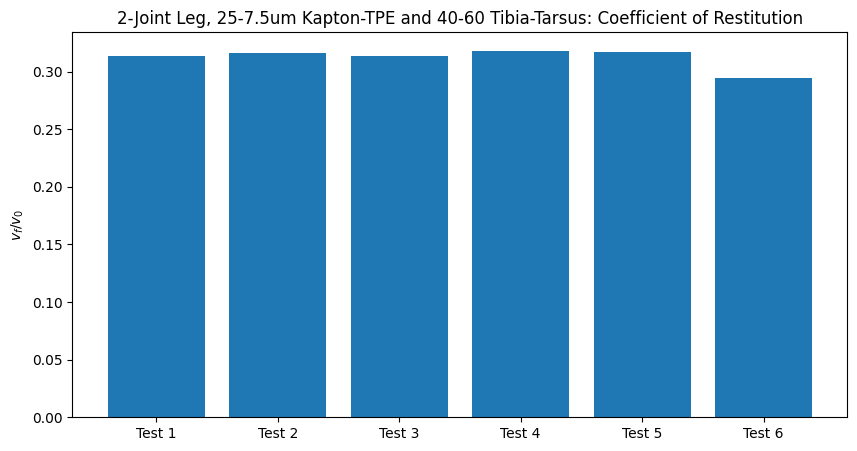

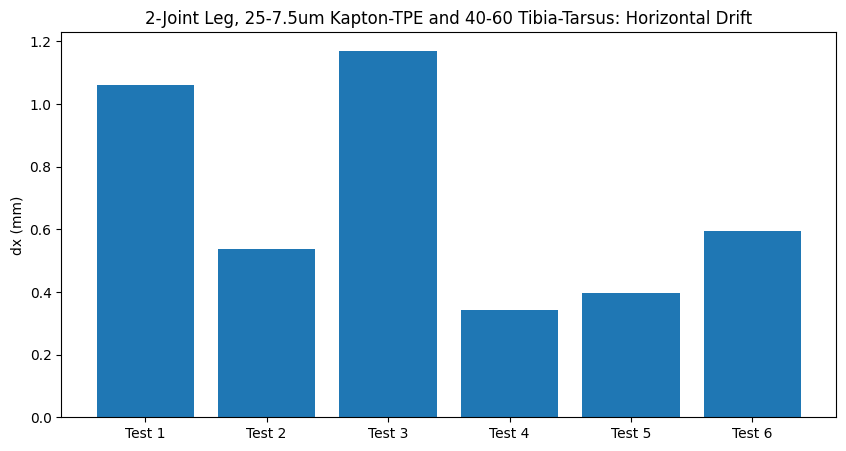

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test6_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test1_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-7-5um_60-40_45deg_test3_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg A

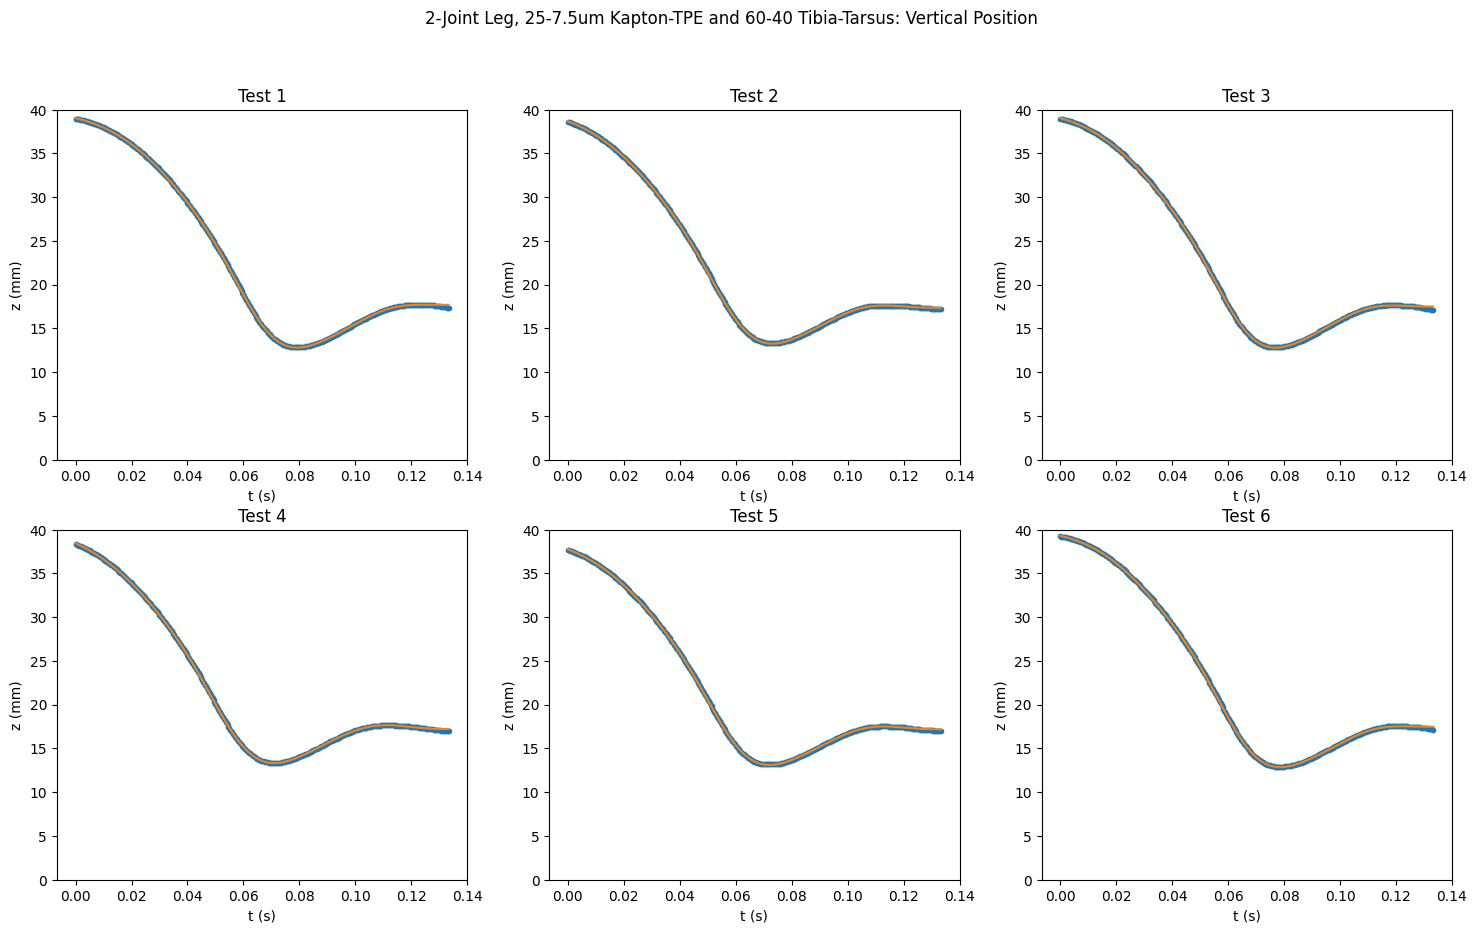

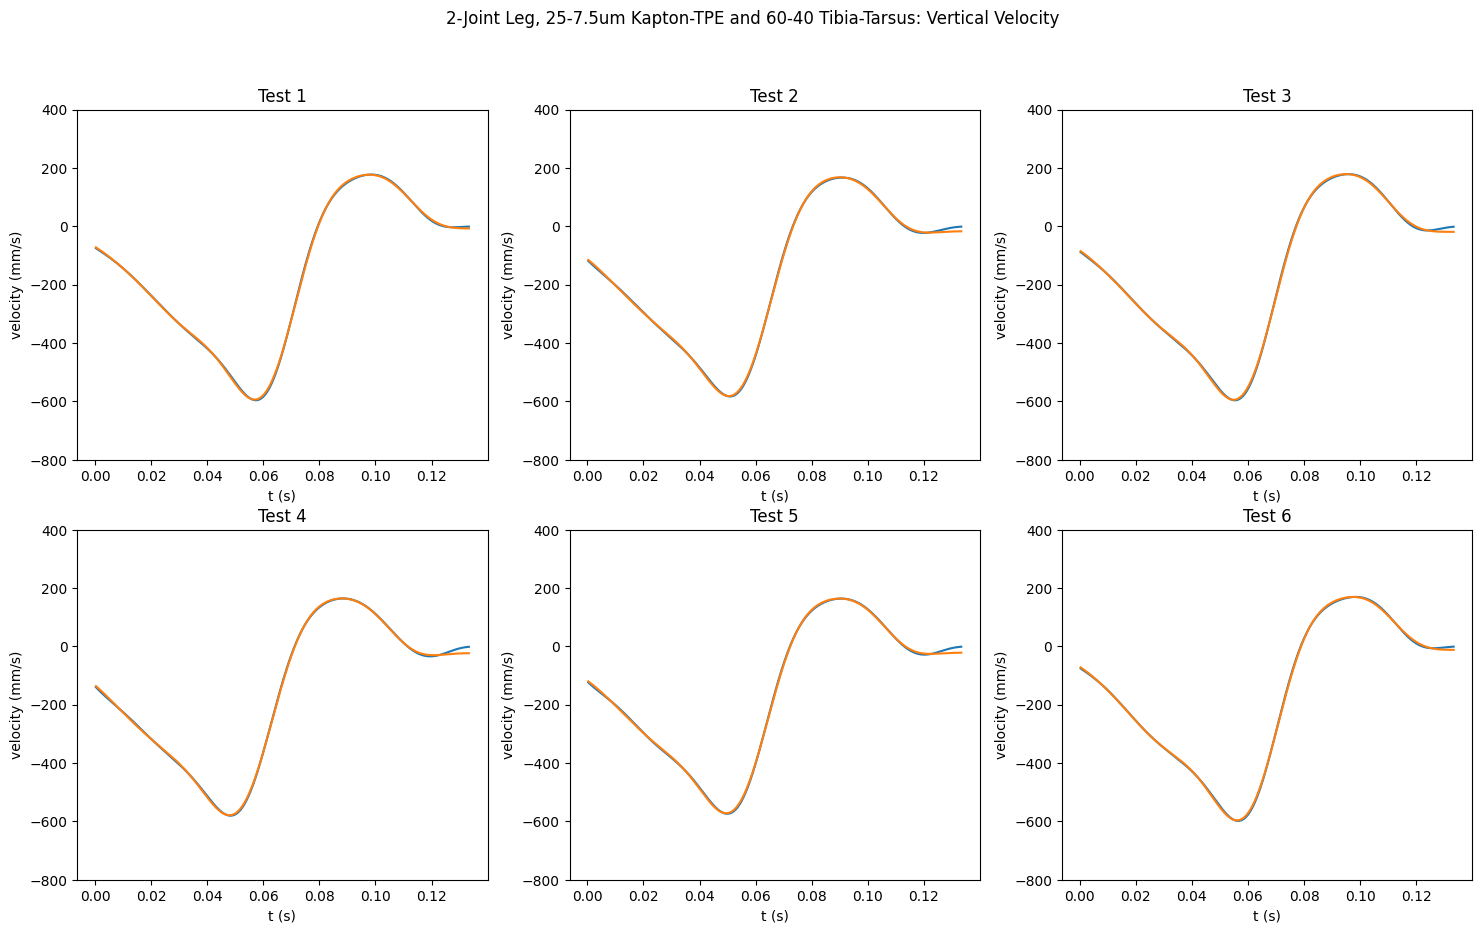

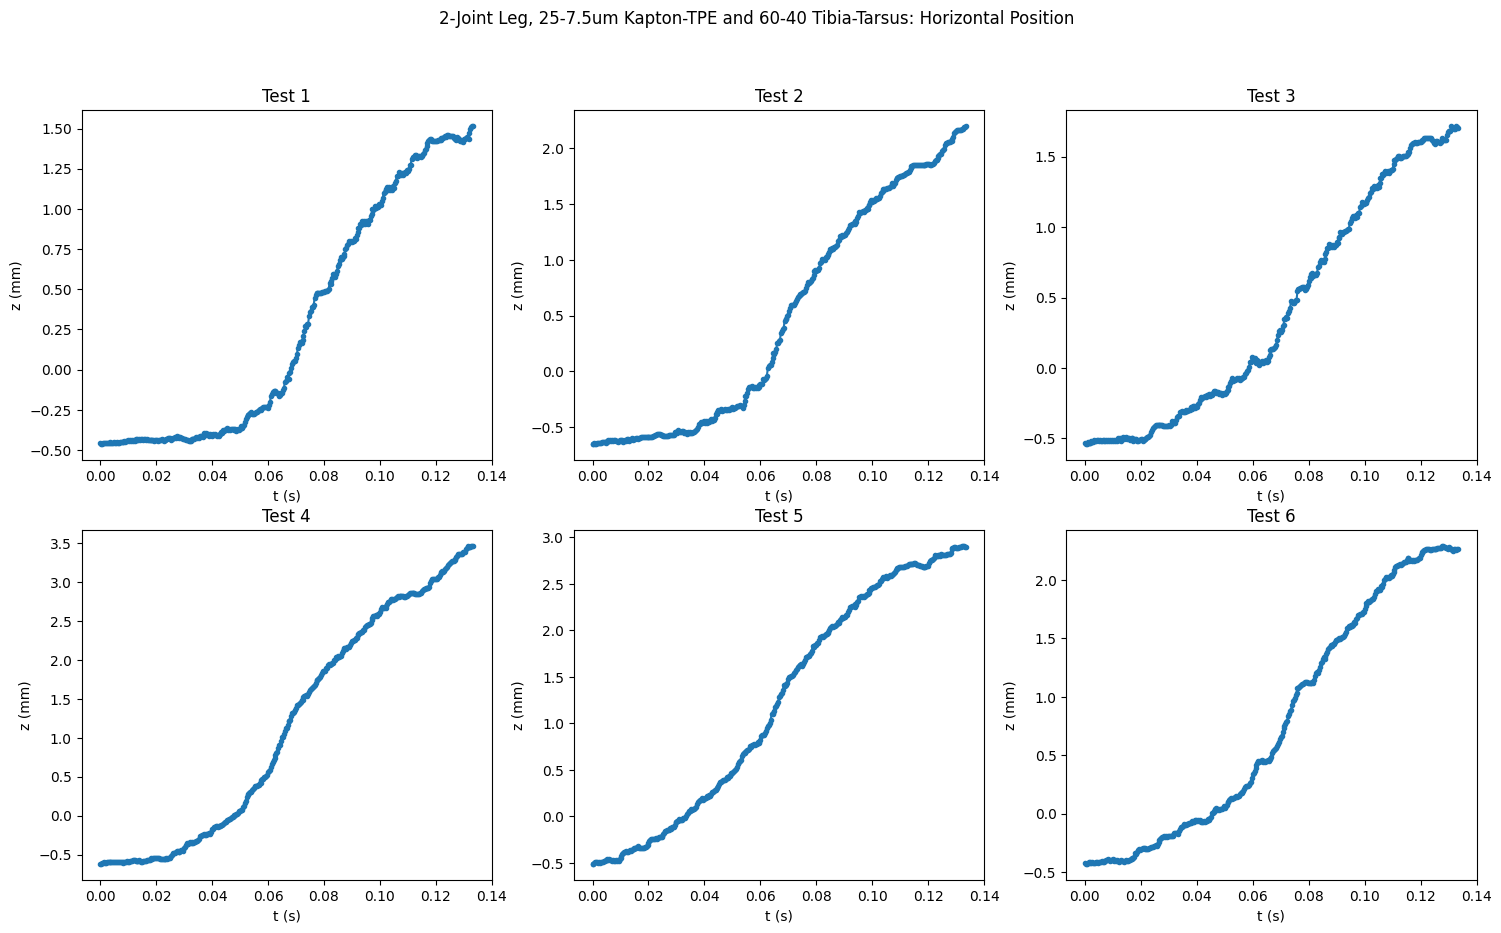

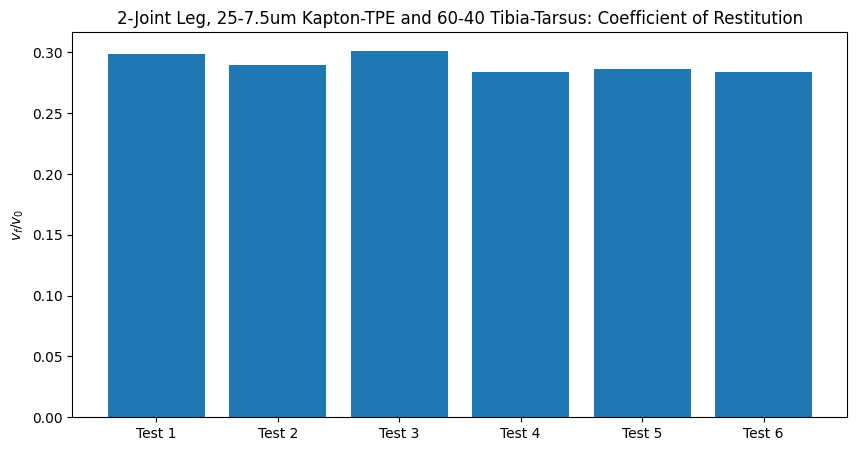

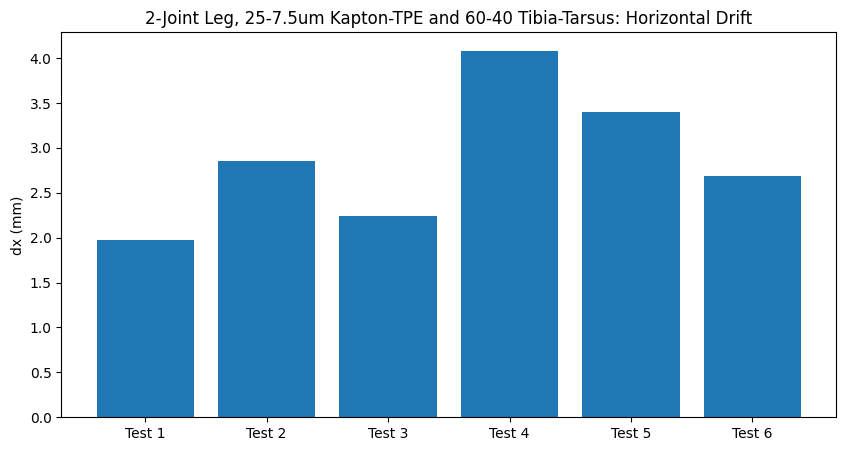

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test5_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/2joint_25-25um_40-60_45deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysi

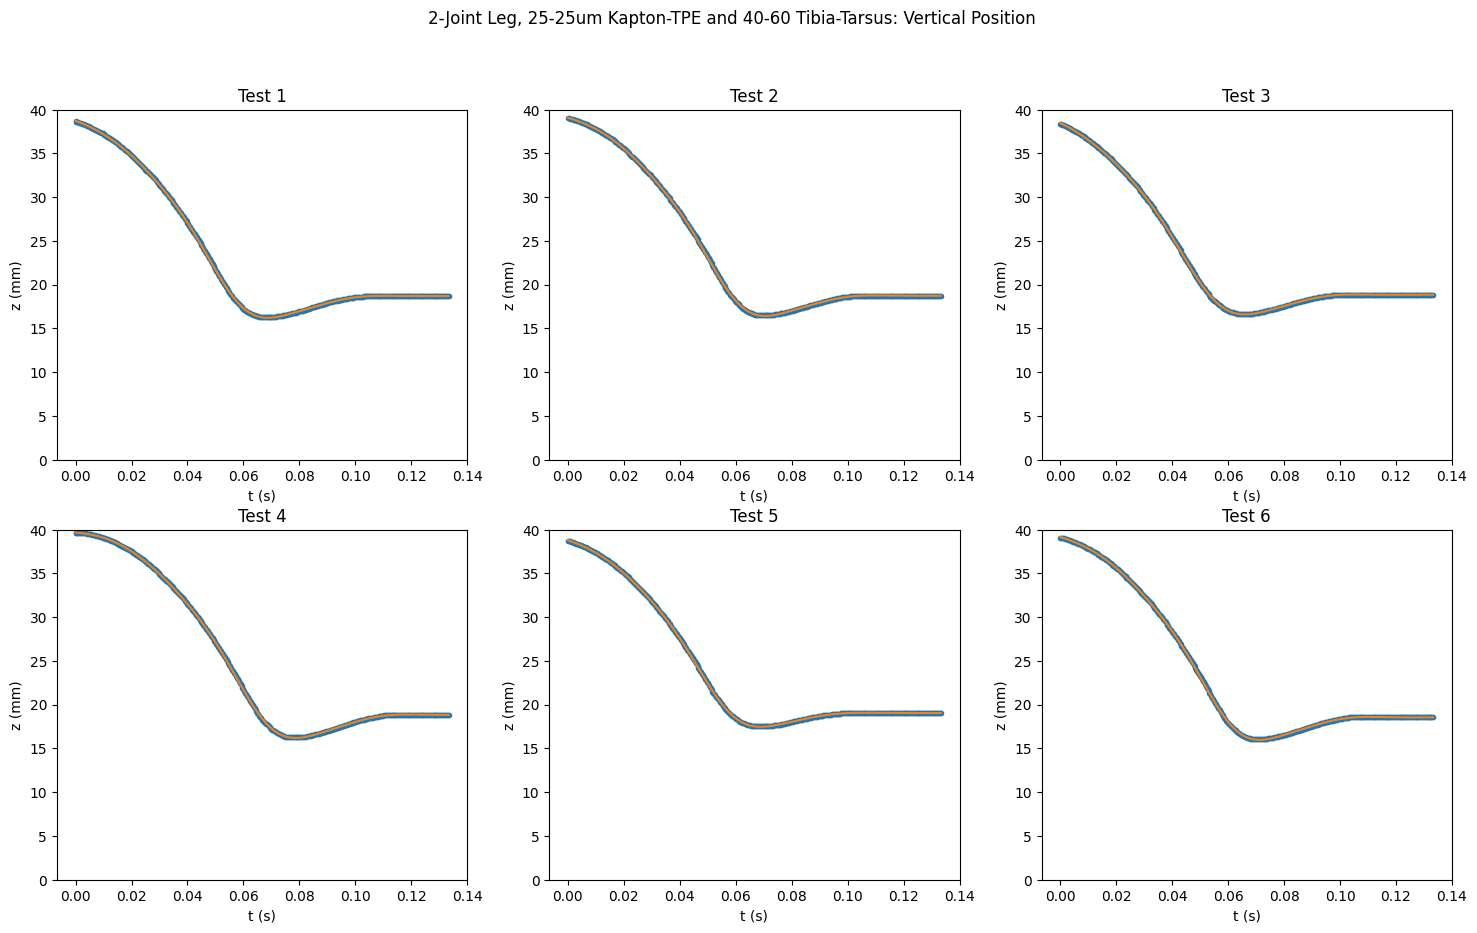

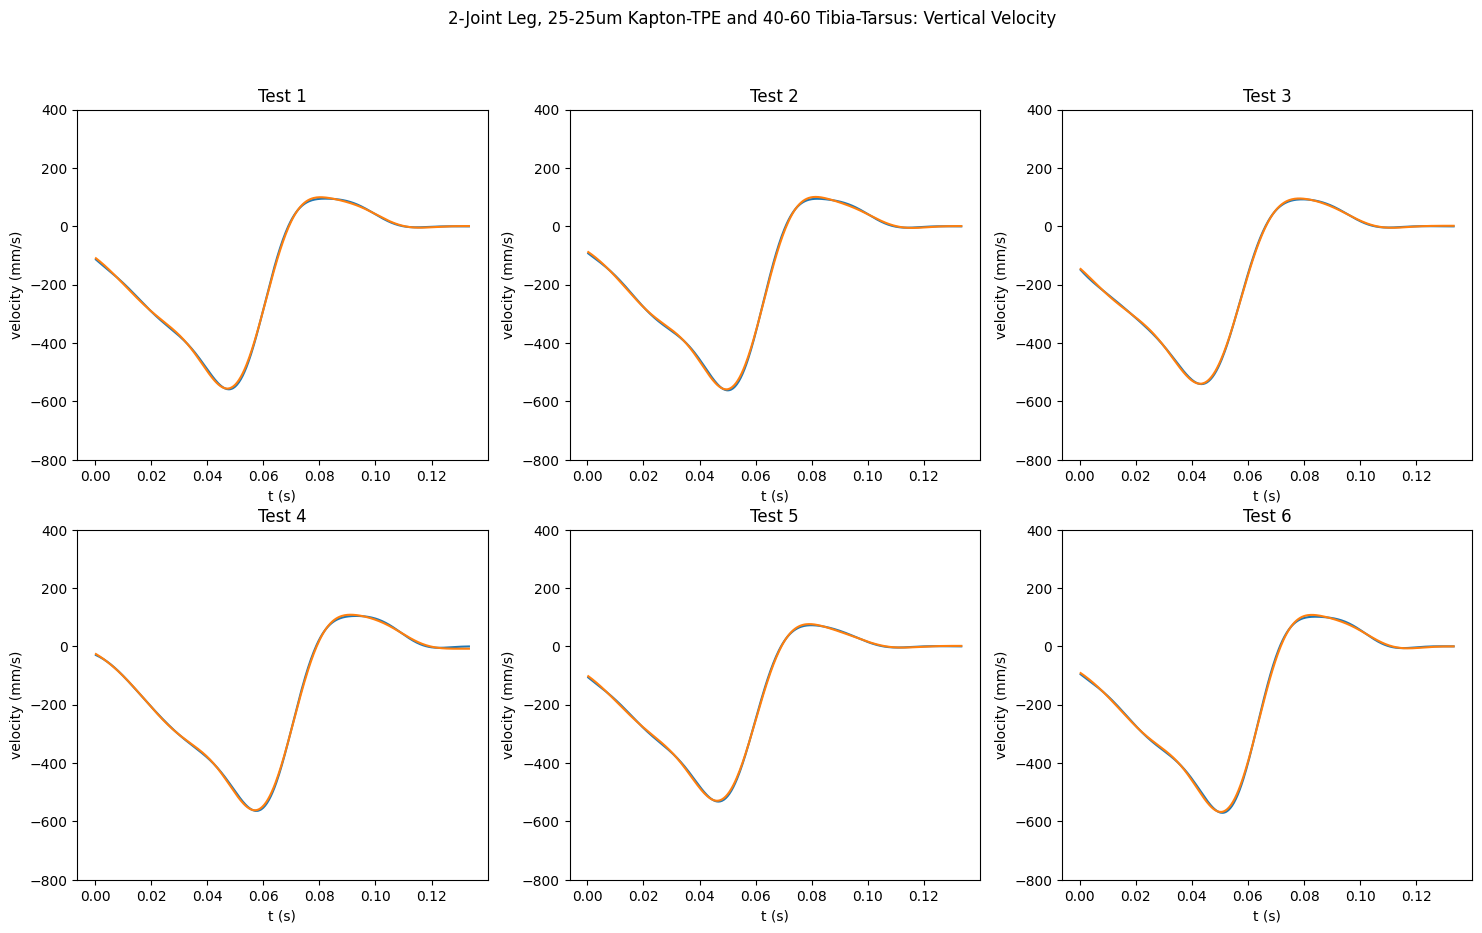

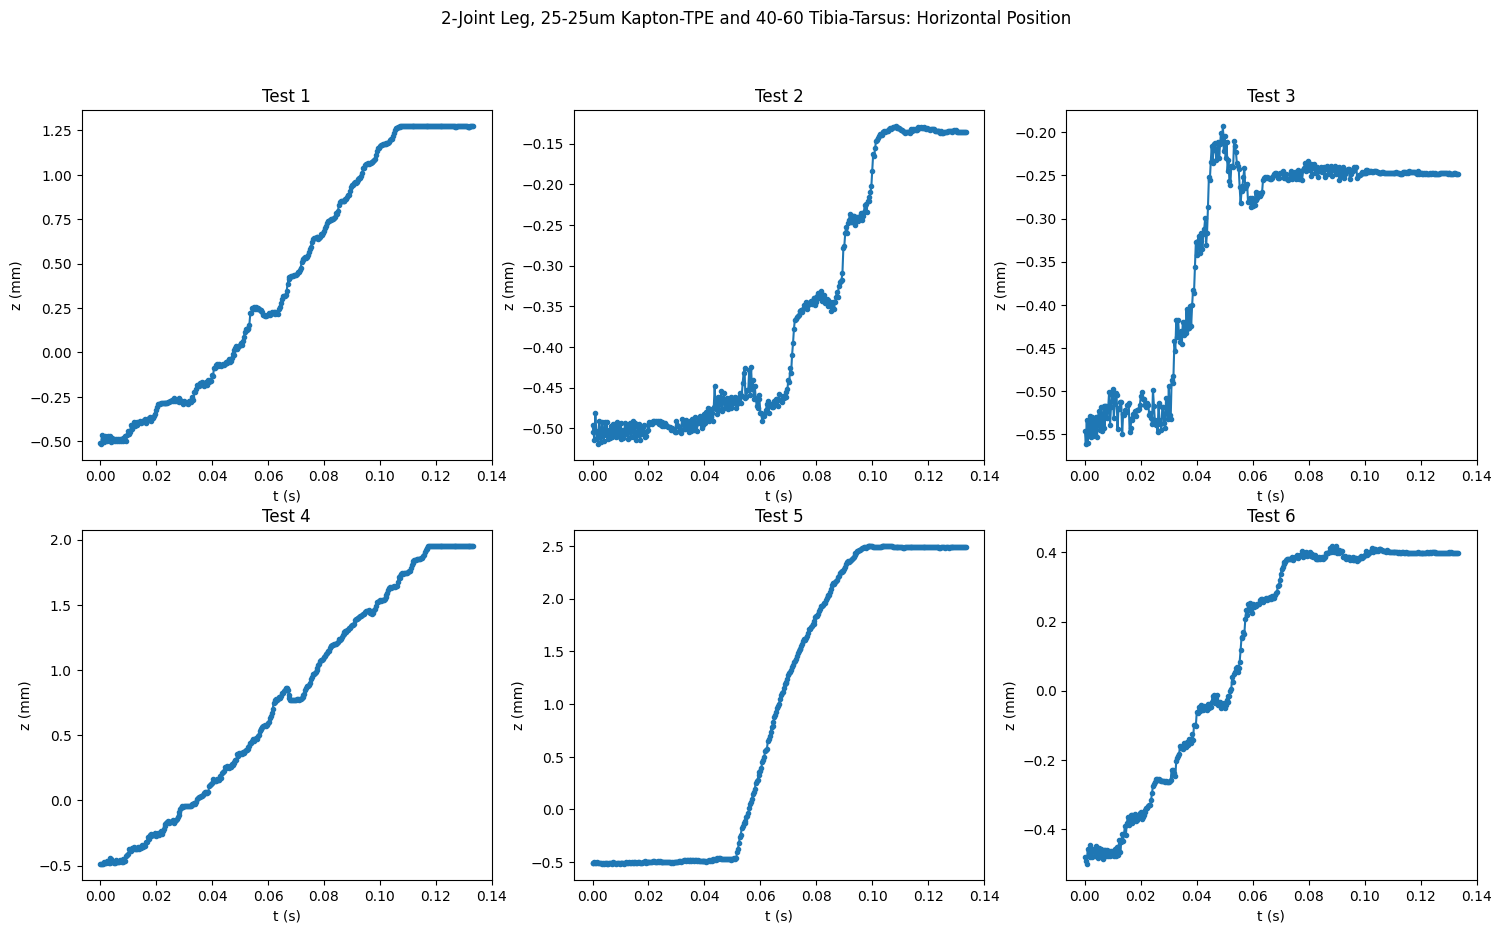

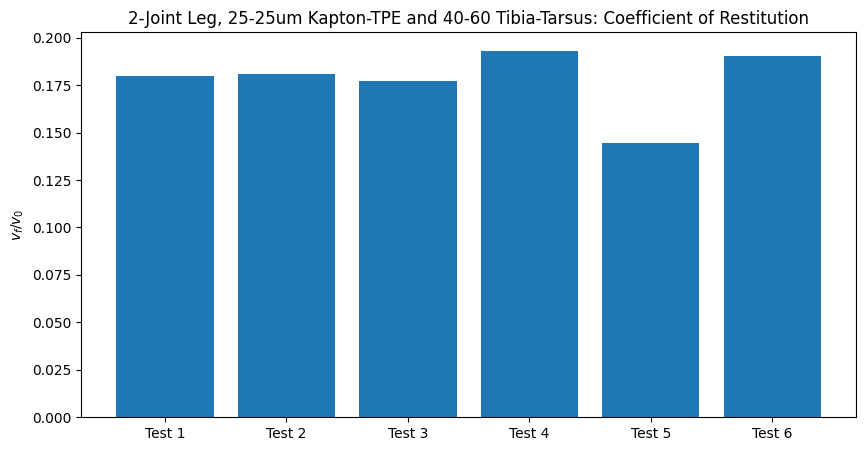

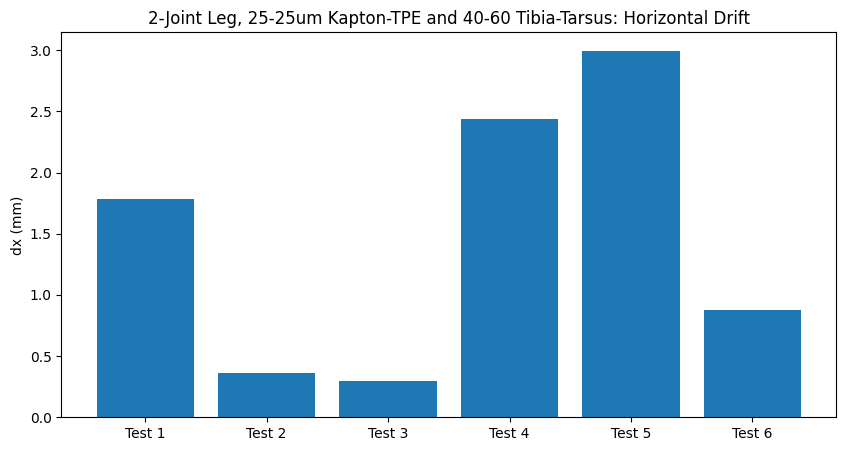

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-25um Kapton-TPE and 40-60 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test3_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test4_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysis/Scripts/../Data/Drop Test/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/2joint_25-25um_60-40_45deg_test2_3000fps_400frames_success.txt
video_fps: 3000
num_frames: 400
/Users/christian/My Drive/20230218/Harvard/Micro Lab/RoboBee/Compliant Legs/Compliant Leg Analysi

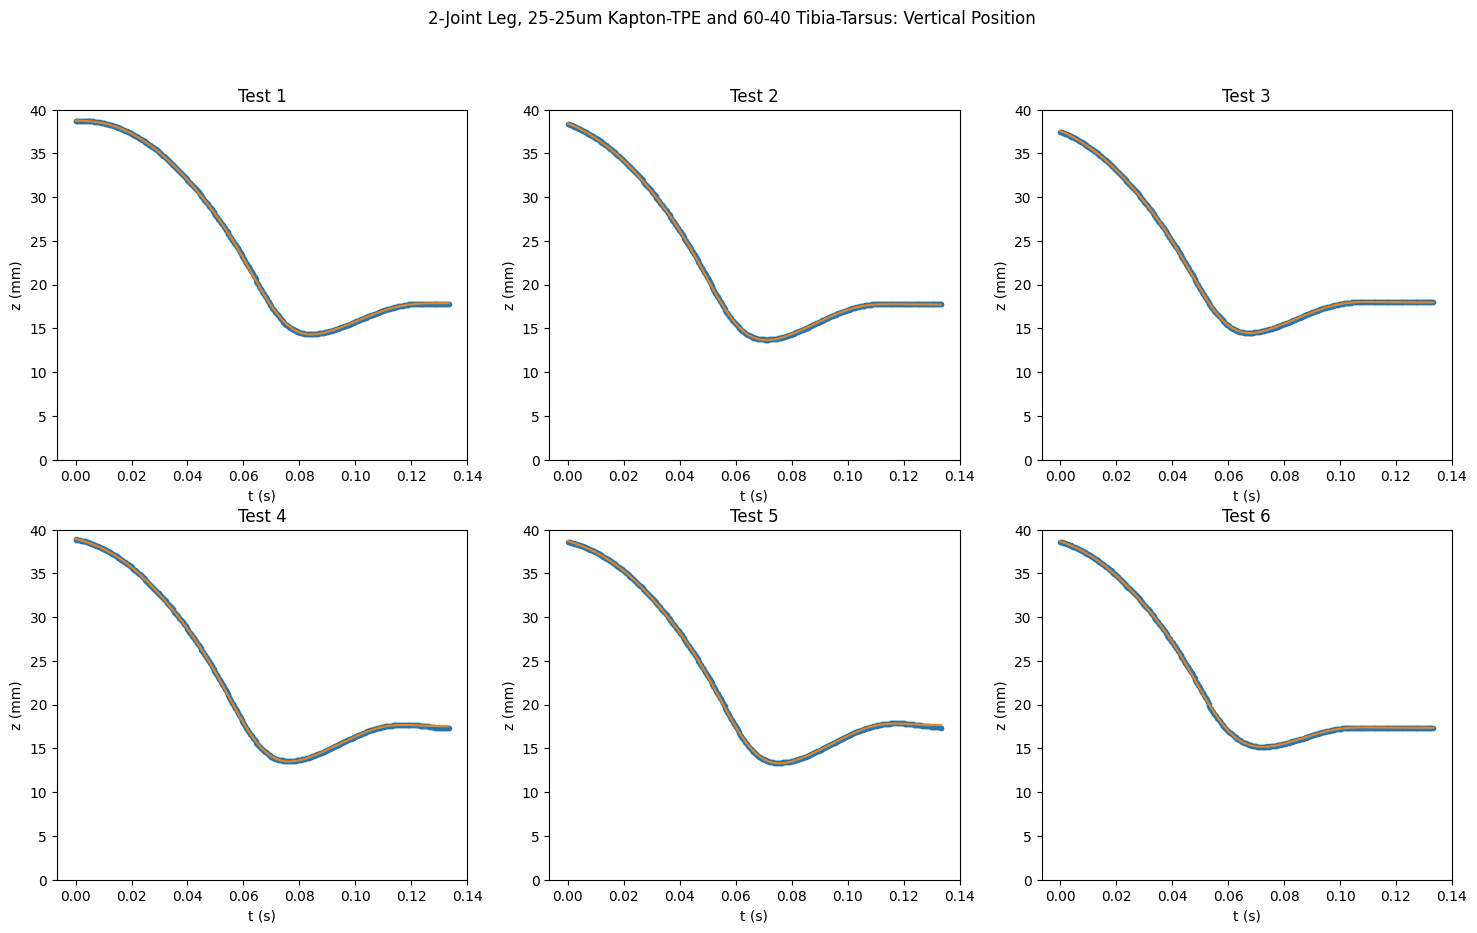

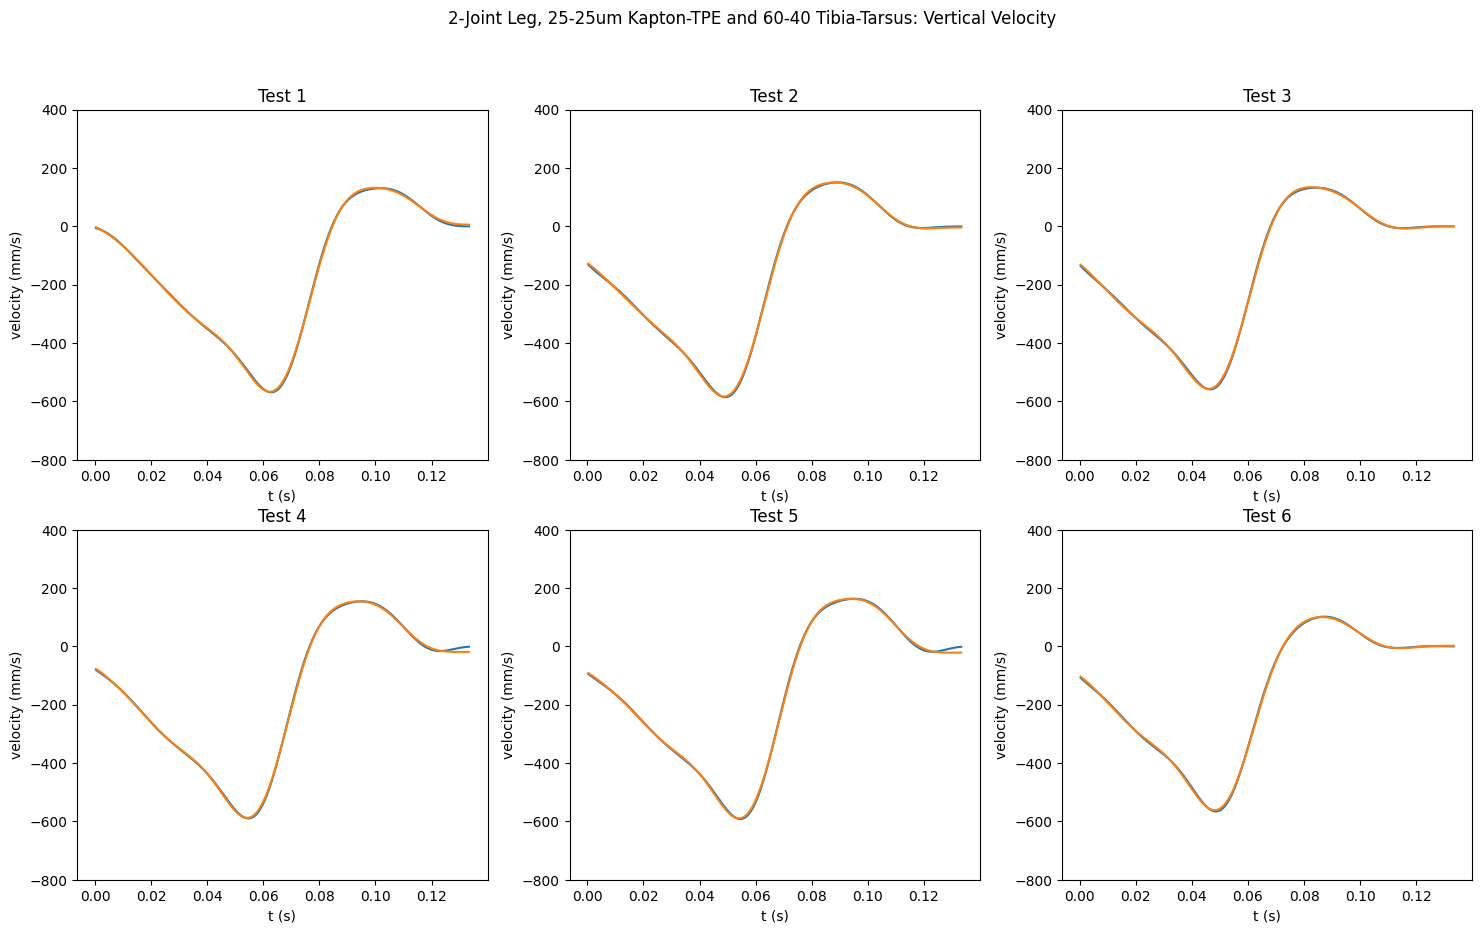

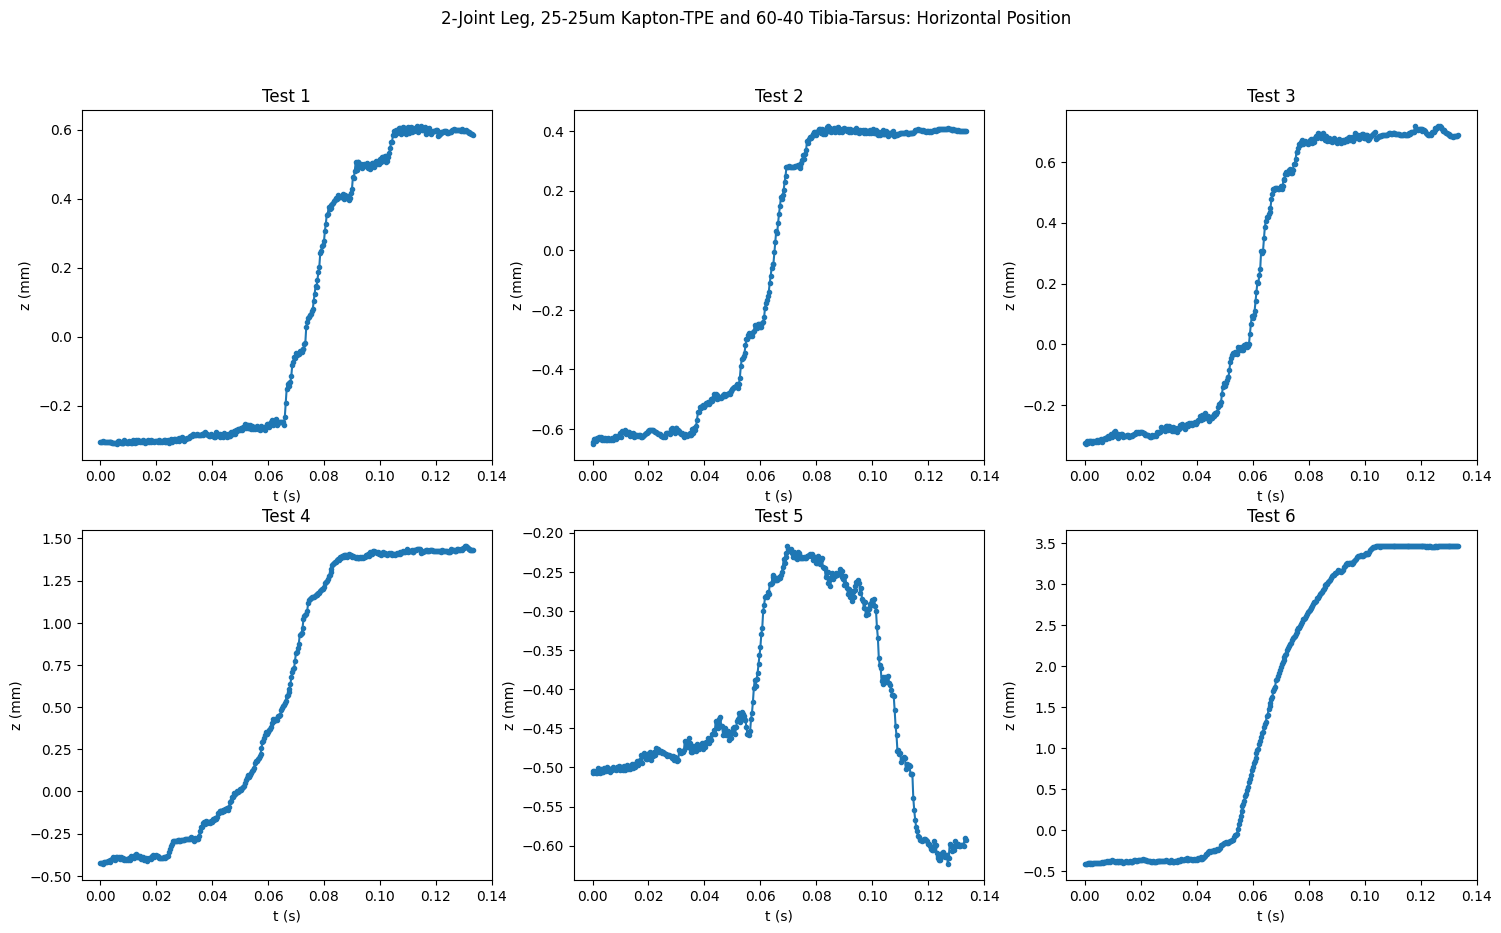

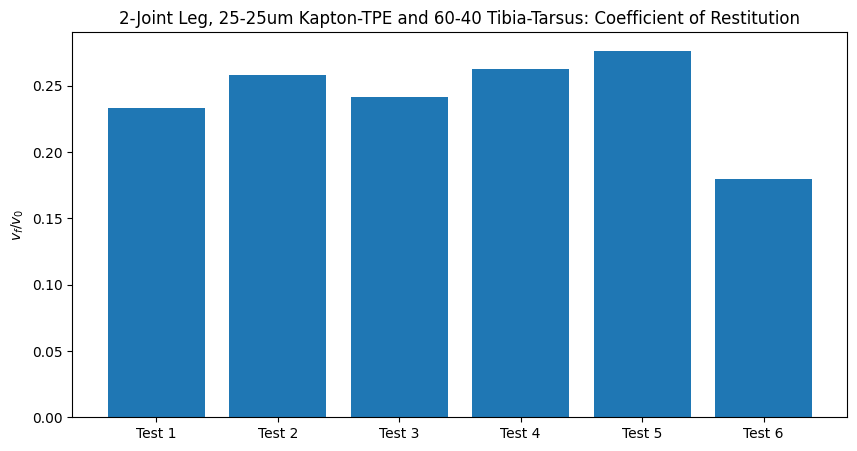

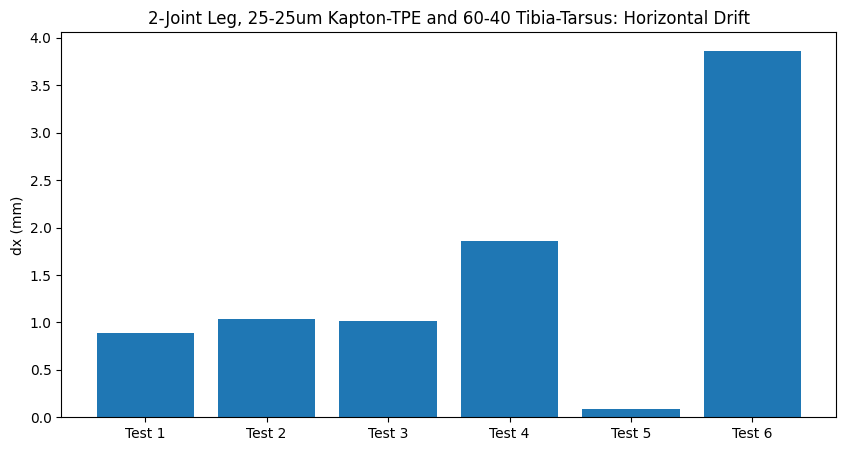

In [ ]:
leg_type = "2-Joint Leg"
leg_name = "25-25um Kapton-TPE and 60-40 Tibia-Tarsus"
filename = os.getcwd() + r"/../Data/Drop Test/Coefficient of Restitution/" + leg_type + r"/" + leg_name + r"/"
cor_mean, cor_std, x_drift_mean, x_drift_std = get_drop_test_cor_and_drift(filename, leg_type + r", " + leg_name)

# Compare Spring and Damping Constants 

In [ ]:
def get_all_b_and_k(dir_path):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    count = 0
    b_set = []
    k_set = []

    for i in range(len(files)):
        # print(files[i])
        if "v1" in dir_path:
            video_fps = 1000
            if "7-5um" in files[i]:
                num_frames = 1700
            elif "25um" in files[i]:
                num_frames = 1200
            else:
                num_frames = 600
            t, theta = extract_data(filename=files[count], start_row=2, video_fps=video_fps, num_frames=num_frames)

            # Normalize angle about 0deg
            theta = theta - np.mean(theta)
            p0=(10, 10, 10, 10, 100, 10)

        else:
            t, theta = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Normalize angle about 0deg
            theta = theta - theta[-1]

            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            theta = filter(theta, fs, fc)

            p0=(20, 30, 10, 10, 200, 40)

        # Optimize exponential decay
        exp_decay_opt, exp_decay_cov = scipy.optimize.curve_fit(underdamped_func, t, theta, p0=p0, bounds=(0,np.inf), max_nfev=5000)
        c1, c2, tau1, tau2, w1, w2 = exp_decay_opt

        tau = np.average((tau1, tau2))
        w = w1

        # print(f"c1: {c1}, c2: {c2}, tau1: {tau1}, tau2: {tau2}, w1: {w1}, w2: {w2}")
        # print(f"tau: {tau}, w: {w}")

        # Leg properties
        m_leg = 3e-6
        L_leg = 28e-3
        I_leg = 1/3 * m_leg * L_leg ** 2
        
        # Calculate b and k
        b = 2 * I_leg / tau
        k = I_leg * (w**2 + (1 / tau)**2)

        # print(f"b: {b}, k: {k}")

        b_set.append(b)
        k_set.append(k)

        # Update count
        count = count + 1

    b_mean = np.mean(b_set)
    b_std = np.std(b_set)
    # print(f"b_mean: {b_mean}")
    # print(f"b_std: {b_std}")

    k_mean = np.mean(k_set)
    k_std = np.std(k_set)
    # print(f"k_mean: {k_mean}")
    # print(f"k_std: {k_std}")

    return b_mean, b_std, k_mean, k_std

In [ ]:
current_dir = os.getcwd()

video_folders = {
    "TPE & No Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/Buckle Joint/",
    "TPE & 7.5um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/7.5um Kapton-TPE Joint/",
    "TPE & 25um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/25um Kapton-TPE Joint/",
    "TPE & 50um Kapton": current_dir + r"/../Compliant Legs/Flicker Test/Flicker Test v3/50um Kapton-TPE Joint/",
}

b_and_k = np.zeros((len(video_folders), 4))

i = 0
test_names = []
for key in video_folders:
    test_names.append(key)
    dir_path = video_folders[key]
    b_and_k[i,:] = get_b_and_k(dir_path)
    i = i + 1

print(f"[b_mean, b_std, k_mean, k_std]:\n{b_and_k}")

[b_mean, b_std, k_mean, k_std]:
[[1.72681608e-07 1.08469852e-08 3.92216506e-05 3.84628021e-06]
 [1.79012124e-07 3.12668602e-09 4.36134918e-05 2.80862638e-06]
 [1.77691738e-07 1.01313947e-08 4.55165308e-05 2.07953121e-06]
 [1.69642990e-07 5.08560911e-09 4.98041862e-05 9.27393782e-07]]


[3.92216506e-05 4.36134918e-05 4.55165308e-05 4.98041862e-05]


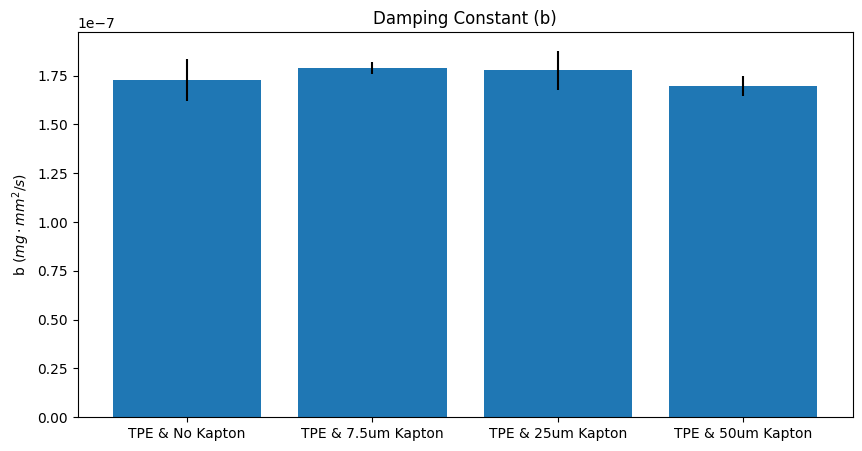

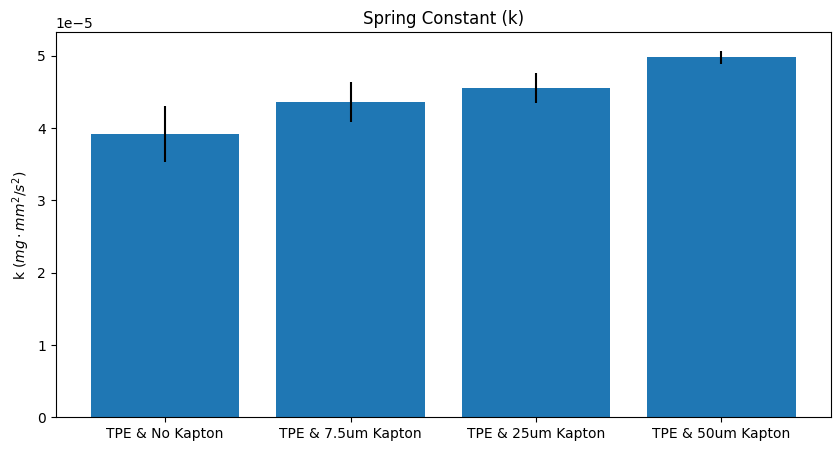

In [ ]:
fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
ax_cor.set_title("Damping Constant (b)")
ax_cor.bar(test_names, b_and_k[:,0], yerr=b_and_k[:,1])
ax_cor.set_ylabel(r"b ($mg \cdot mm^2 / s$)")
# ax_cor.grid()
# plt.xticks(rotation=30, ha='right')

fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
ax_drift.set_title("Spring Constant (k)")
ax_drift.bar(test_names, b_and_k[:,2], yerr=b_and_k[:,3])
ax_drift.set_ylabel(r"k ($mg \cdot mm^2 / s^2$)")
# ax_drift.grid()
# plt.xticks(rotation=30, ha='right')

print(b_and_k[:,2])

# Compare Coefficient of Restitution and Horizontal Drift 

In [ ]:
def get_cor_and_drift(dir_path):
    files = []

    # Iterate directory
    for path in os.listdir(dir_path):
        # check if current path is a file
        if os.path.isfile(os.path.join(dir_path, path)):
            if path[-3:] == "txt":
                files.append(dir_path + path)

    num_cols = int(len(files) / 2)
    num_rows = int(len(files) / num_cols)

    count = 0
    cor = []
    x_drift = []

    # Plot vertical position and velocity
    for i in range(num_rows):
        for j in range(num_cols):
            # print(files[i+j])
            t, x, z = extract_data(filename=files[count], start_row=2, video_fps=3000, num_frames=400)

            # Offset initial drop height
            z0 = 40
            z = z + z0
            
            # Apply filter to raw position data
            fs = 3000  # Sampling frequency
            fc = 40  # Cut-off frequency of the filter
            z_filter = filter(z, fs, fc)
            
            # Compute velocity and filter
            tdot, zdot = finite_forward_difference(t, z_filter)
            zdot_filter = filter(zdot, fs, fc)

            # Update drop test count
            count = count + 1

            v = zdot_filter
            cor.append(coefficient_of_restitution(v))

            dx = np.abs(x[-1] - x[0])
            x_drift.append(dx)

    cor_mean = np.mean(cor)
    cor_std = np.std(cor)
    # print(f"cor_mean: {cor_mean}")
    # print(f"cor_std: {cor_std}")

    x_drift_mean = np.mean(x_drift)
    x_drift_std = np.std(x_drift)
    # print(f"x_drift_mean: {x_drift_mean}")
    # print(f"x_drift_std: {x_drift_std}")

    return cor_mean, cor_std, x_drift_mean, x_drift_std

In [ ]:
current_dir = os.getcwd()

video_folders = {
    "Legacy": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Legacy Leg/",
    r"Rigid, 30$^\circ$ Stance": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/30deg Stance/",
    r"Rigid, 45$^\circ$ Stance": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/45deg Stance/",
    r"Rigid, 60$^\circ$ Stance": current_dir + r"//../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/Rigid Leg/60deg Stance/",
    r"1-Joint, TPE & 25$\mu m$ Kapton": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/25um Kapton-TPE Joint/",
    r"1-Joint, TPE & 0$\mu m$ Kapton": current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/1-Joint Leg/50um Kapton-TPE Joint/",
    r"2-Joint, TPE & 25:0$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:0$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-0um Kapton-TPE and 60-40 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:7.5$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:7.5$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-7.5um Kapton-TPE and 60-40 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:25$\mu m$ Kapton, 40:60 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 40-60 Tibia-Tarsus/",
    r"2-Joints, TPE & 25:25$\mu m$ Kapton, 60:40 Tibia-Tarsus": \
        current_dir + r"/../Compliant Legs/Drop Test/Drop Test v4/Coefficient of Restitution/2-Joint Leg/25-25um Kapton-TPE and 60-40 Tibia-Tarsus/",
}

cor_and_drift = np.zeros((len(video_folders), 4))

i = 0
test_names = []
for key in video_folders:
    test_names.append(key)
    dir_path = video_folders[key]
    cor_and_drift[i,:] = get_cor_and_drift(dir_path)
    i = i + 1

print(f"[cor_mean, cor_std, x_drift_mean, x_drift_std]:\n{cor_and_drift}")

[cor_mean, cor_std, x_drift_mean, x_drift_std]:
[[4.14585077e-01 3.66079469e-02 1.05406079e+01 4.31002152e+00]
 [2.20393846e-01 3.31281530e-02 4.32784547e+00 1.89121194e+00]
 [2.37205261e-01 8.11527301e-02 1.78194041e+00 7.83462138e-01]
 [4.93840577e-01 6.47043041e-02 1.19976321e+00 1.00995986e+00]
 [2.87637750e-01 1.08945017e-02 7.17984082e-01 7.38762568e-01]
 [3.91525771e-01 1.26571270e-02 6.01547678e-01 5.67778286e-01]
 [1.61048827e-01 2.28734617e-02 6.85009362e-01 7.69518073e-01]
 [2.87190768e-01 1.15064509e-02 7.78929767e-01 6.36124456e-01]
 [3.12233064e-01 7.95703306e-03 6.83105098e-01 3.18352679e-01]
 [2.90645361e-01 6.85123433e-03 2.87181900e+00 7.05940829e-01]
 [1.77605971e-01 1.59137024e-02 1.45852767e+00 1.02549553e+00]
 [2.41862123e-01 3.12726483e-02 1.45822725e+00 1.19181433e+00]]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'Legacy'),
  Text(1, 0, 'Rigid, 30$^\\circ$ Stance'),
  Text(2, 0, 'Rigid, 45$^\\circ$ Stance'),
  Text(3, 0, 'Rigid, 60$^\\circ$ Stance'),
  Text(4, 0, '1-Joint, TPE & 25$\\mu m$ Kapton'),
  Text(5, 0, '1-Joint, TPE & 0$\\mu m$ Kapton'),
  Text(6, 0, '2-Joint, TPE & 25:0$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(7, 0, '2-Joints, TPE & 25:0$\\mu m$ Kapton, 60:40 Tibia-Tarsus'),
  Text(8, 0, '2-Joints, TPE & 25:7.5$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(9, 0, '2-Joints, TPE & 25:7.5$\\mu m$ Kapton, 60:40 Tibia-Tarsus'),
  Text(10, 0, '2-Joints, TPE & 25:25$\\mu m$ Kapton, 40:60 Tibia-Tarsus'),
  Text(11, 0, '2-Joints, TPE & 25:25$\\mu m$ Kapton, 60:40 Tibia-Tarsus')])

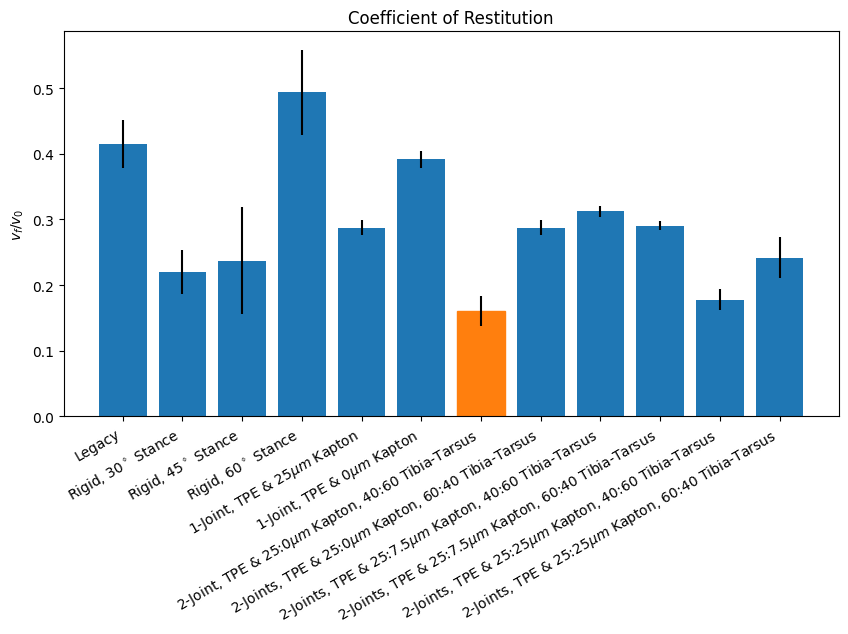

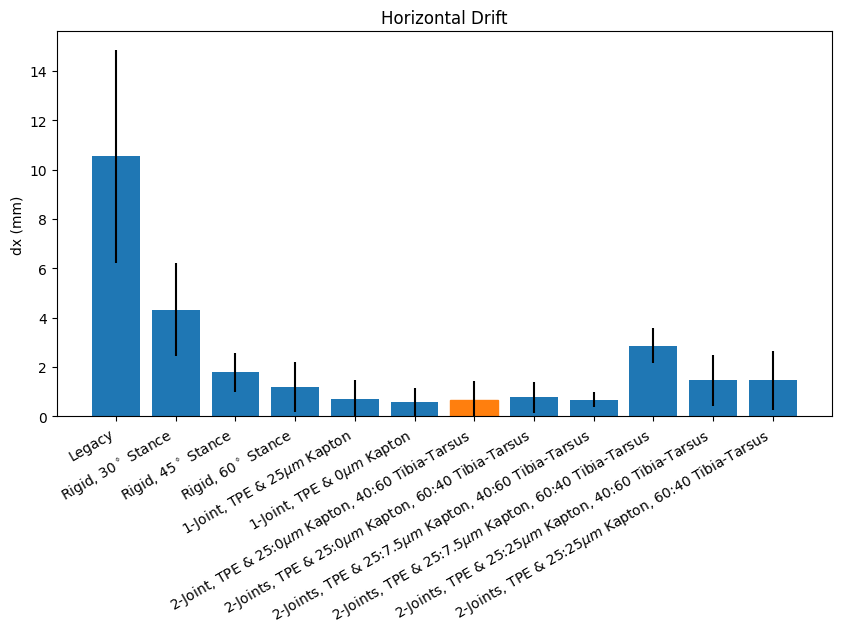

In [ ]:
fig_cor, ax_cor = plt.subplots(figsize=(10, 5))
ax_cor.set_title("Coefficient of Restitution")
barlist = ax_cor.bar(test_names, cor_and_drift[:,0], yerr=cor_and_drift[:,1])
barlist[6].set_color("tab:orange")
ax_cor.set_ylabel(r"$v_f / v_0$")
# ax_cor.grid()
plt.ylim(0,)
plt.xticks(rotation=30, ha='right')

fig_drift, ax_drift = plt.subplots(figsize=(10, 5))
ax_drift.set_title("Horizontal Drift")
barlist = ax_drift.bar(test_names, cor_and_drift[:,2], yerr=cor_and_drift[:,3])
barlist[6].set_color("tab:orange")
ax_drift.set_ylabel("dx (mm)")
# ax_drift.grid()
plt.ylim(0,)
plt.xticks(rotation=30, ha='right')